# Trabajo de Fin de Grado: Estudio sobre la aplicación de aprendizaje automático en mercados financieros

**Por Julio Ballesteros**


# Notebook 2: Creación y estudio de variables para predecir el precio.
        
Una vez estudiadas las características y estadísticas de las series temporales que se intentan predecir, se pasa a la búsqueda y estudio de variables que tengan relación con las series temporales y puedan usarse para predecir los valores futuros. Para este estudio se observa cada posible variable y se describen los nuevos datos estudiando su relación con las variables a predecir.

El objetivo del notebook es comprobar la hipótesis que afirma que la distribución de retornos o tendencia es diferente según el valor de la variable a estudiar o, dicho de otro modo, que la variable afecta los valores a predecir.

**Tabla de contenidos**
    1. Variables objetivo
    2. Variables independientes
        2.1. Precio actual
        2.2. Volumen
        2.3. Media móvil simple
        2.4. RSI
        2.5. MACD
        2.6. PPO
        2.7. Bandas de Bollinger
        2.8. NVI
        2.9. ADX
    3. Mapa de correlación entre variables        

### Notebook Setup

In [1]:
#Importar librerías
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import talib

#Importar modulos
from scripts import data_preparation

In [2]:
# Python ≥3.7 necesario
assert sys.version_info >= (3, 7)

np.random.seed(222)

from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')

# función para guardar los gráficos
PROJECT_ROOT_DIR = '.'
FIGS_FOLDER = 'figures'
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, FIGS_FOLDER)

def save_fig(name, figs_path=FIGS_PATH, subfolder=None, tight_layout=True, extension="png", resolution=300):
    fig_path = os.path.join(figs_path, subfolder) if subfolder else figs_path
    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
        
    path = os.path.join(fig_path, name + "." + extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=extension, dpi=resolution)

# 1. Variables objetivo

Las variables de las que se estudiará su viabilidad para predecirlas serán, todas con un horizonte de n días (FORECAST_HORIZON), las siguientes:
    - El cambio porcentual en el precio
    - La tendencia del movimiento
    - La posición a adquirir
    - El precio de cierre
Estas variables se utilizarán como objetivo en los algoritmos de aprendizaje automático.

In [3]:
# realizar la obtención de datos del notebook anterior
FORECAST_HORIZON = 5
stock_prices = data_preparation.get_stock_prices('^GSPC', start_date='2000-01-01', end_date='2021-04-01')
stock_prices = data_preparation.create_price_change_vars(stock_prices, FORECAST_HORIZON)

# obtener las variables a predecir
stock_prices = data_preparation.create_target_features(stock_prices, FORECAST_HORIZON)

# eliminar nans
stock_prices = stock_prices.dropna()

display(stock_prices.head(8))

open     high      low    close      volume   returns  bullish  \
Date                                                                            
2000-01-07  1403.45  1441.47  1400.73  1441.47  1225200000 -1.890761        0   
2000-01-10  1441.47  1464.36  1441.47  1457.60  1064800000  0.163549        1   
2000-01-11  1457.60  1458.66  1434.42  1438.56  1014000000  2.796873        1   
2000-01-12  1438.56  1442.60  1427.08  1432.25   974600000  2.149617        1   
2000-01-13  1432.25  1454.20  1432.25  1449.68  1030400000  3.294025        1   
2000-01-14  1449.68  1473.00  1449.68  1465.15  1085900000  1.642767        1   
2000-01-18  1465.15  1465.15  1451.30  1455.14  1056700000 -0.168771        0   
2000-01-19  1455.14  1461.39  1448.68  1455.90  1087800000  1.205372        1   

            position  future_close  future_returns  future_bullish  \
Date                                                                 
2000-01-07         0       1465.15        1.642767               1   
2000-01-10         2       1455.14       -0.168771               0   
2000-01-11         1       1455.90        1.205372               1   
2000-01-12         1       1445.57        0.930005               1   
2000-01-13         1       1441.36       -0.573920               0   
2000-01-14         2       1401.53       -4.342218               0   
2000-01-18         2       1410.03       -3.100045               0   
2000-01-19         2       1404.09       -3.558624               0   

            future_position  
Date                         
2000-01-07                2  
2000-01-10                2  
2000-01-11                2  
2000-01-12                2  
2000-01-13                2  
2000-01-14                0  
2000-01-18                0  
2000-01-19                0

# 2. Variables independientes

## 2.1. Precio actual
Se examina si existe correlación entre el precio de cierre y el precio futuro de cierre, para ver si puede ser utilizado para predecirlo.

Evidentemente hay correlación, por ser una serie temporal el precio futuro parte del actual y cuanto menor sea el horizonte temporal menos habrá variado teniendo en cuenta la distribución de los retornos. Por lo tanto, como en cualquier predicción de serie temporales, se necesita el valor actual para predecir el futuro.

close  future_close
close         1.000000      0.998187
future_close  0.998187      1.000000

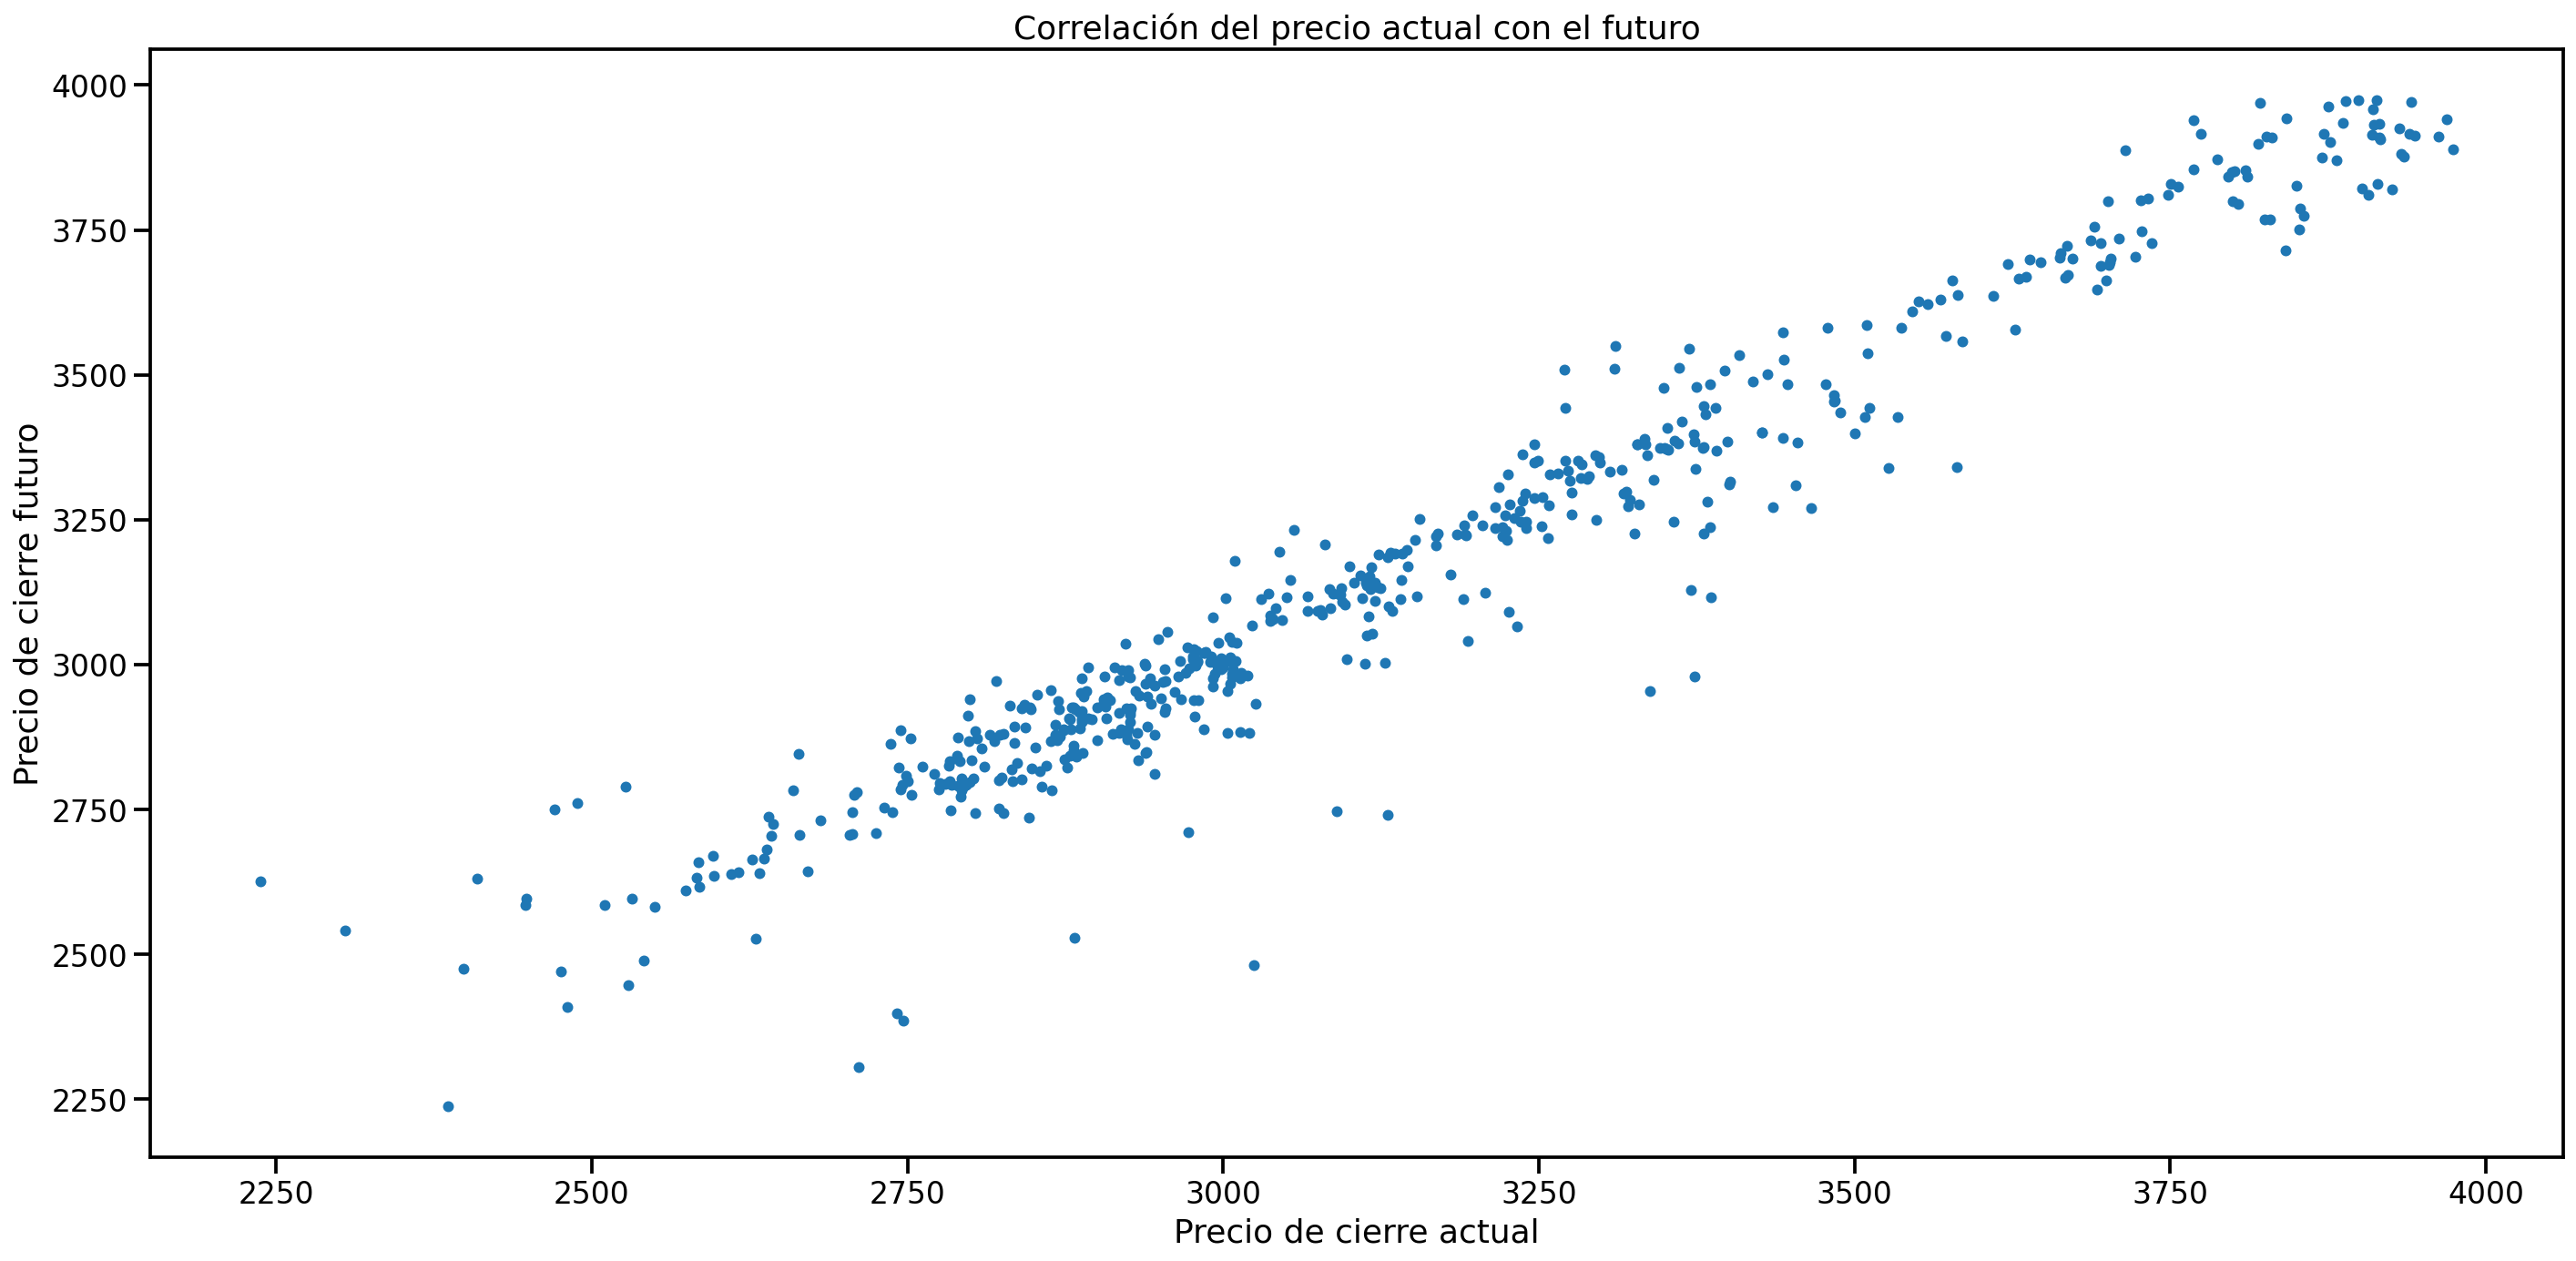

In [4]:
# se comprueba si hay correlación entre el precio actual y el futuro
display(stock_prices[['close', 'future_close']].corr())

# dibujar scatter plot del precio actual y futuro
fig, ax = plt.subplots(figsize=(20, 10))
stock_prices['2019':].plot(kind='scatter', x='close', y='future_close', ax=ax)
plt.title('Correlación del precio actual con el futuro')
plt.xlabel('Precio de cierre actual')
plt.ylabel('Precio de cierre futuro')

save_fig('figure_2_1')
plt.show()

## 2.2. Volumen
Se observa la distribución del volumen y se busca correlación con los retornos futuros.
Puede verse un incremento en la desviación típica de los retornos en volúmenes altos, lo que significa que volúmenes altos se relacionan con volatilidad alta. Aunque por la propiedad de autocorrelación los retornos actuales ya aportan información para los futuros (volatilidad autocorrelacionada), el volumen puede aportar información adicional.

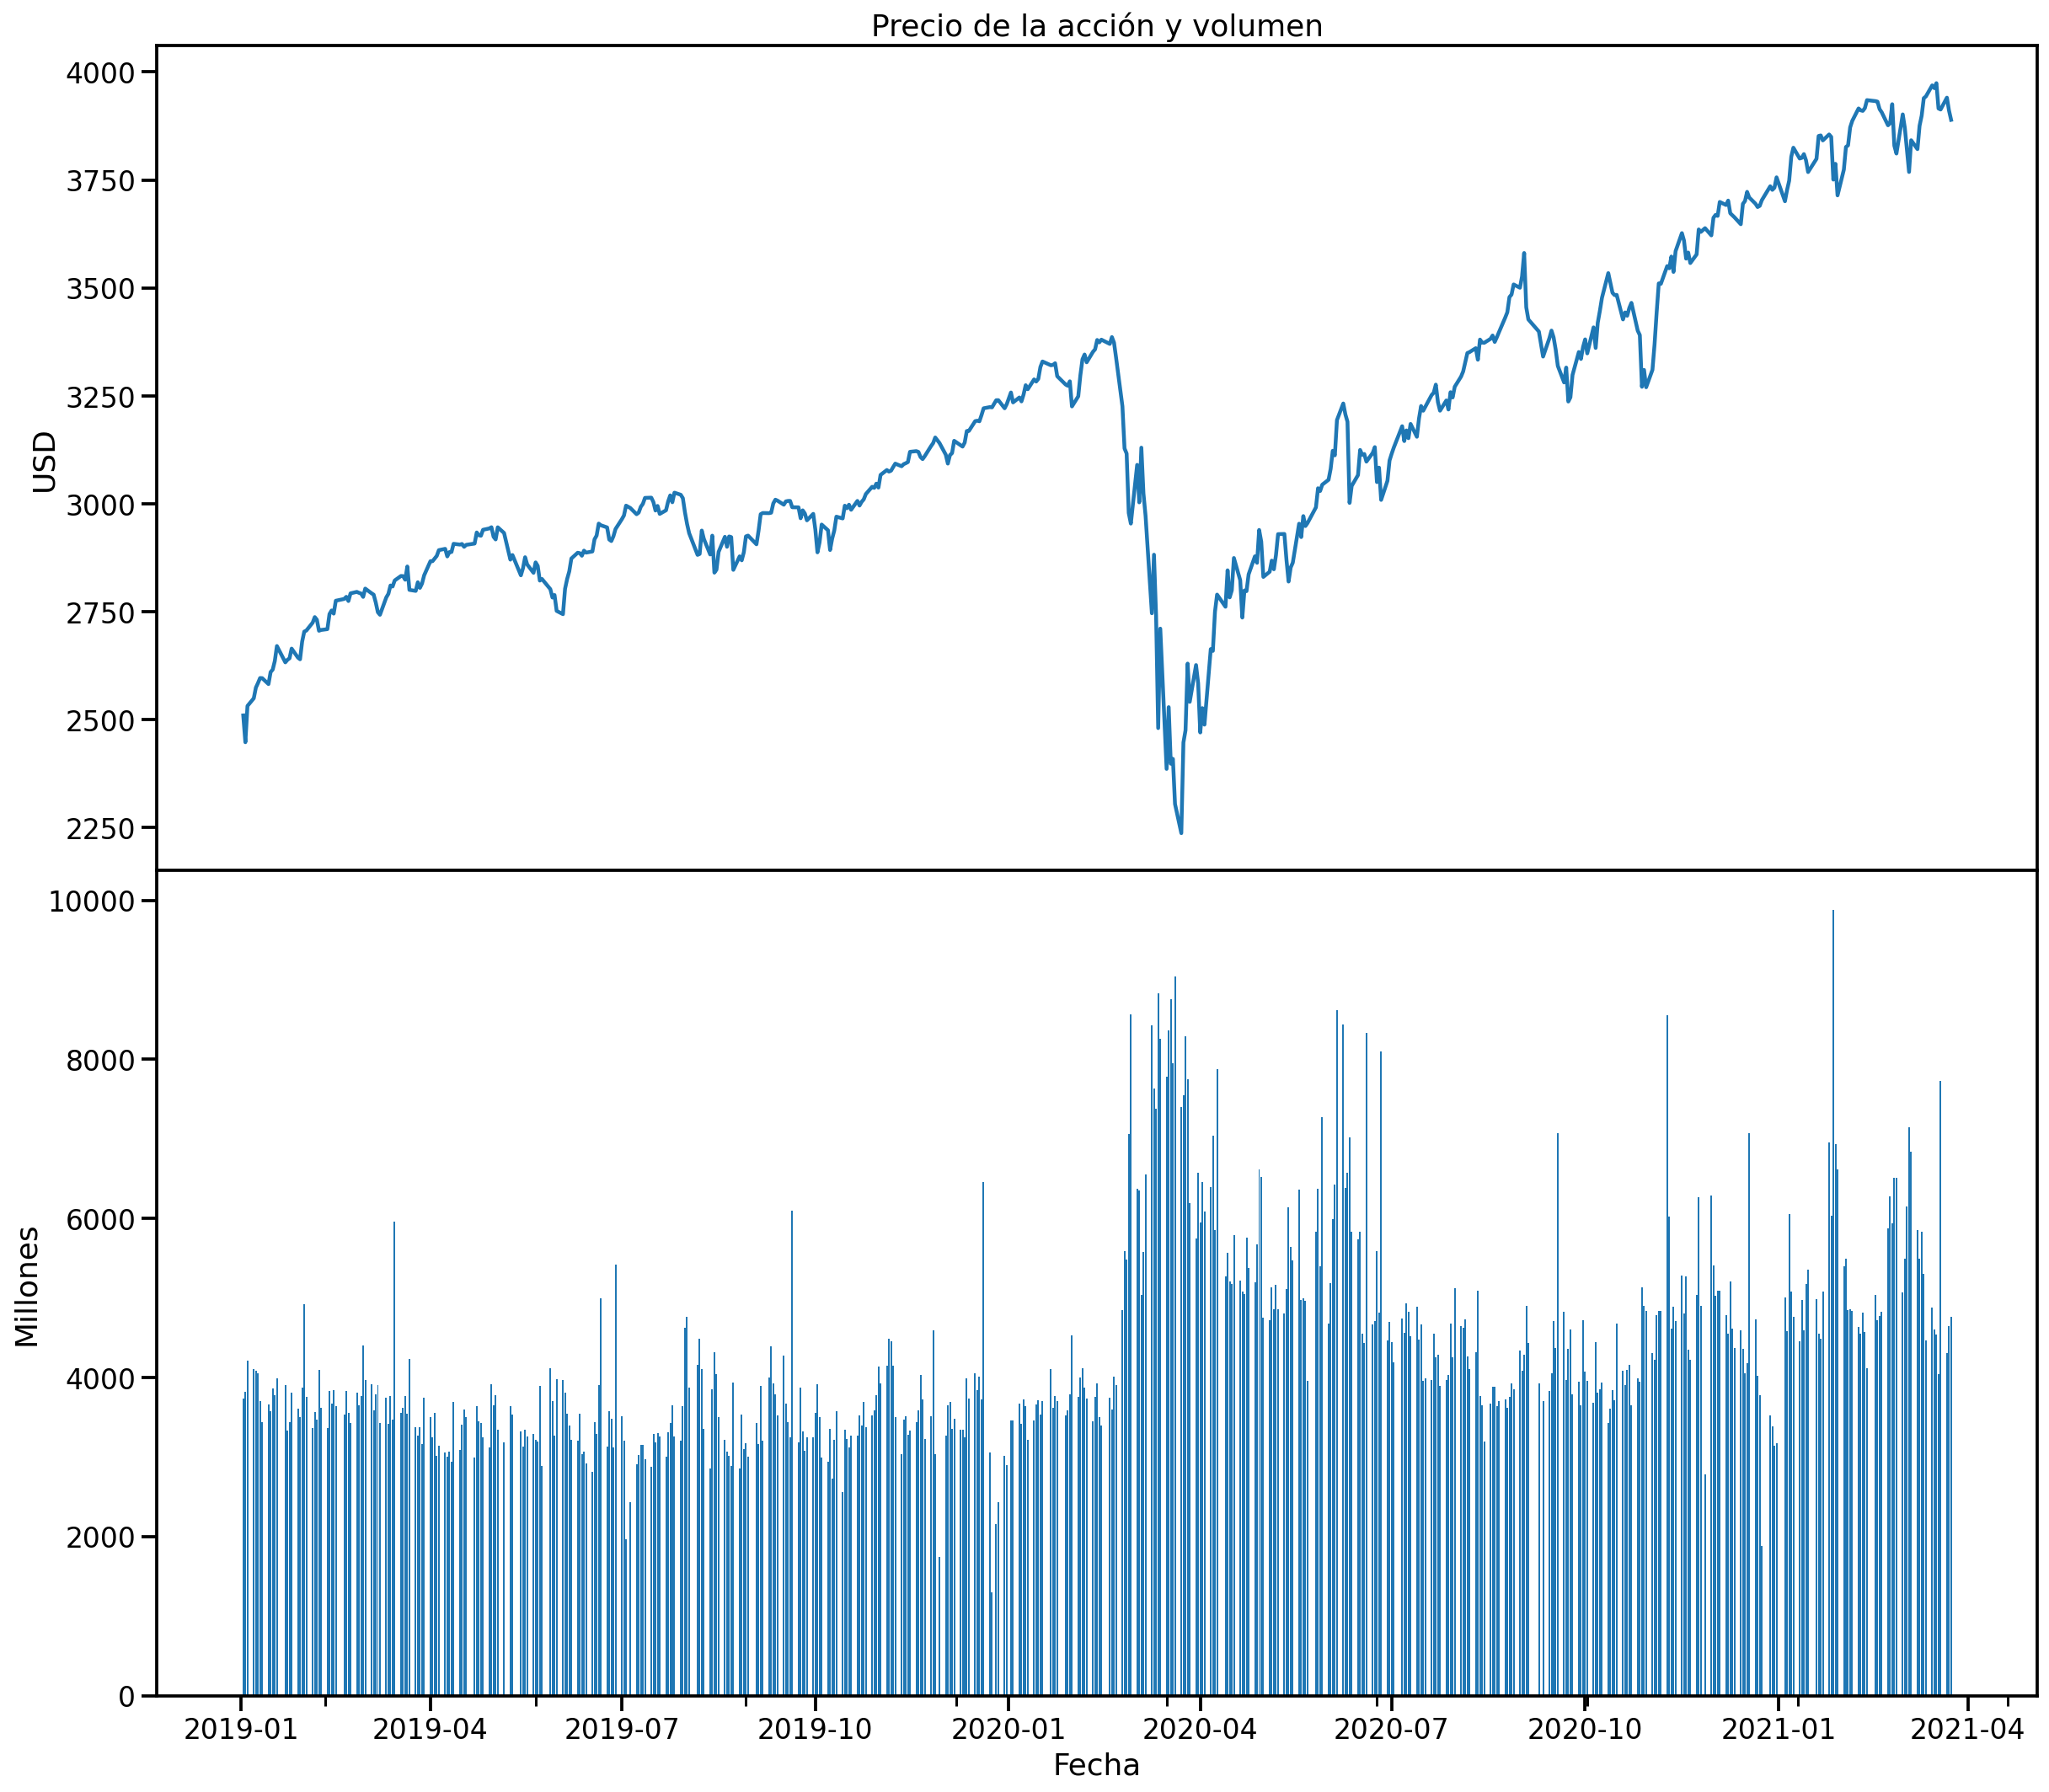

In [5]:
# gráfica del precio con el volumen
def plot_volume(data, starting_date):
    data = data.loc[starting_date:]
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)
    
    # gráfica del precio
    data['close'].plot(ax=ax[0])
    ax[0].set_title('Precio de la acción y volumen')
    ax[0].set_ylabel('USD')
    ax[0].set_xlabel('Fecha')

    # gráfica del volumen
    ax[1].bar(data.index, data['volume'] / 1000000)
    ax[1].set_ylabel('Millones')
    ax[1].set_xlabel('Fecha')

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_2', tight_layout=False)
    plt.show()
    
plot_volume(stock_prices, '2019')

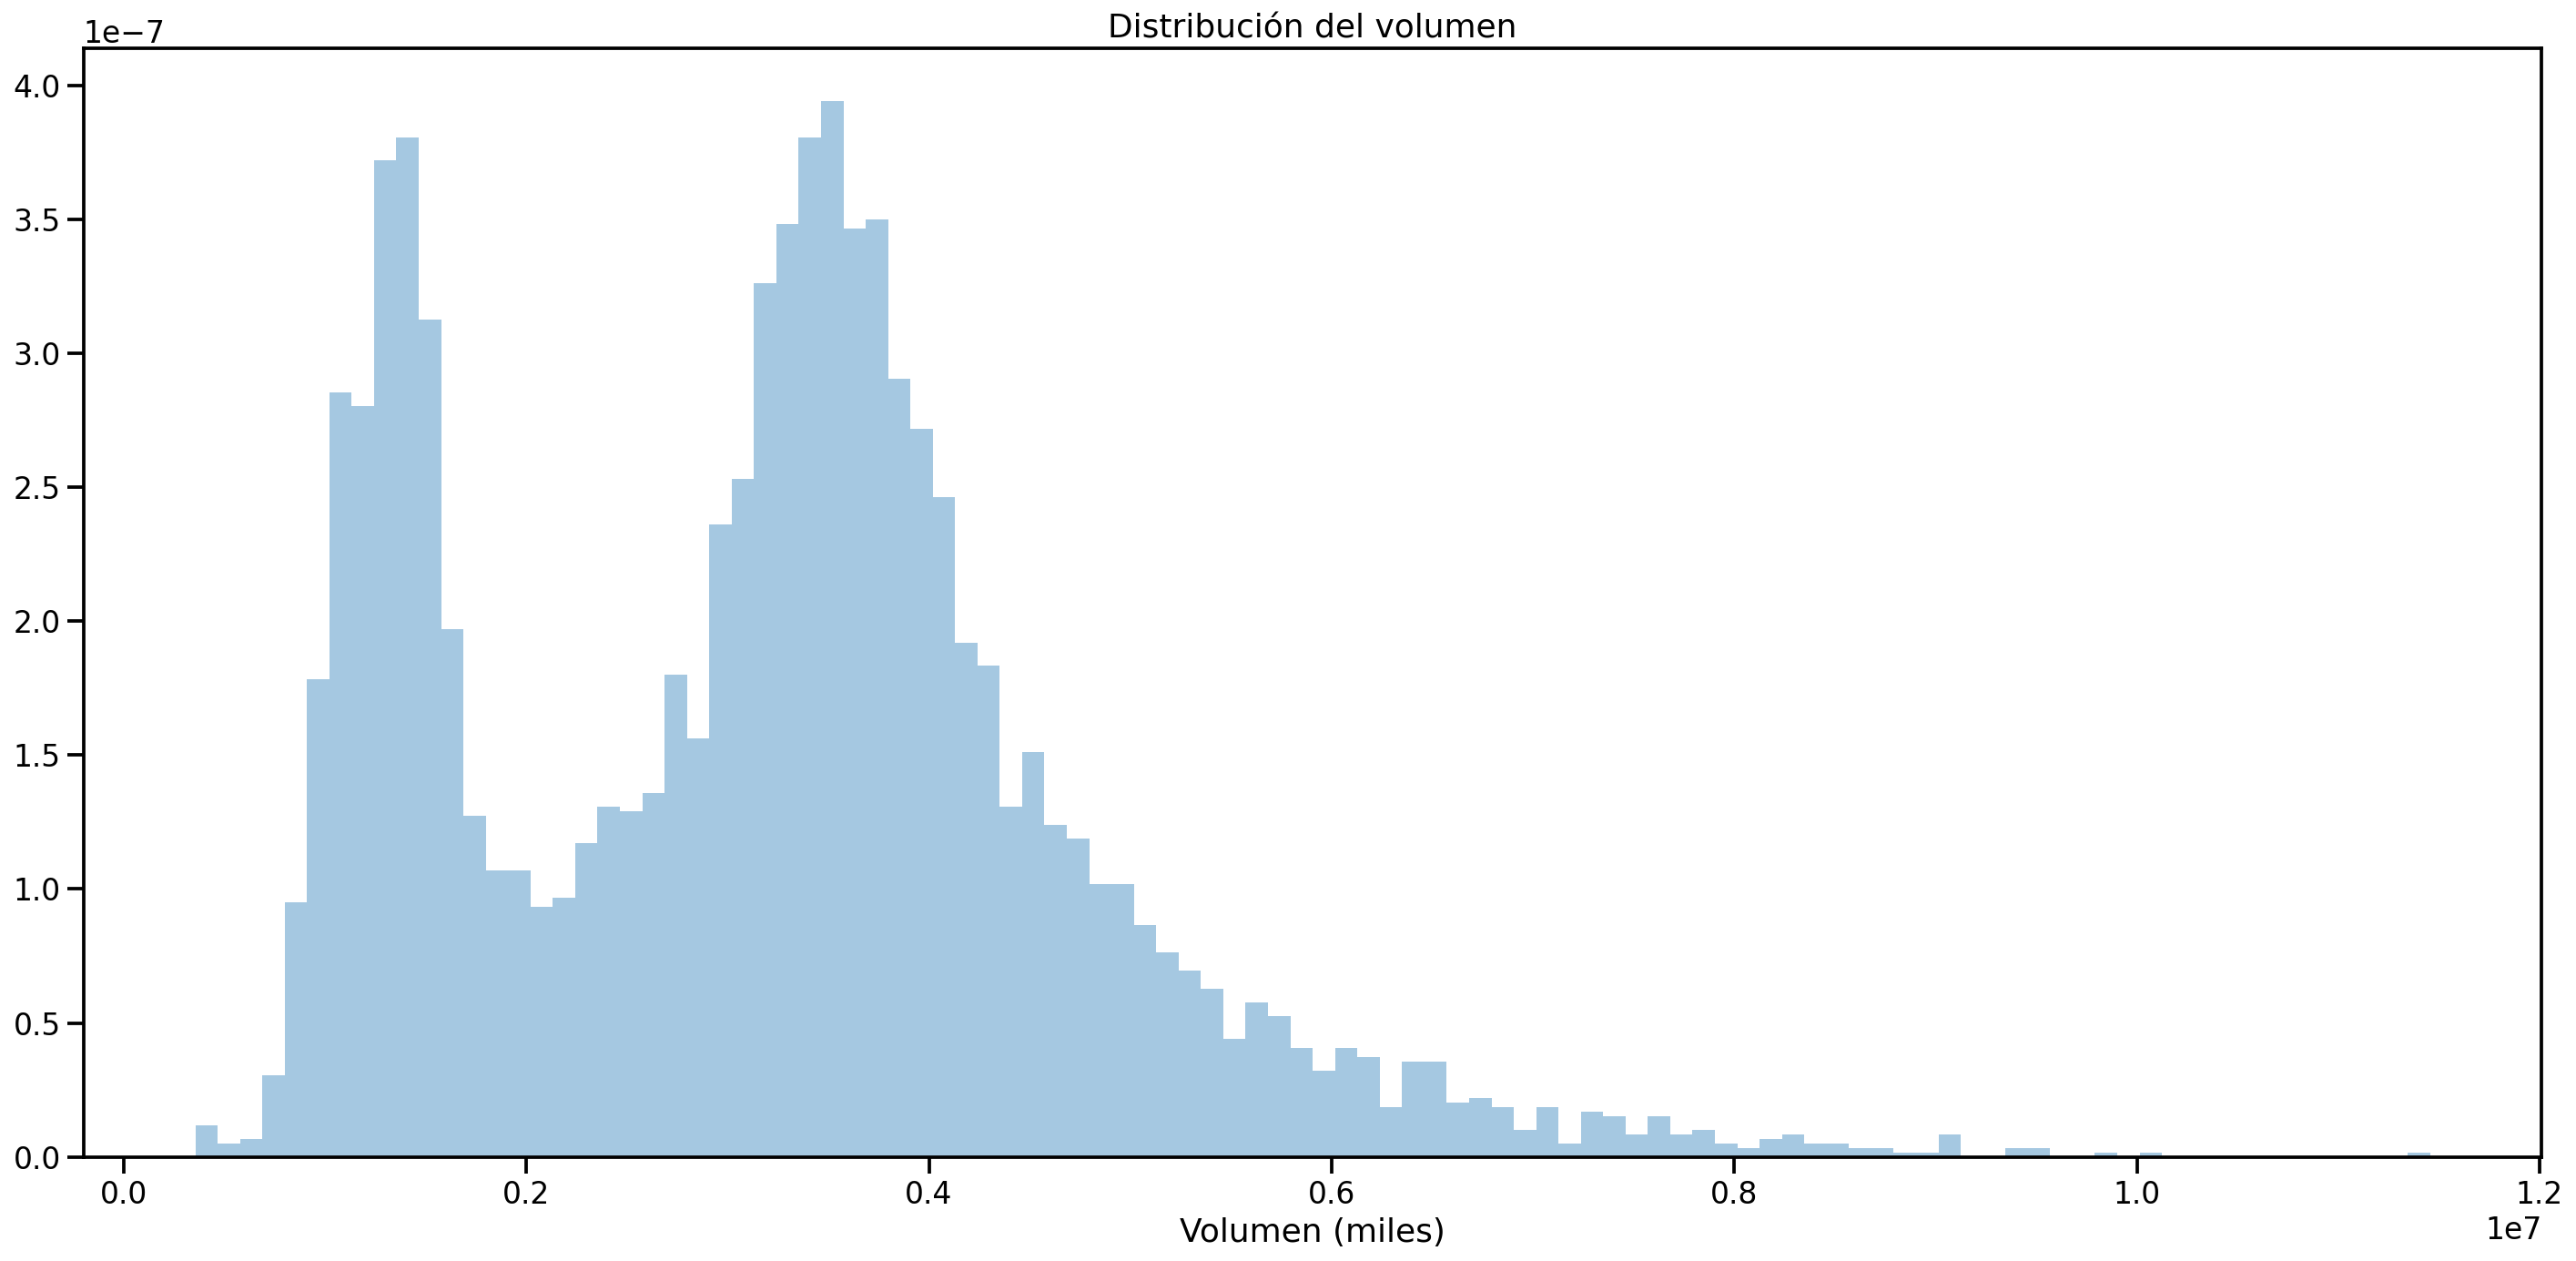

In [6]:
#gráfica de la distribución del volumen
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(stock_prices.volume/1000, norm_hist=True, kde=False, bins=100, ax=ax)

plt.title('Distribución del volumen')
plt.xlabel('Volumen (miles)')

save_fig('figure_2_2_1')
plt.show()

Correlación del volumen con otras variables:
volume               1.000000
returns             -0.064130
future_returns       0.022139
volatility           0.225014
future_volatility    0.173825
Name: volume, dtype: float64


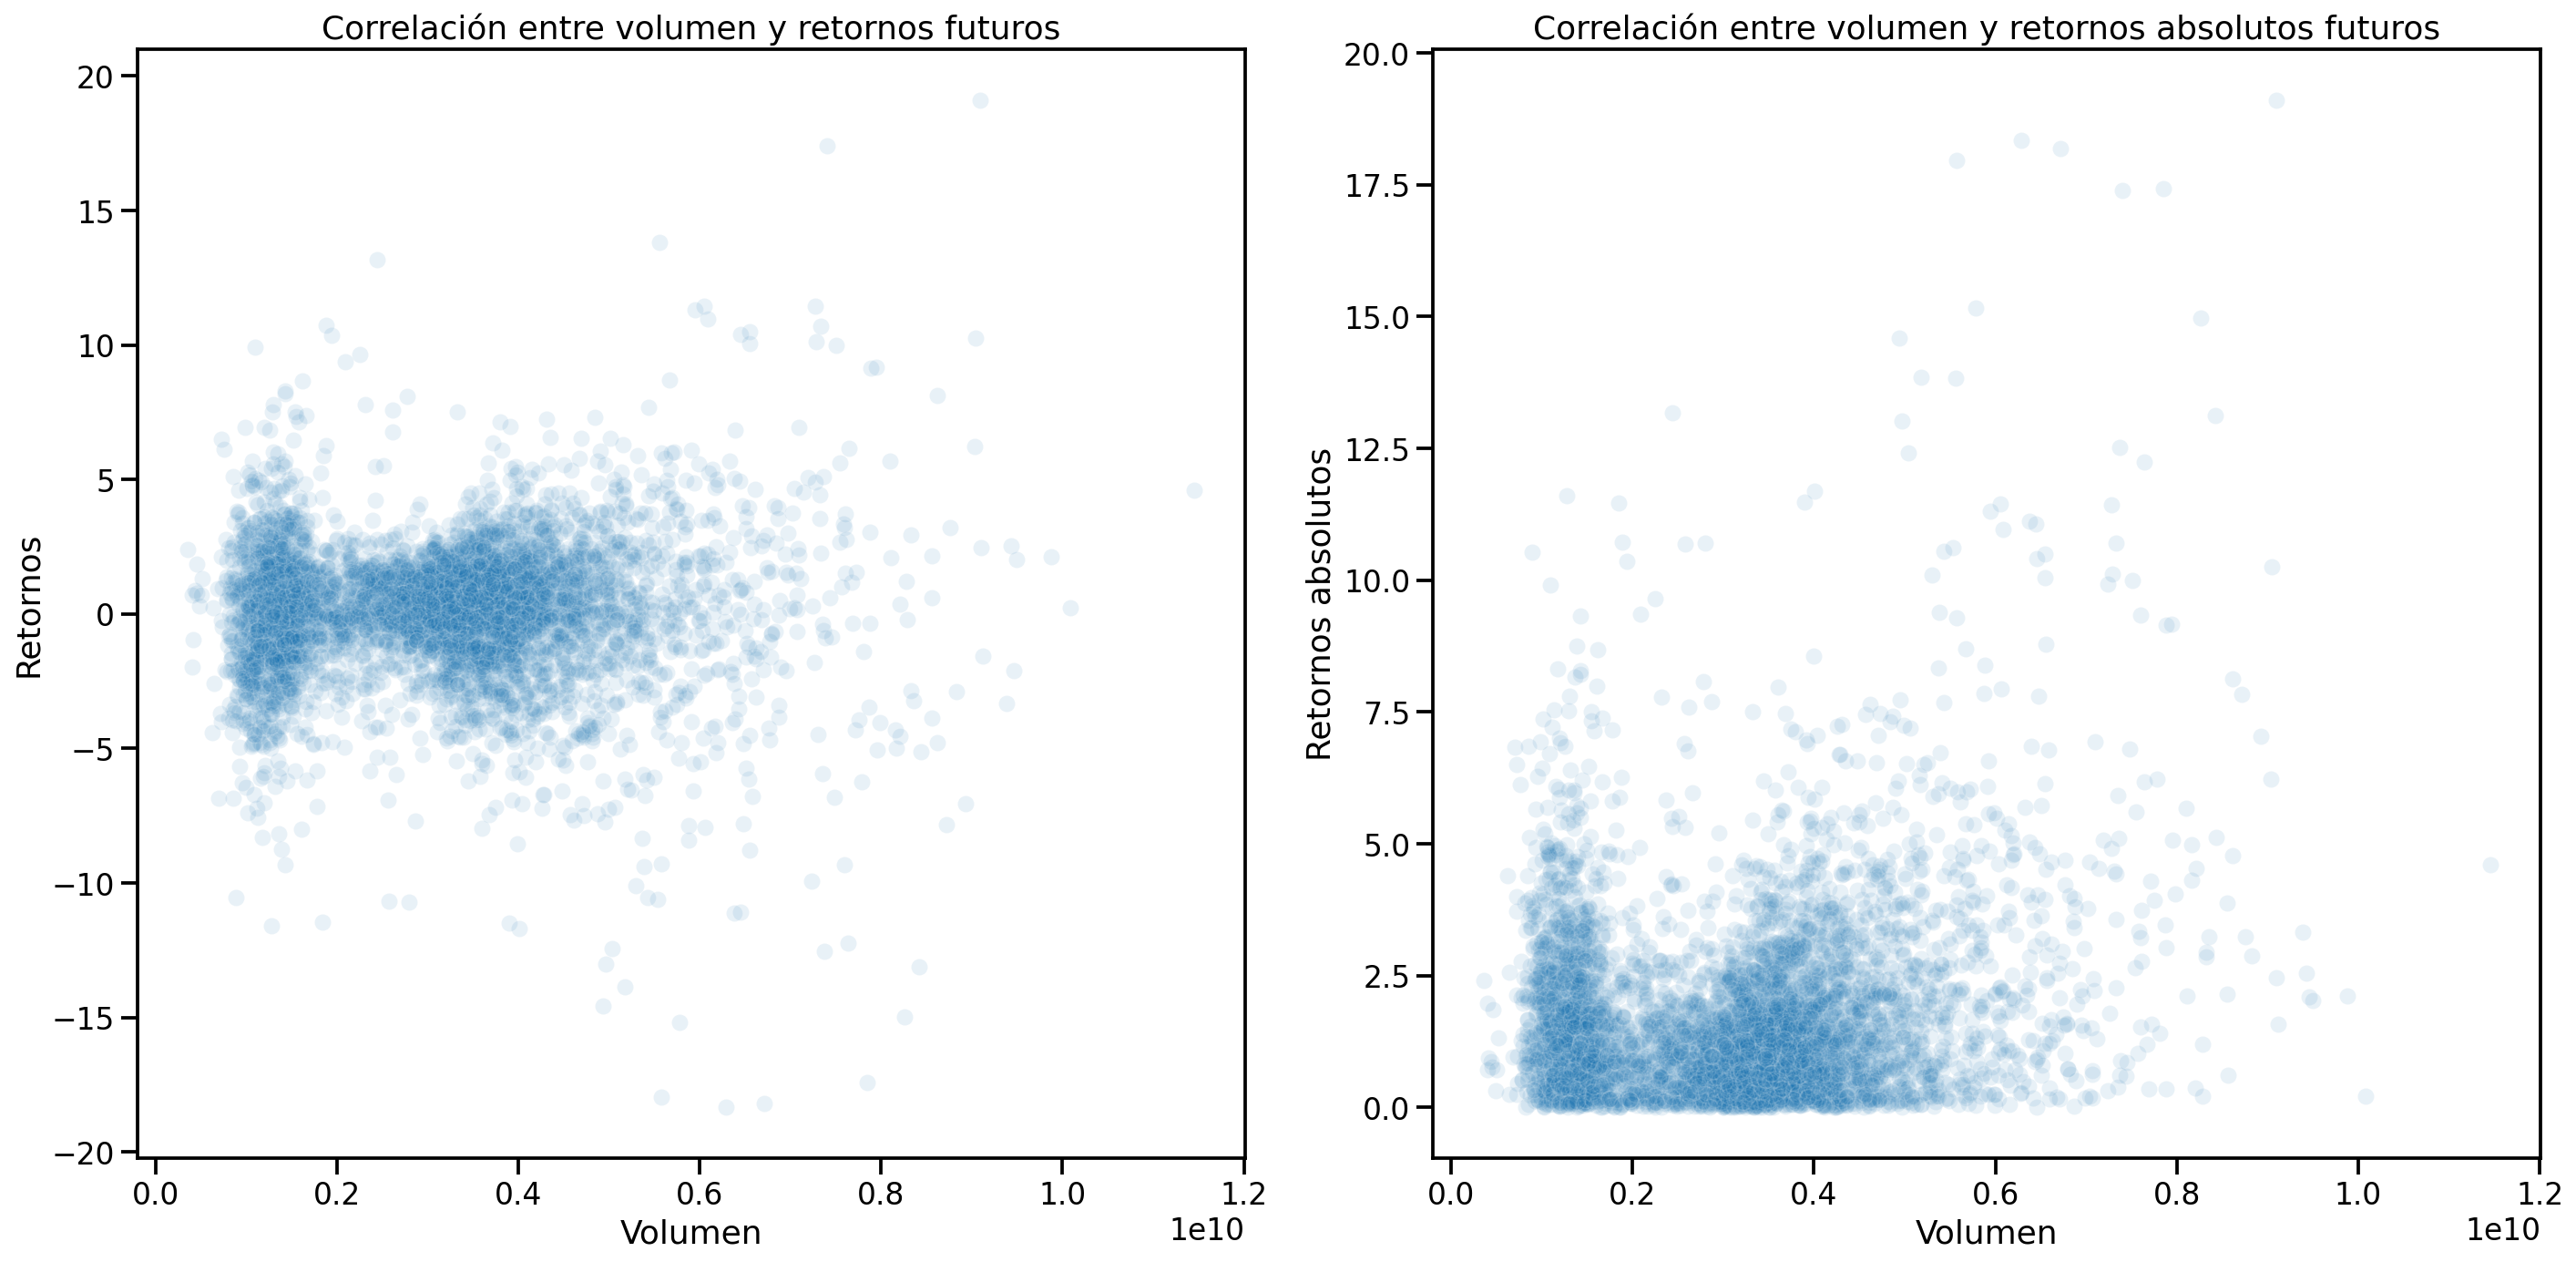

In [7]:
# correlación entre volumen, retornos y retornos absolutos, presentes y futuros
print('Correlación del volumen con otras variables:')
print(pd.DataFrame({'volume': stock_prices.volume.values,
              'returns': stock_prices.returns.values,
              'future_returns': stock_prices.future_returns.values,
              'volatility': np.abs(stock_prices.returns),
              'future_volatility': np.abs(stock_prices.future_returns)}).corr()['volume'])

# scatter plot del volumen con los retornos
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='volume', y='future_returns', data=stock_prices, alpha=0.1, ax=ax[0])
ax[0].set_title('Correlación entre volumen y retornos futuros')
ax[0].set_xlabel('Volumen')
ax[0].set_ylabel('Retornos')

# scatter plot del volumen con los retornos absolutos
sns.scatterplot(x='volume', y=np.abs(stock_prices.future_returns), data=stock_prices, alpha=0.1, ax=ax[1])
ax[1].set_title('Correlación entre volumen y retornos absolutos futuros')
ax[1].set_xlabel('Volumen')
ax[1].set_ylabel('Retornos absolutos')

save_fig('figure_2_3')
plt.show()

## 2.3. Media móvil simple (SMA)
La media móvil simple (o SMA por sus siglas en inglés) suaviza el precio actual aplicando una media aritmética con los n días anteriores. Al ser relativo al precio se espera la lógica correlación con el precio futuro que vimos con el precio actual, pero no se espera ninguna correlación entre el valor de la media y los retornos ni la tendencia, tal como se observó con el precio de cierre.

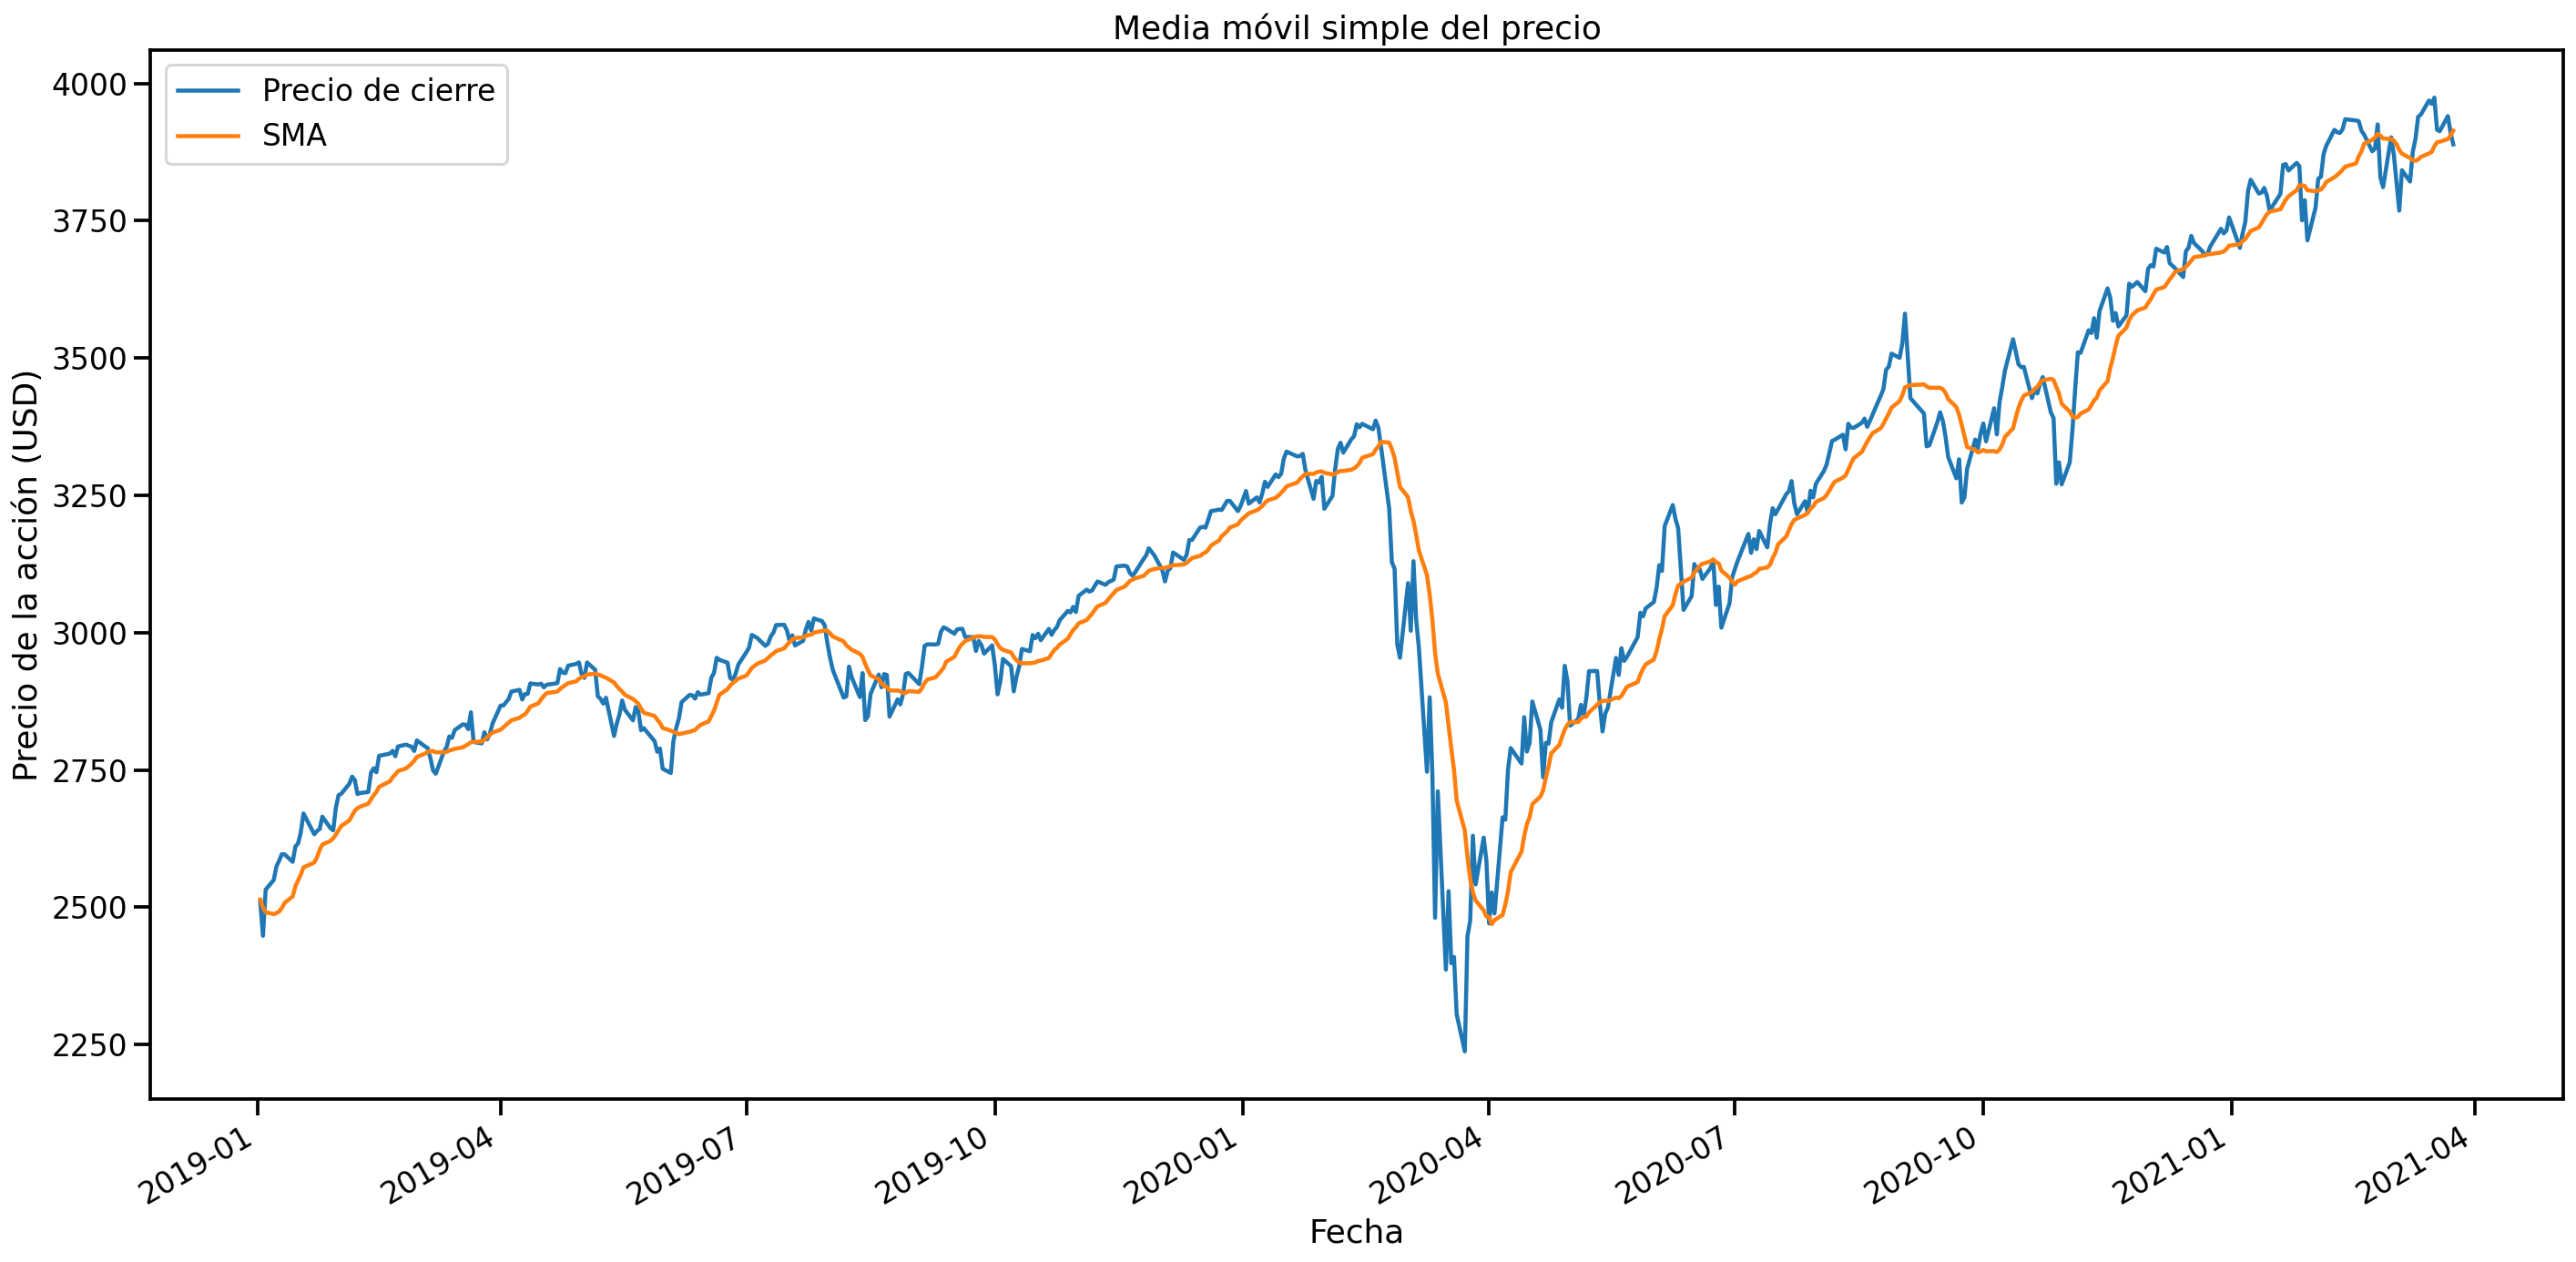

In [7]:
PERIOD = 14
# creación de la media móvil simple
stock_prices['sma'] = talib.SMA(stock_prices['close'].values, timeperiod=PERIOD)

# gráfico del precio con la media
def plot_sma(data, starting_date):
    data = data.loc[starting_date:]

    data[['close', 'sma']].plot(figsize=(20, 10))
    plt.title('Media móvil simple del precio')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de la acción (USD)')
    
    plt.legend(labels=['Precio de cierre', 'SMA'])
    save_fig('figure_2_4')
    plt.show()
plot_sma(stock_prices, '2019')

La posición del precio con respecto a la media (si está por encima o por debajo) es un valor que puede ser relevante y por lo tanto se estudia observando el comportamiento de los retornos y la tendencia futuros en función de éste. Primero se observa si la tendencia es distinta según el precio esté por encima o por debajo de la media. Después si la distribución de los retornos futuros cambia.

---------- Métricas SMA ----------
Precio sobre la SMA
frecuencia relativa:	 60.30%
porcentaje alcista:	 57.13%
porcentaje bajista:	 42.87%
porcentaje de largos:	 13.88%
porcentaje de cortos:	 14.32%
media retornos futuros:	 0.0626% 

Precio por debajo de la SMA
frecuencia relativa:	 39.70%
porcentaje alcista:	 56.35%
porcentaje bajista:	 43.65%
porcentaje de largos:	 27.73%
porcentaje de cortos:	 20.47%
media retornos futuros:	 0.2235% 



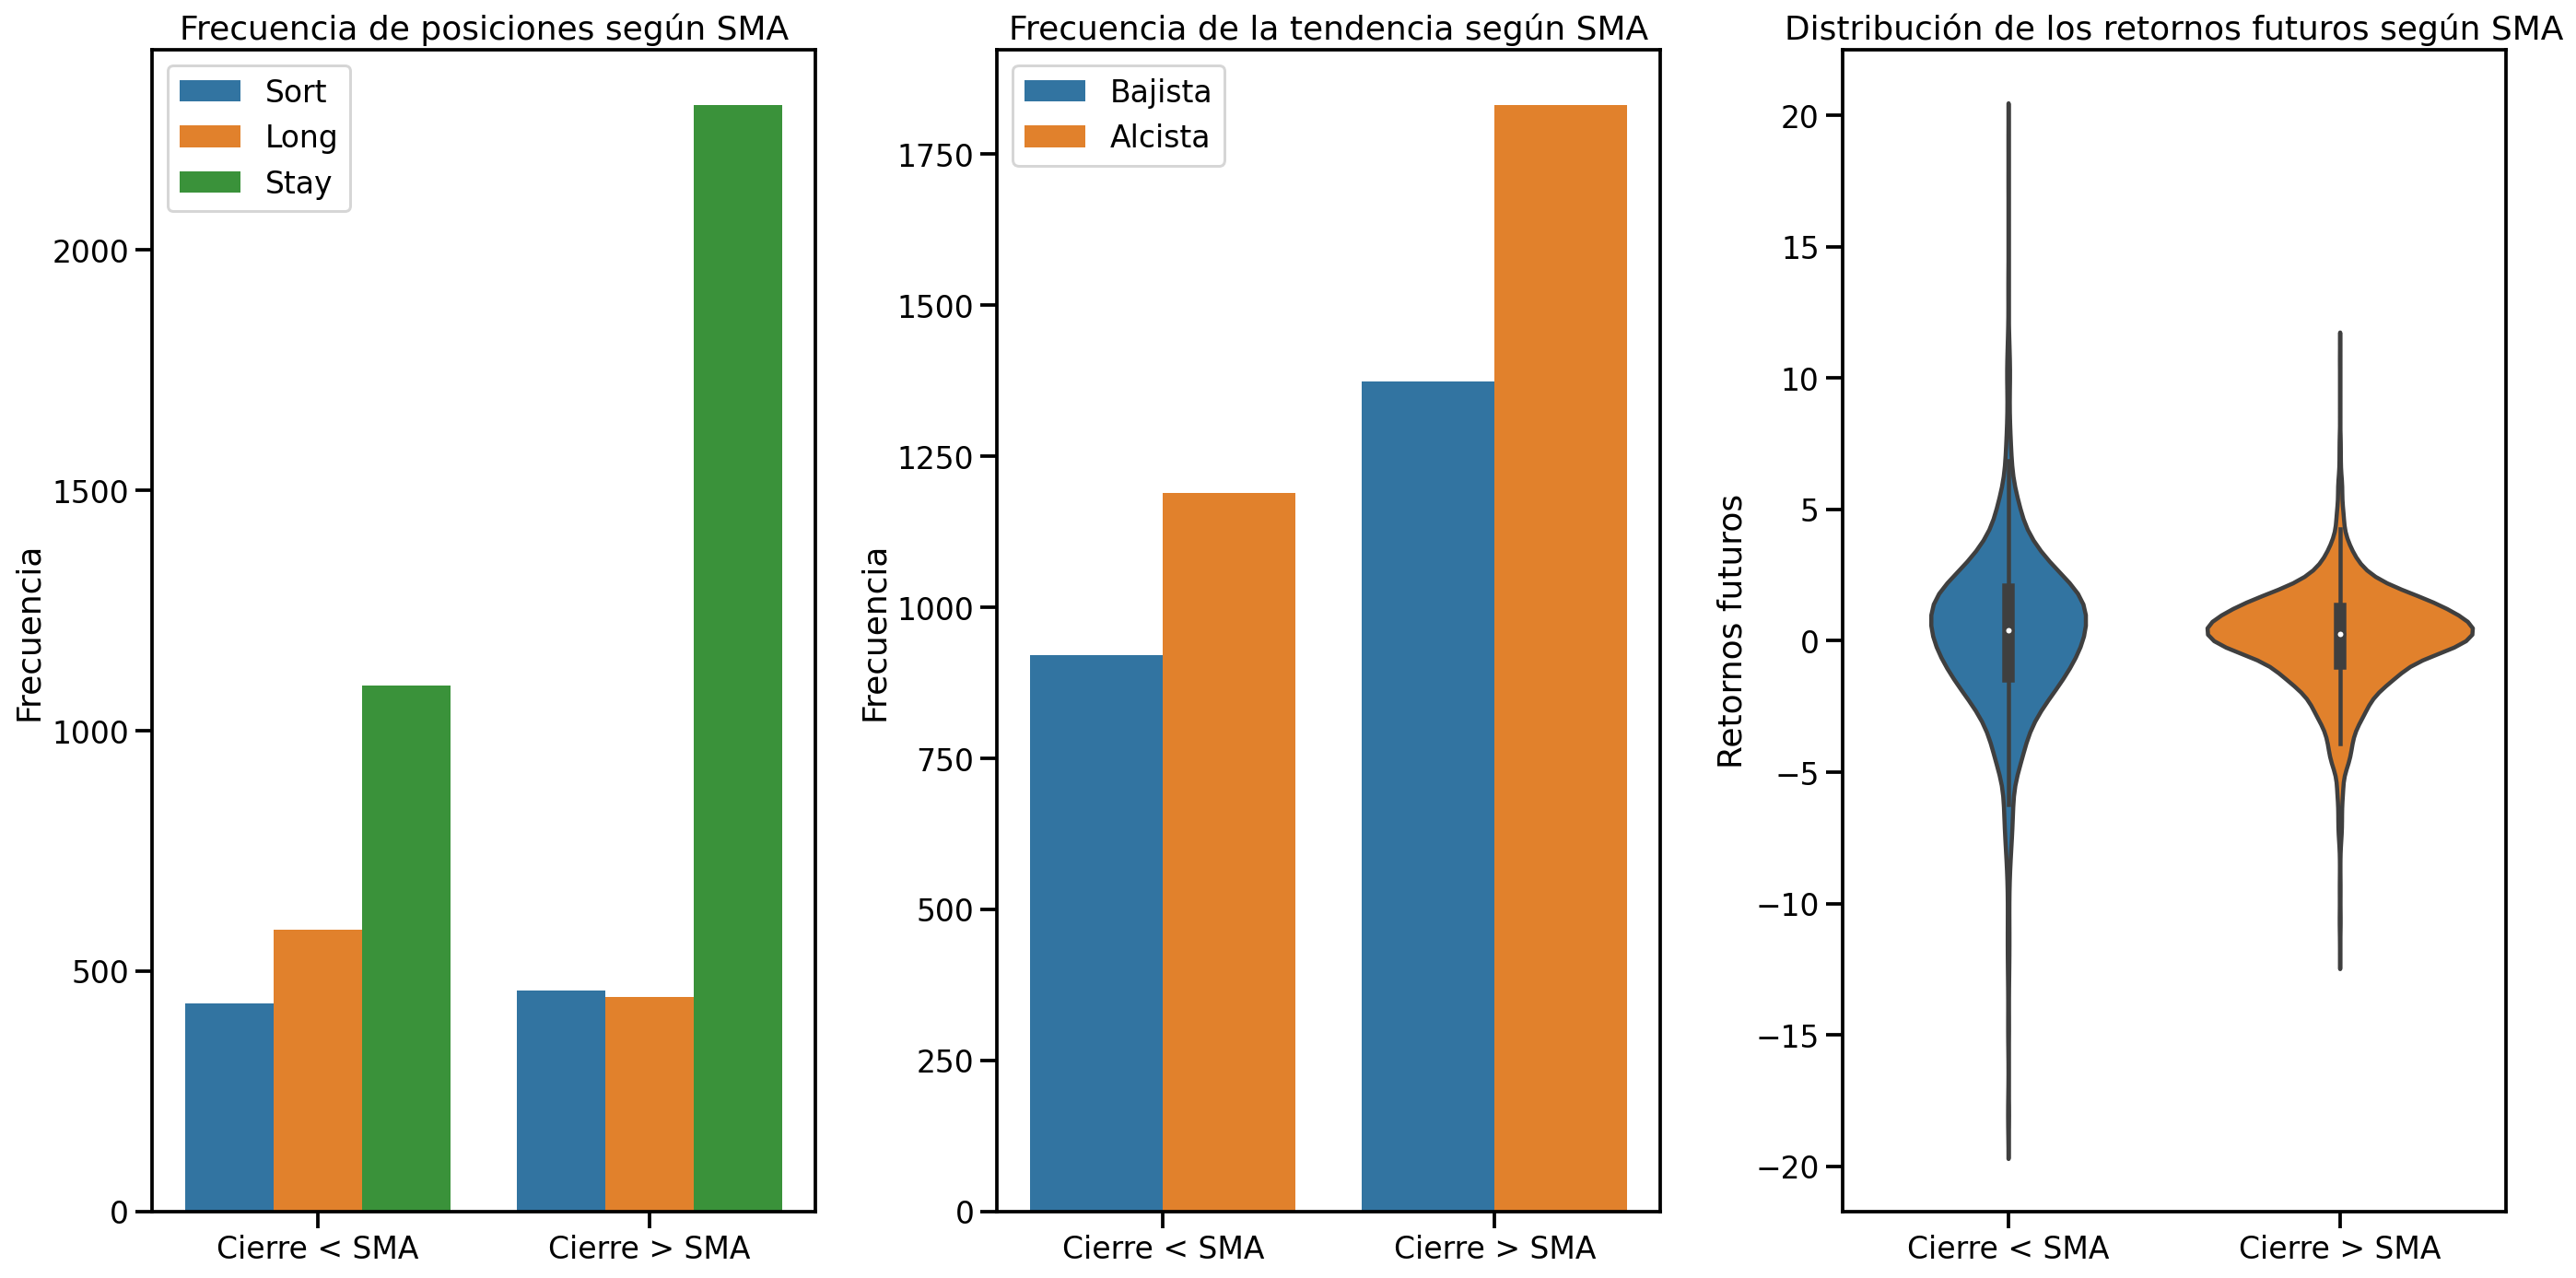

In [64]:
# obtener variable que indica si el precio está por encima de la media
stock_prices['above_sma'] = (stock_prices['close'] >= stock_prices['sma']).astype('int')

relative_frecuency = stock_prices.above_sma.value_counts() / len(stock_prices.above_sma)
above_sma_trend_frequency = stock_prices[stock_prices.above_sma == 1].future_bullish.value_counts() / np.sum(stock_prices.above_sma == 1)
below_sma_trend_frequency = stock_prices[stock_prices.above_sma == 0].future_bullish.value_counts() / np.sum(stock_prices.above_sma == 0)
above_sma_position_frequency = stock_prices[stock_prices.above_sma == 1].future_position.value_counts() / np.sum(stock_prices.above_sma == 1)
below_sma_position_frequency = stock_prices[stock_prices.above_sma == 0].future_position.value_counts() / np.sum(stock_prices.above_sma == 0)


#estadísticas de los retornos por encima y por debajo de la sma
print('---------- Métricas SMA ----------')
print('Precio sobre la SMA')
print('frecuencia relativa:\t', '{0:.2%}'.format(relative_frecuency[1]))
print('porcentaje alcista:\t', '{0:.2%}'.format(above_sma_trend_frequency[1]))
print('porcentaje bajista:\t', '{0:.2%}'.format(above_sma_trend_frequency[0]))
print('porcentaje de largos:\t', '{0:.2%}'.format(above_sma_position_frequency[1]))
print('porcentaje de cortos:\t', '{0:.2%}'.format(above_sma_position_frequency[0]))
print('media retornos futuros:\t', '{0:.4f}%'.format(stock_prices.loc[stock_prices.above_sma == 1, 'future_returns'].mean()), '\n')
print('Precio por debajo de la SMA')
print('frecuencia relativa:\t', '{0:.2%}'.format(relative_frecuency[0]))
print('porcentaje alcista:\t', '{0:.2%}'.format(below_sma_trend_frequency[1]))
print('porcentaje bajista:\t', '{0:.2%}'.format(below_sma_trend_frequency[0]))
print('porcentaje de largos:\t', '{0:.2%}'.format(below_sma_position_frequency[1]))
print('porcentaje de cortos:\t', '{0:.2%}'.format(below_sma_position_frequency[0]))
print('media retornos futuros:\t', '{0:.4f}%'.format(stock_prices.loc[stock_prices.above_sma == 0, 'future_returns'].mean()), '\n')


# gráfica de la frecuencia de posiciones en función de 'above_sma'
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(131)
sns.countplot(x='above_sma', data=stock_prices, hue='future_position')
ax1.set(title='Frecuencia de posiciones según SMA', ylabel='Frecuencia', xlabel='')
ax1.legend(labels=['Sort', 'Long', 'Stay'])
plt.xticks([0, 1], ['Cierre < SMA', 'Cierre > SMA'])

# gráfica de la frecuencia de subida y bajada en función de 'above_sma'
ax2 = plt.subplot(132)
sns.countplot(x='above_sma', data=stock_prices, hue='future_bullish')
ax2.set(title='Frecuencia de la tendencia según SMA', ylabel='Frecuencia', xlabel='')
ax2.legend(labels=['Bajista', 'Alcista'])
plt.xticks([0, 1], ['Cierre < SMA', 'Cierre > SMA'])

# gráfica de la distribución en swarmplot de los retornos en función de 'above_sma'
ax3 = plt.subplot(133)
sns.violinplot(x='above_sma', y='future_returns', data=stock_prices)
ax3.set(title='Distribución de los retornos futuros según SMA', xlabel='', ylabel='Retornos futuros')
plt.xticks([0, 1], ['Cierre < SMA', 'Cierre > SMA'])

save_fig('figure_2_5')
plt.show()


### Contraste de hipótesis
Se realiza la prueba U de Mann-Whitney para comprobar la hipótesis de que las distribuciones de los retornos futuros cambia en función de si el precio está por encima o por debajo de la media.

In [65]:
# hypothesis testing: la distribución de los retornos es distinta encima de la media que debajo
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices.above_sma == 1, 'future_returns'], stock_prices.loc[stock_prices.above_sma == 0, 'future_returns'])
print(f'Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

Estadístico de la prueba Mann-Whitney U: 3186935.00 con valor p: 0.00


## 2.4. RSI
El indicador RSI (Relative Strength Index) mide la fuerza de la tendencia que lleva el precio, en un rango de 0 a 100. Tiene límites que marcan sobrecompra (nivel mayor que 70) y sobreventa (nivel menor que 30).

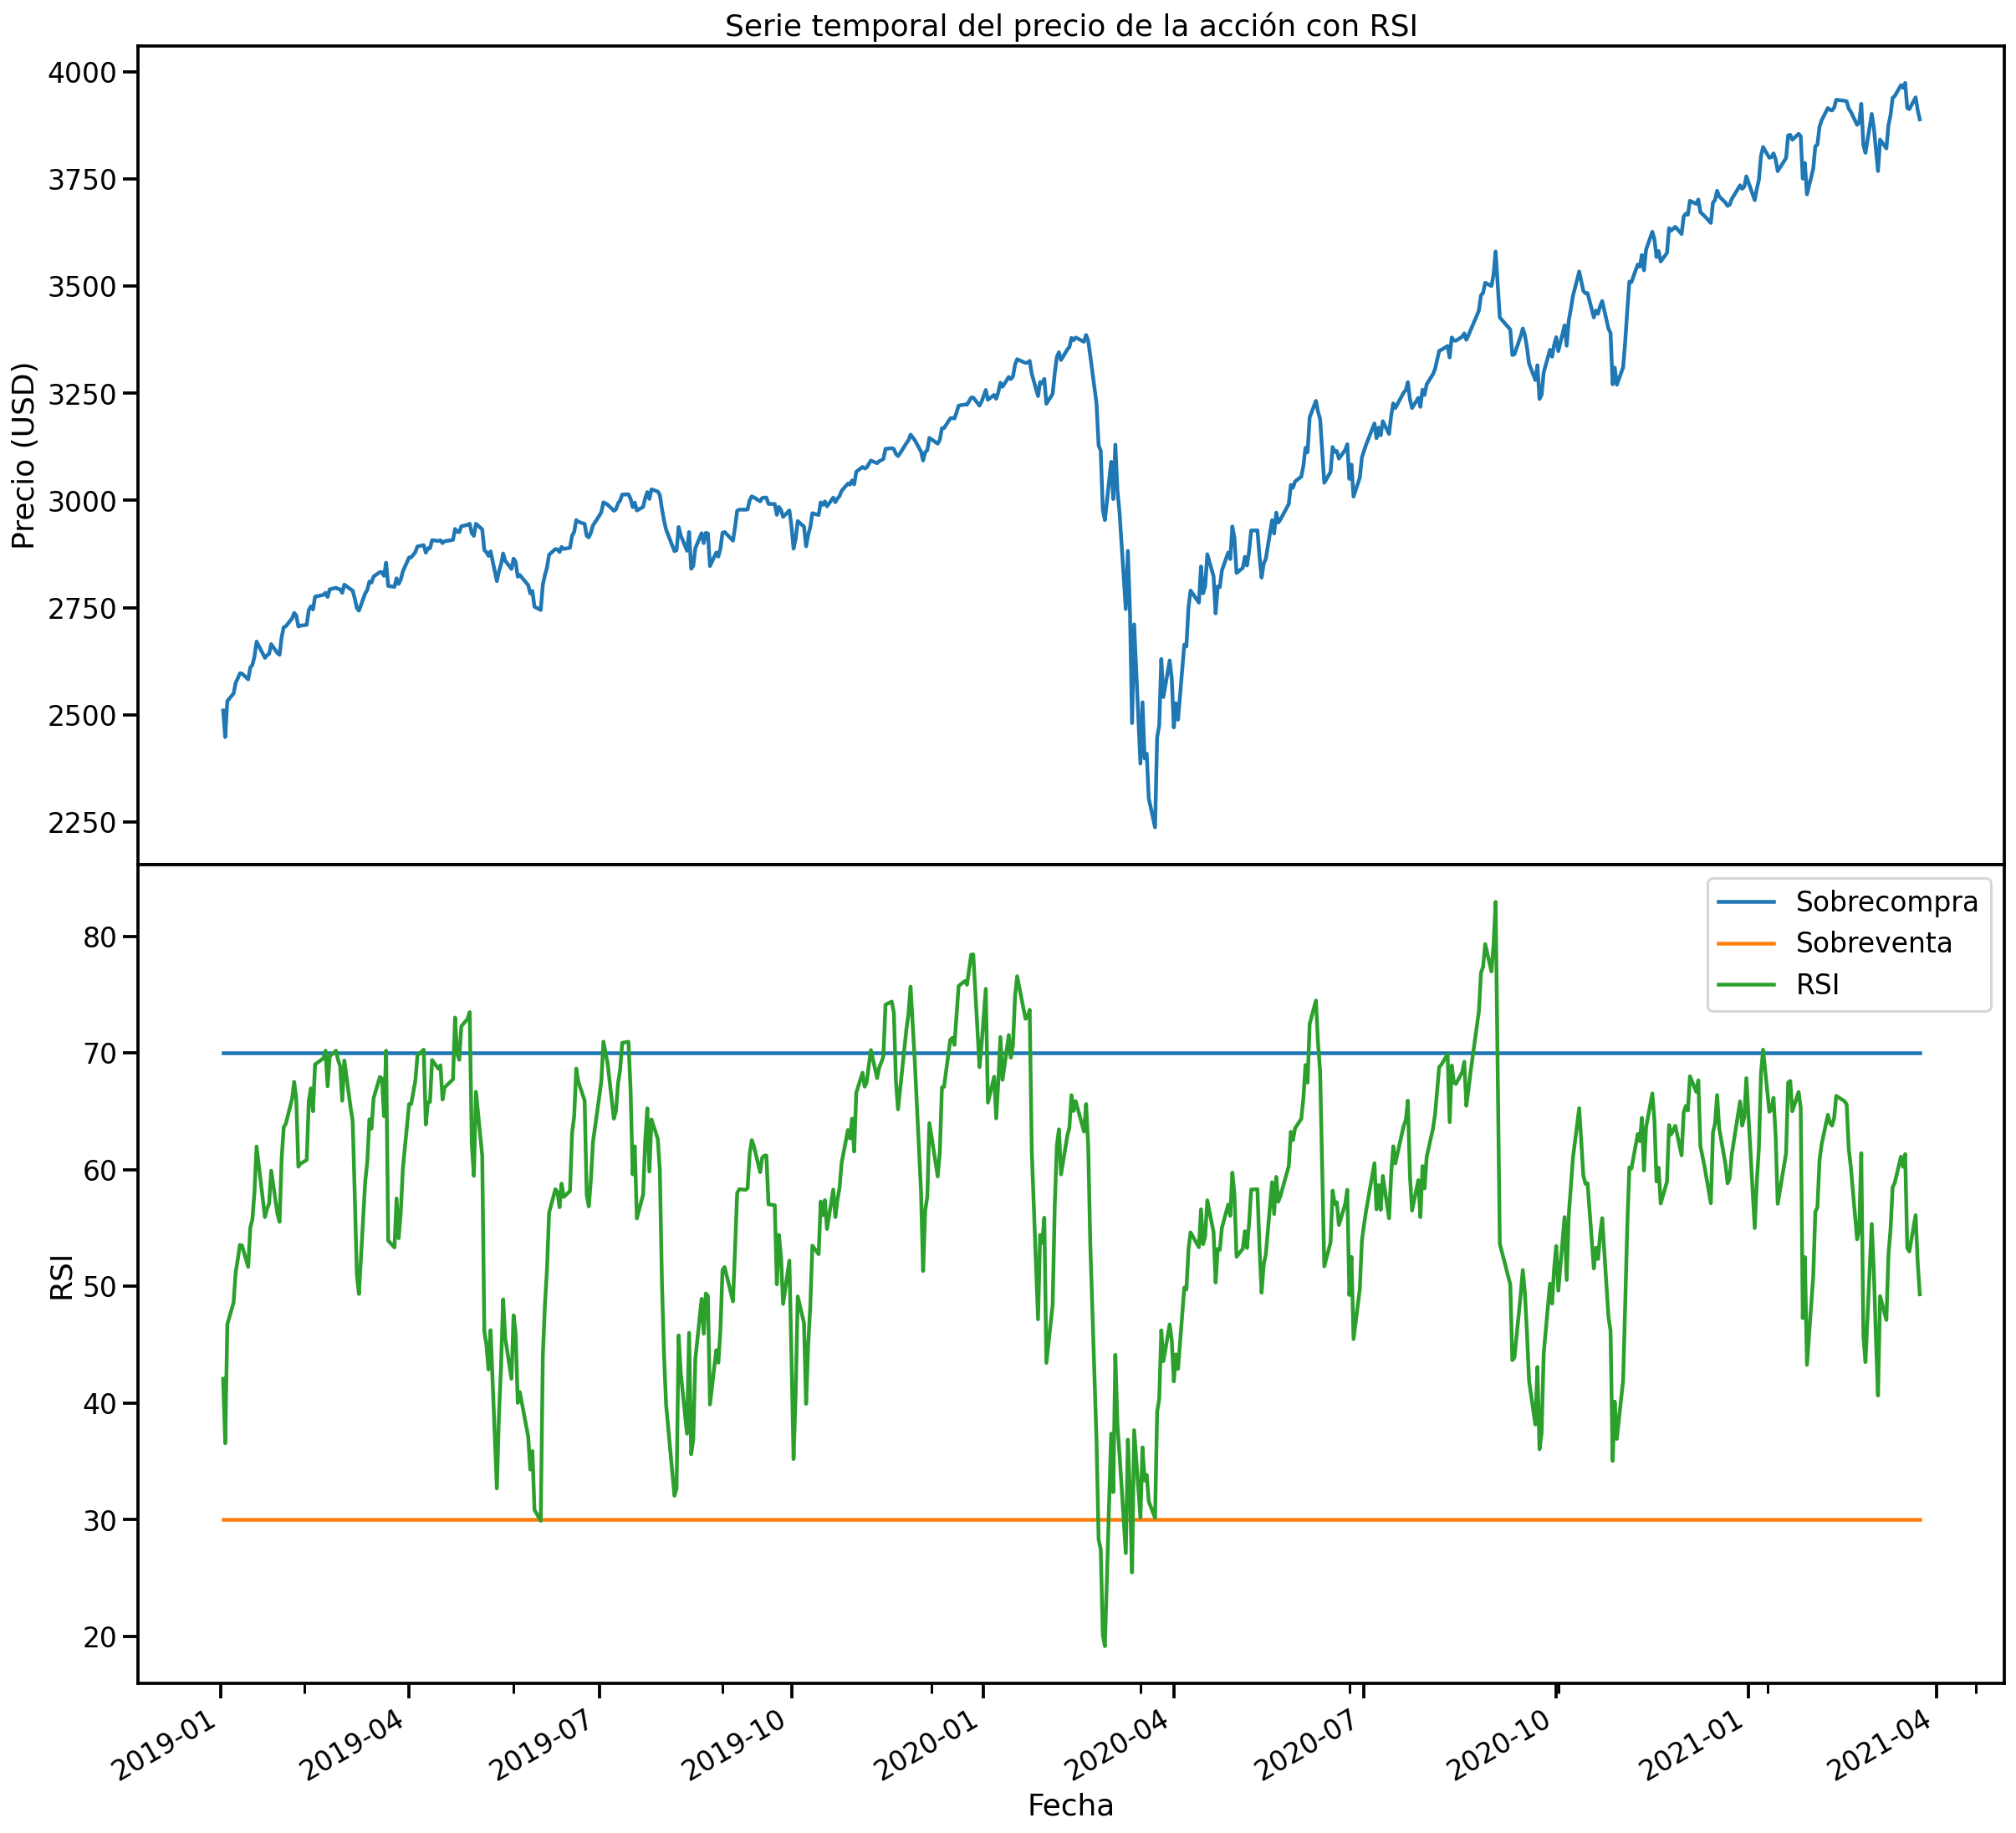

In [10]:
PERIOD = 14
# obtener RSI
stock_prices['rsi'] = talib.RSI(stock_prices['close'].values, timeperiod=PERIOD)

# gráfico del RSI con el precio
def plot_rsi(data, starting_date):
    data = data.loc[starting_date:]

    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    data['close'].plot(ax=ax[0])
    ax[0].set(title='Serie temporal del precio de la acción con RSI', ylabel='Precio (USD)')

    ax[1].plot(data.index, [70] * len(data.index), label="Sobrecompra")
    ax[1].plot(data.index, [30] * len(data.index), label="Sobreventa")
    data['rsi'].plot(ax=ax[1], label='RSI')
    ax[1].set(ylabel='RSI', xlabel='Fecha')
    ax[1].legend()

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_6', tight_layout=False)
    plt.show()
    
plot_rsi(stock_prices, '2019')

Se estudia el poder de predicción del RSI analizando los cruces históricos con las líneas de sobrecompra y sobreventa, para probar la teoría de los cambios de tendencia en estas zonas.

------------ Métricas RSI ------------
Zona de sobrecompra:
	Número de observaciones: 308
	Frecuencia de la tendencia futura:
		Alcista:	 54.87%
		Bajista:	 45.13%
	Frecuencia de la posición futura:
		Largos:		 3.90%
		Cortos:		 8.77%

Zona de sobrecompra:
	Número de observaciones: 106
	Frecuencia de tendencia futura
		Alcista:	 64.15%
		Bajista:	 35.85%
	Frecuencia de posición futura
		Largos:		 43.40%
		Cortos:		 21.70%

Precisión en cambio de tendencia: 67.59%


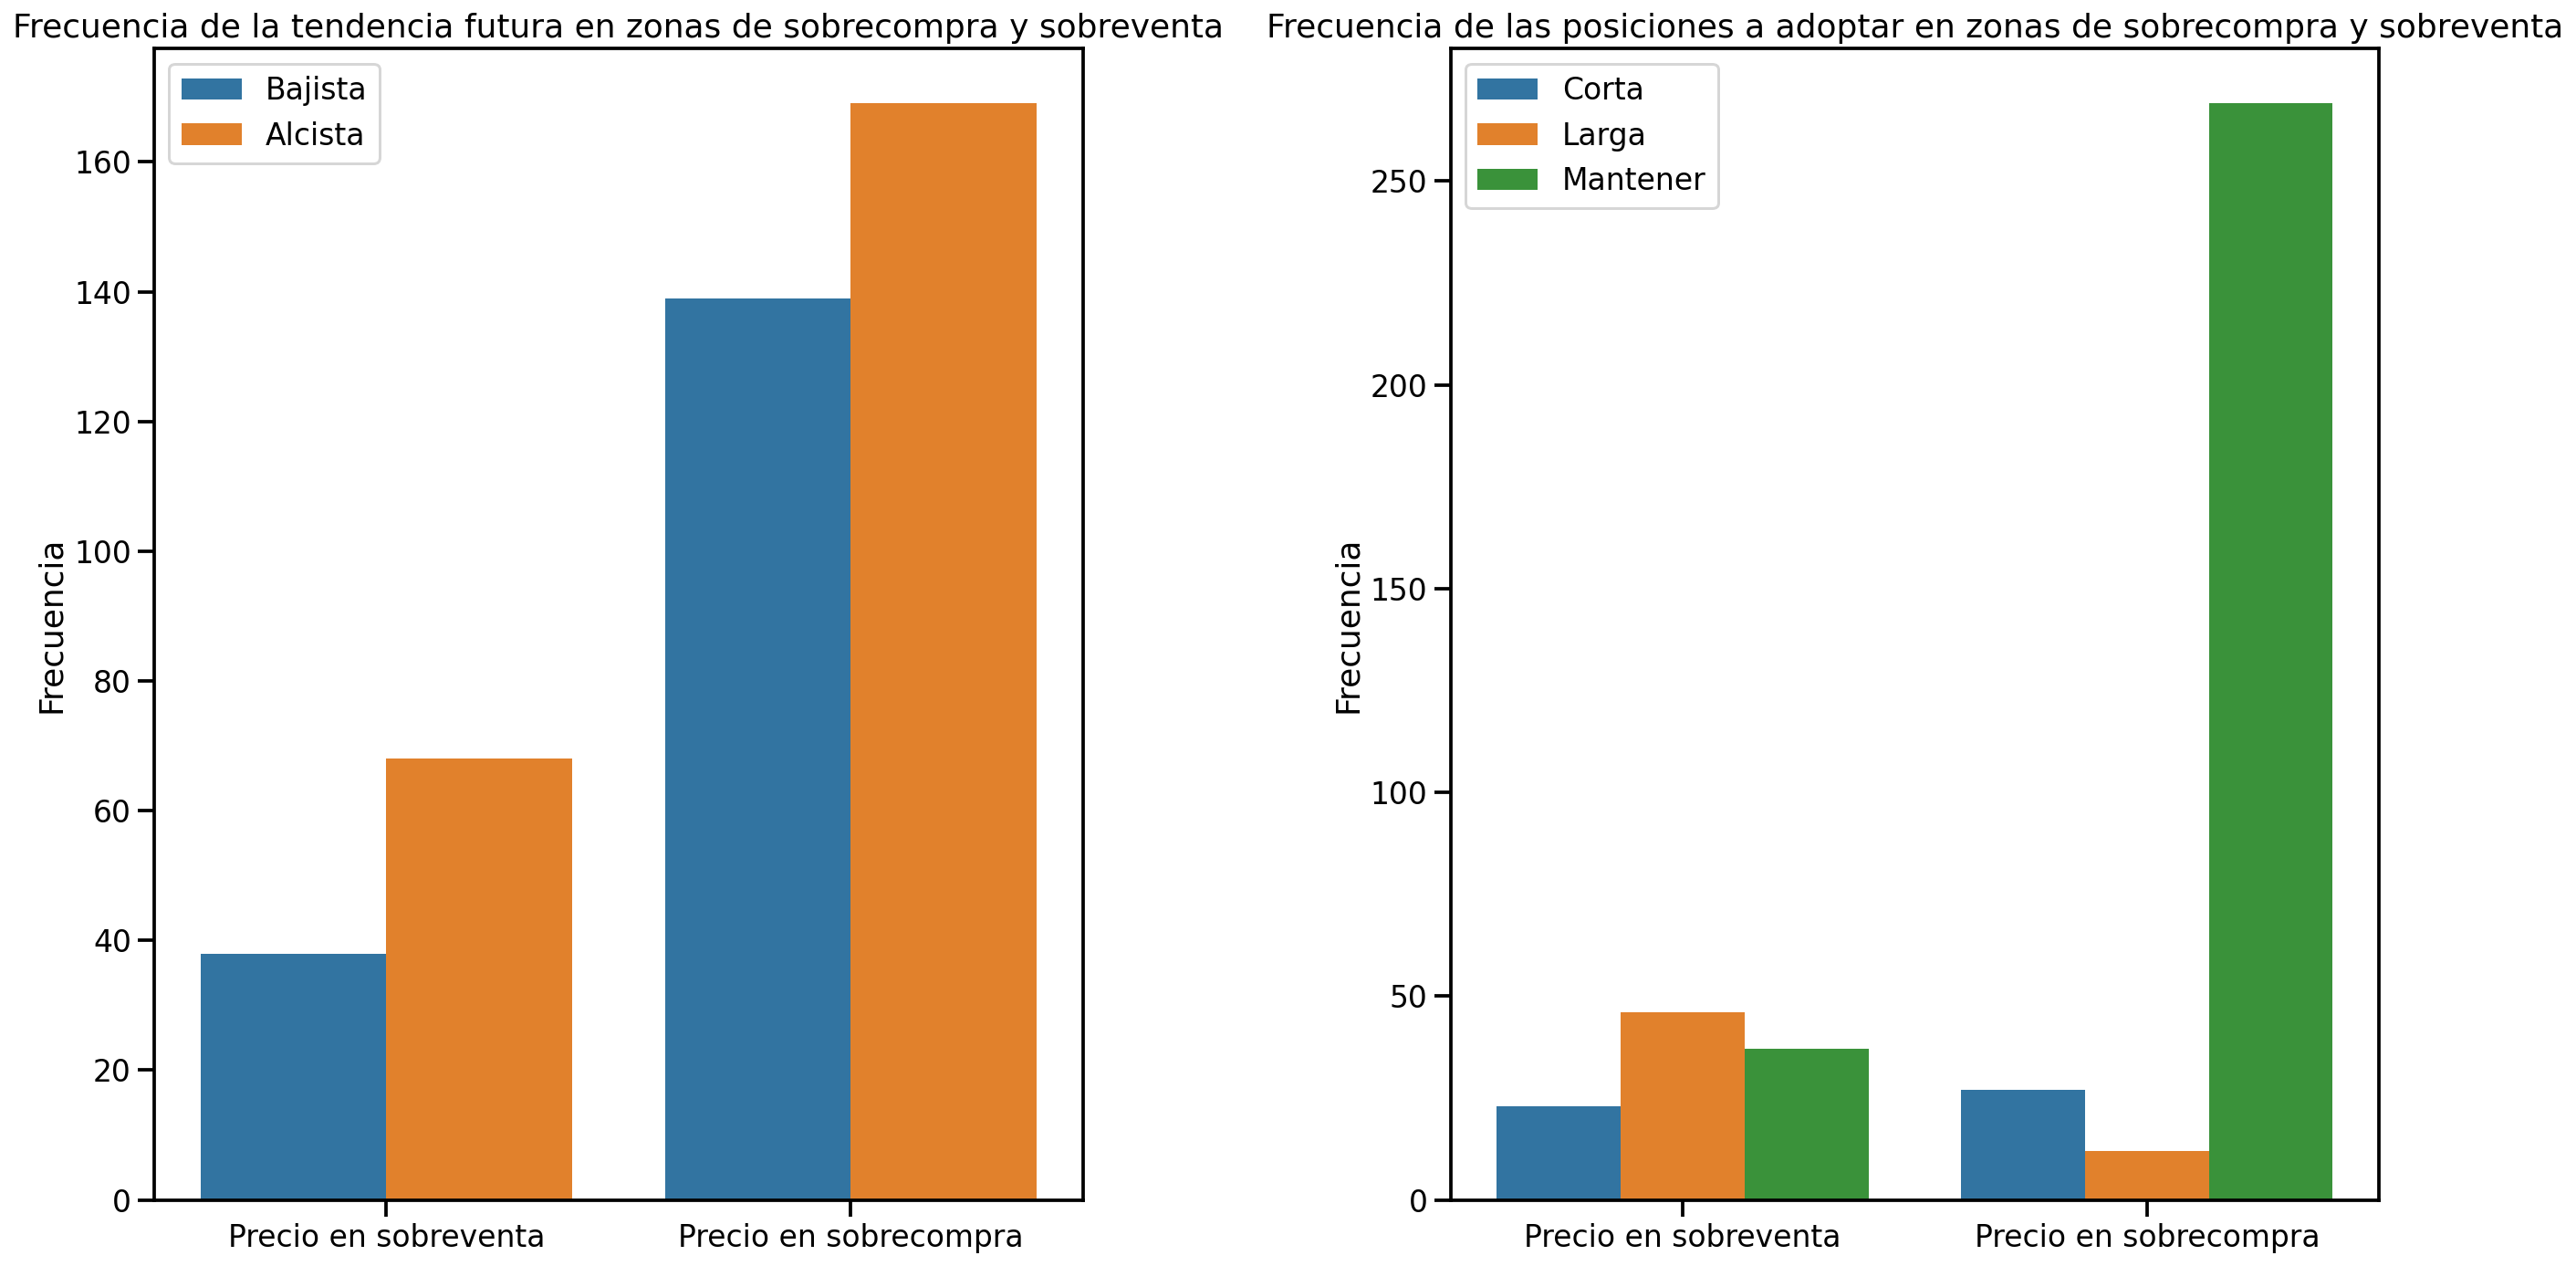

In [75]:
# obtener observaciones en las que hay sobrecompra o sobreventa
overbought = stock_prices[stock_prices['rsi'] >= 70]
oversold = stock_prices[stock_prices['rsi'] <= 30]

# Mediciones del RSI
print('------------ Métricas RSI ------------')
print('Zona de sobrecompra:')
print('\tNúmero de observaciones:', len(overbought))
print('\tFrecuencia de la tendencia futura:')
print('\t\tAlcista:\t', '{0:.2%}'.format(overbought.future_bullish.value_counts()[1]/len(overbought.future_bullish)))
print('\t\tBajista:\t', '{0:.2%}'.format(overbought.future_bullish.value_counts()[0]/len(overbought.future_bullish)))
print('\tFrecuencia de la posición futura:')
print('\t\tLargos:\t\t', '{0:.2%}'.format(overbought.future_position.value_counts()[1]/len(overbought.future_position)))
print('\t\tCortos:\t\t', '{0:.2%}'.format(overbought.future_position.value_counts()[0]/len(overbought.future_position)))

print('\nZona de sobrecompra:')
print('\tNúmero de observaciones:', len(oversold))
print('\tFrecuencia de tendencia futura')
print('\t\tAlcista:\t', '{0:.2%}'.format(oversold.future_bullish.value_counts()[1]/len(oversold.future_bullish)))
print('\t\tBajista:\t', '{0:.2%}'.format(oversold.future_bullish.value_counts()[0]/len(oversold.future_bullish)))
print('\tFrecuencia de posición futura')
print('\t\tLargos:\t\t', '{0:.2%}'.format(oversold.future_position.value_counts()[1]/len(oversold.future_position)))
print('\t\tCortos:\t\t', '{0:.2%}'.format(oversold.future_position.value_counts()[0]/len(oversold.future_position)))

print('\nPrecisión en cambio de tendencia:', '{0:.2%}'.format((overbought.future_position.value_counts()[0] + oversold.future_position.value_counts()[1]) / ((overbought.future_position != 2).sum() + (oversold.future_position != 2).sum())))

overbought_df = pd.concat([stock_prices, (stock_prices['rsi'] >= 70).rename('overbought')], axis=1)[(stock_prices['rsi'] >= 70) | (stock_prices['rsi'] <= 30)]

#grafica de la frecuencia de dirección de la tendencia en zonas de sobrecompra y sobreventa
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
sns.countplot(x='overbought', data=overbought_df, hue='future_bullish')
ax1.set(title='Frecuencia de la tendencia futura en zonas de sobrecompra y sobreventa', ylabel='Frecuencia', xlabel='')
plt.xticks([False, True], ['Precio en sobreventa', 'Precio en sobrecompra'])
ax1.legend(labels=['Bajista', 'Alcista'])

#grafica de la frecuencia de posiciones en zonas de sobrecompra y sobreventa
ax2 = plt.subplot(122)
sns.countplot(x='overbought', data=overbought_df, hue='future_position')
ax2.set(title='Frecuencia de las posiciones a adoptar en zonas de sobrecompra y sobreventa', ylabel='Frecuencia', xlabel='')
plt.xticks([False, True], ['Precio en sobreventa', 'Precio en sobrecompra'])
ax2.legend(labels=['Corta', 'Larga', 'Mantener'])

save_fig('figure_2_7')
plt.show()


### Contraste de hipótesis
Se realiza la prueba U de Mann-Whitney para comprobar las siguientes hipótesis:

1. La distribución de los retornos futuros cuando el precio está en área de sobrecompra es distinta a cuando no está.

2. La distribución de los retornos futuros cuando el precio está en área de sobeventa es distinta a cuando no está.

In [66]:
# Hypothesis testing: las distribuciones de retornos son diferentes en sobrecompra
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices['rsi'] >= 70, 'future_returns'], stock_prices.loc[stock_prices['rsi'] < 70, 'future_returns'])
print(f'1. Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

# Hypothesis testing: las distribuciones de retornos son diferentes en sobreventa
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices['rsi'] <= 30, 'future_returns'], stock_prices.loc[stock_prices['rsi'] > 30, 'future_returns'])
print(f'2. Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

1. Estadístico de la prueba Mann-Whitney U: 699056.00 con valor p: 0.00
2. Estadístico de la prueba Mann-Whitney U: 222553.00 con valor p: 0.00


## 2.5. MACD

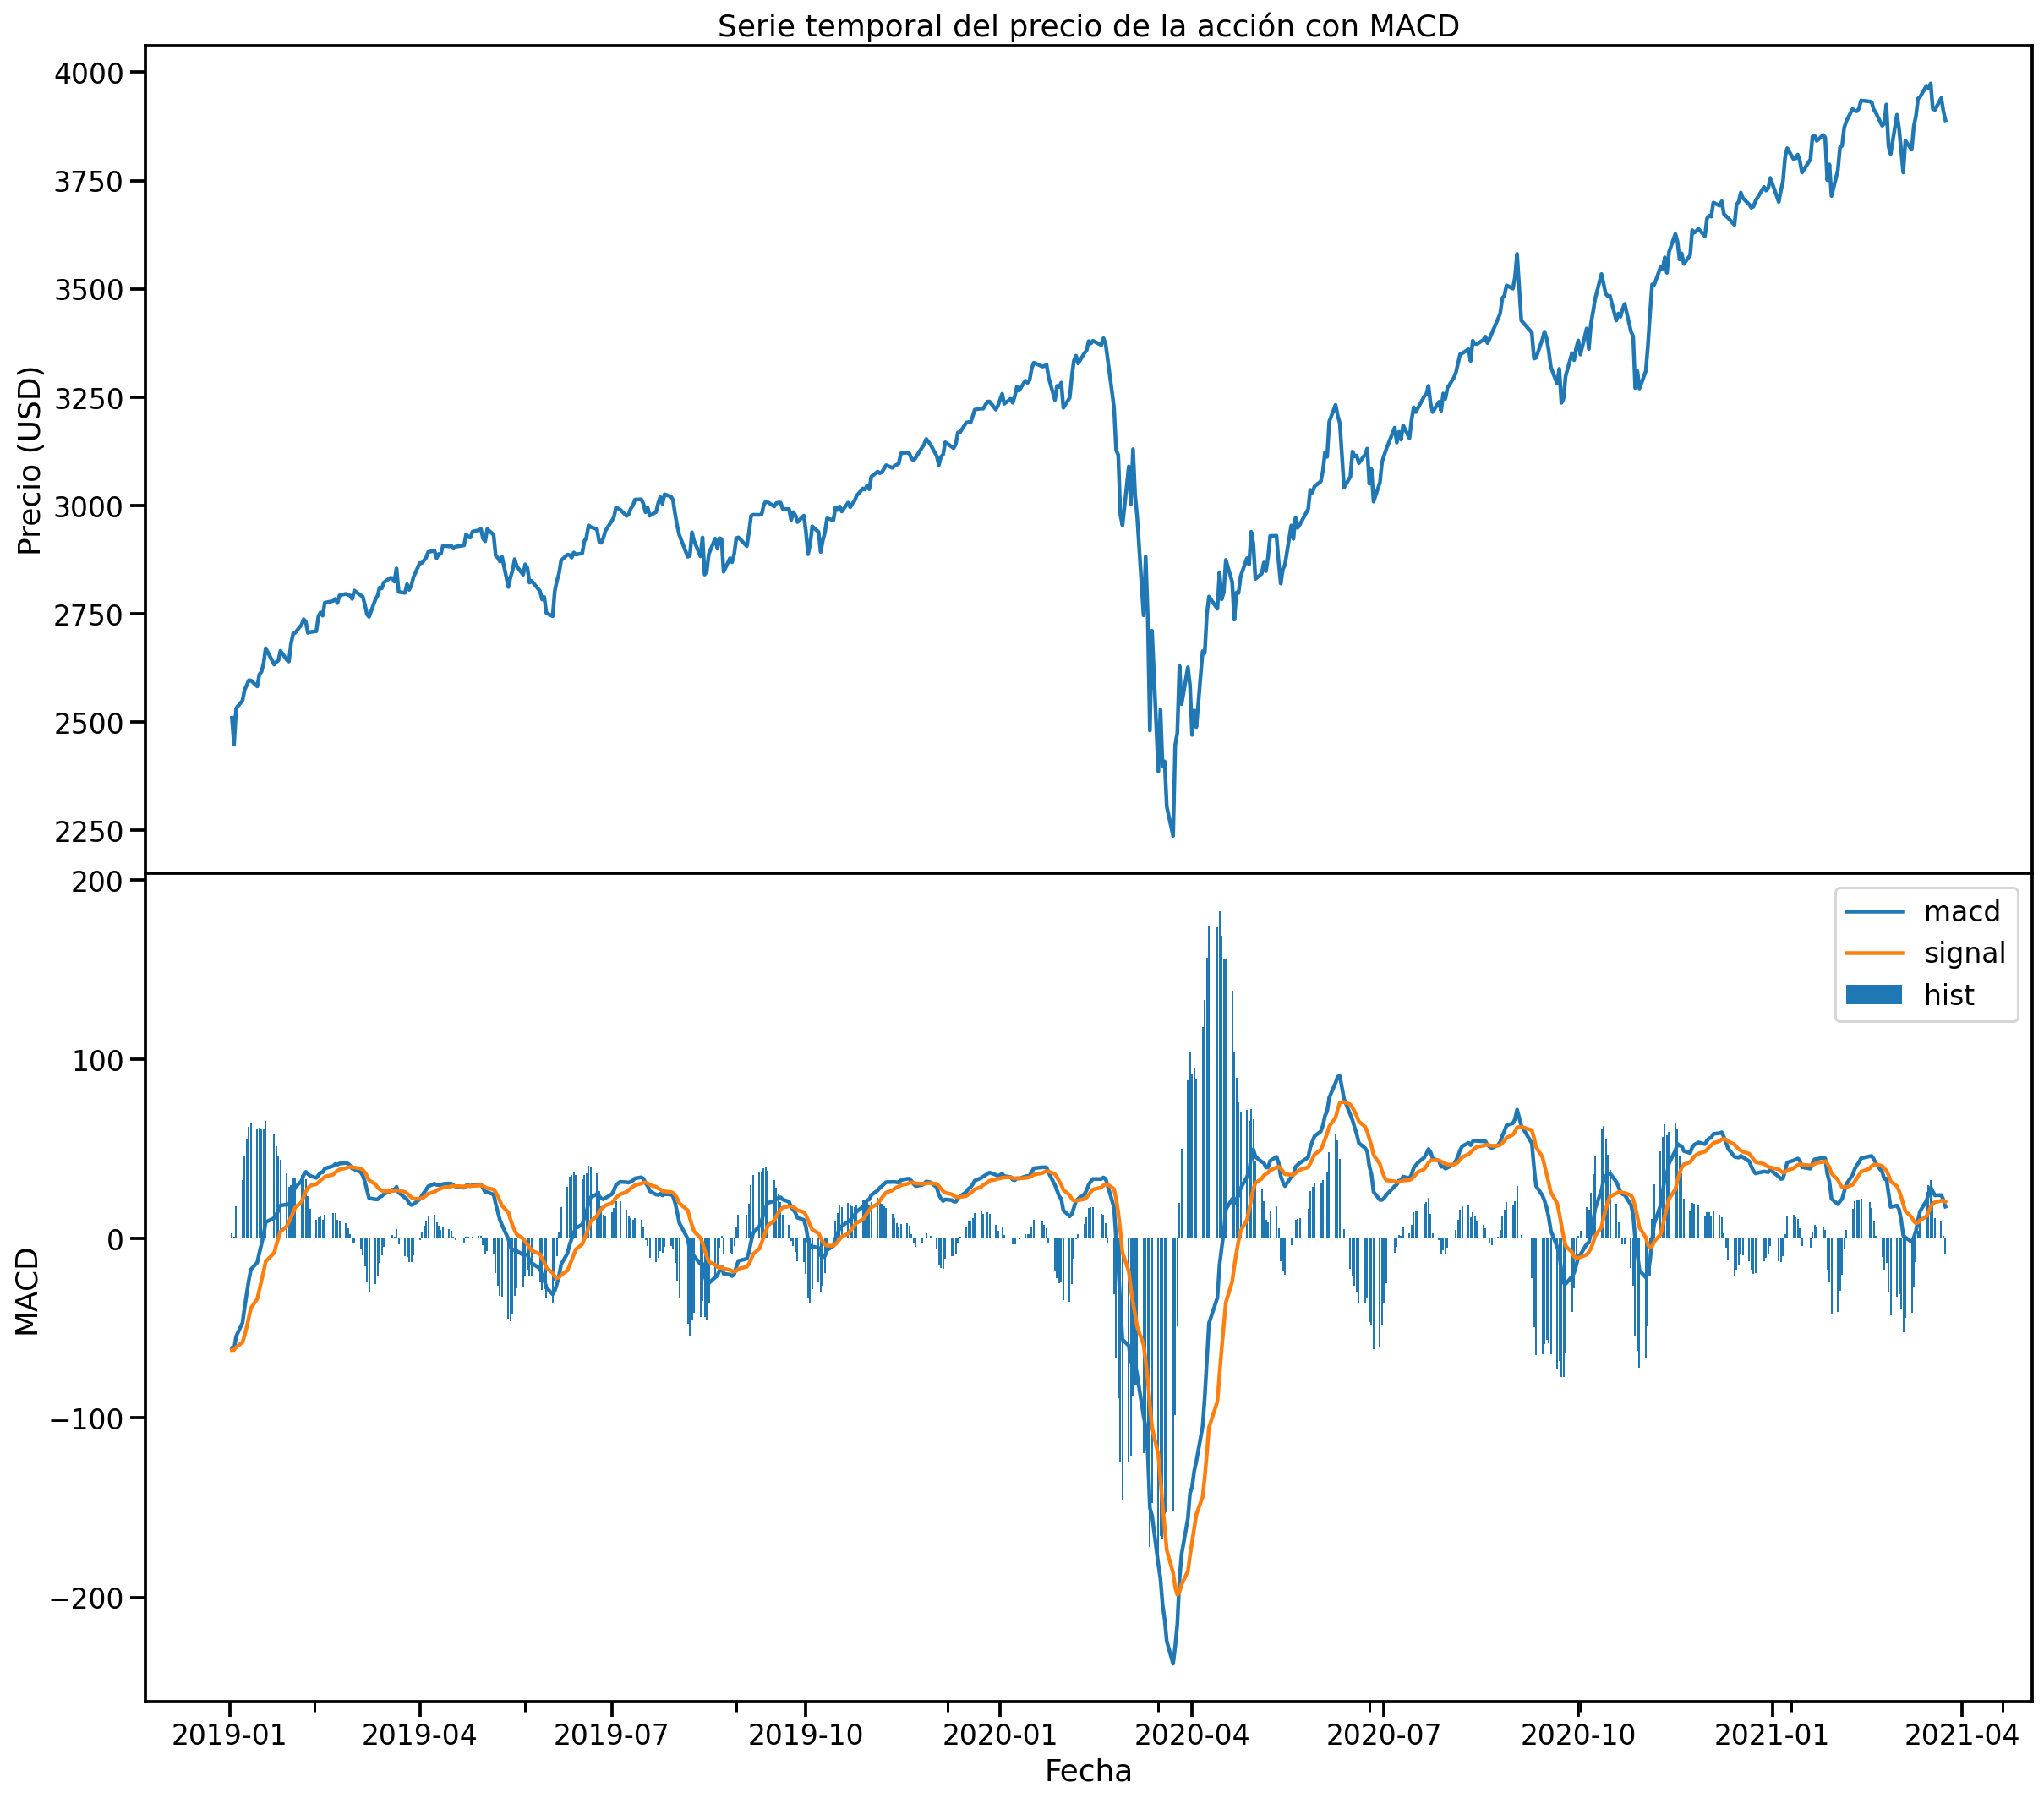

In [13]:
# obtener el MACD
stock_prices["macd"], stock_prices["macd_signal"], stock_prices["macd_hist"] = talib.MACD(stock_prices['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# gráfica del MACD con el precio
def plot_macd(data, starting_date):
    data = data.loc[starting_date:]
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    data['close'].plot(ax=ax[0])
    ax[0].set(title='Serie temporal del precio de la acción con MACD', ylabel='Precio (USD)')

    ax[1].plot(data.index, data["macd"], label="macd")
    ax[1].bar(data.index, data["macd_hist"] * 3, label="hist")
    ax[1].plot(data.index, data["macd_signal"], label="signal")
    ax[1].legend()
    ax[1].set(xlabel='Fecha', ylabel='MACD')

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_8', tight_layout=False)
    plt.show()
    
plot_macd(stock_prices, '2019')

El MACD genera, en teoría, señales de compra cuando la línea de MACD cruza la de señal en sentido ascendente, y genera señales de venta cuando lo hace en sentido descendiente. Las señales pueden ser tendenciales, si los cruces se producen por encima de la línea 0 para los alcistas y por debajo para los bajistas, o antitendenciales, si lo hace al revés. Estudiamos el poder de predicción de estas señales en la práctica.

---------- Métricas MACD ----------
Señales de compra tendenciales:
	 Frecuencia de tendencia futura:
		 alcista:	 57.09%
		 bajista:	 42.91%
	 Frecuencia de posición futura:
		 largos:	 9.58%
		 cortos:	 10.96%
	 Media retornos futuros: 0.0400% 

Señales de venta tendenciales:
	 Frecuencia de tendencia futura:
		 alcista:	 54.33%
		 bajista:	 45.67%
	 Frecuencia de posición futura:
		 largos:	 30.75%
		 cortos:	 26.57%
	 Media retornos futuros: 0.0652% 

Señales de compra antitendenciales:
	 Frecuencia de tendencia futura:
		 alcista:	 58.01%
		 bajista:	 41.99%
	 Frecuencia de posición futura:
		 largos:	 26.54%
		 cortos:	 21.97%
	 Media retornos futuros: 0.2067% 

Señales de venta antitendencial:
	 Frecuencia de tendencia futura:
		 alcista:	 57.42%
		 bajista:	 42.58%
	 Frecuencia de posición futura:
		 largos:	 19.39%
		 cortos:	 14.36%
	 Media retornos futuros: 0.2169% 

Precisión en señales tendenciales:	 46.46%
Precisión en señales antitendenciales:	 47.84%


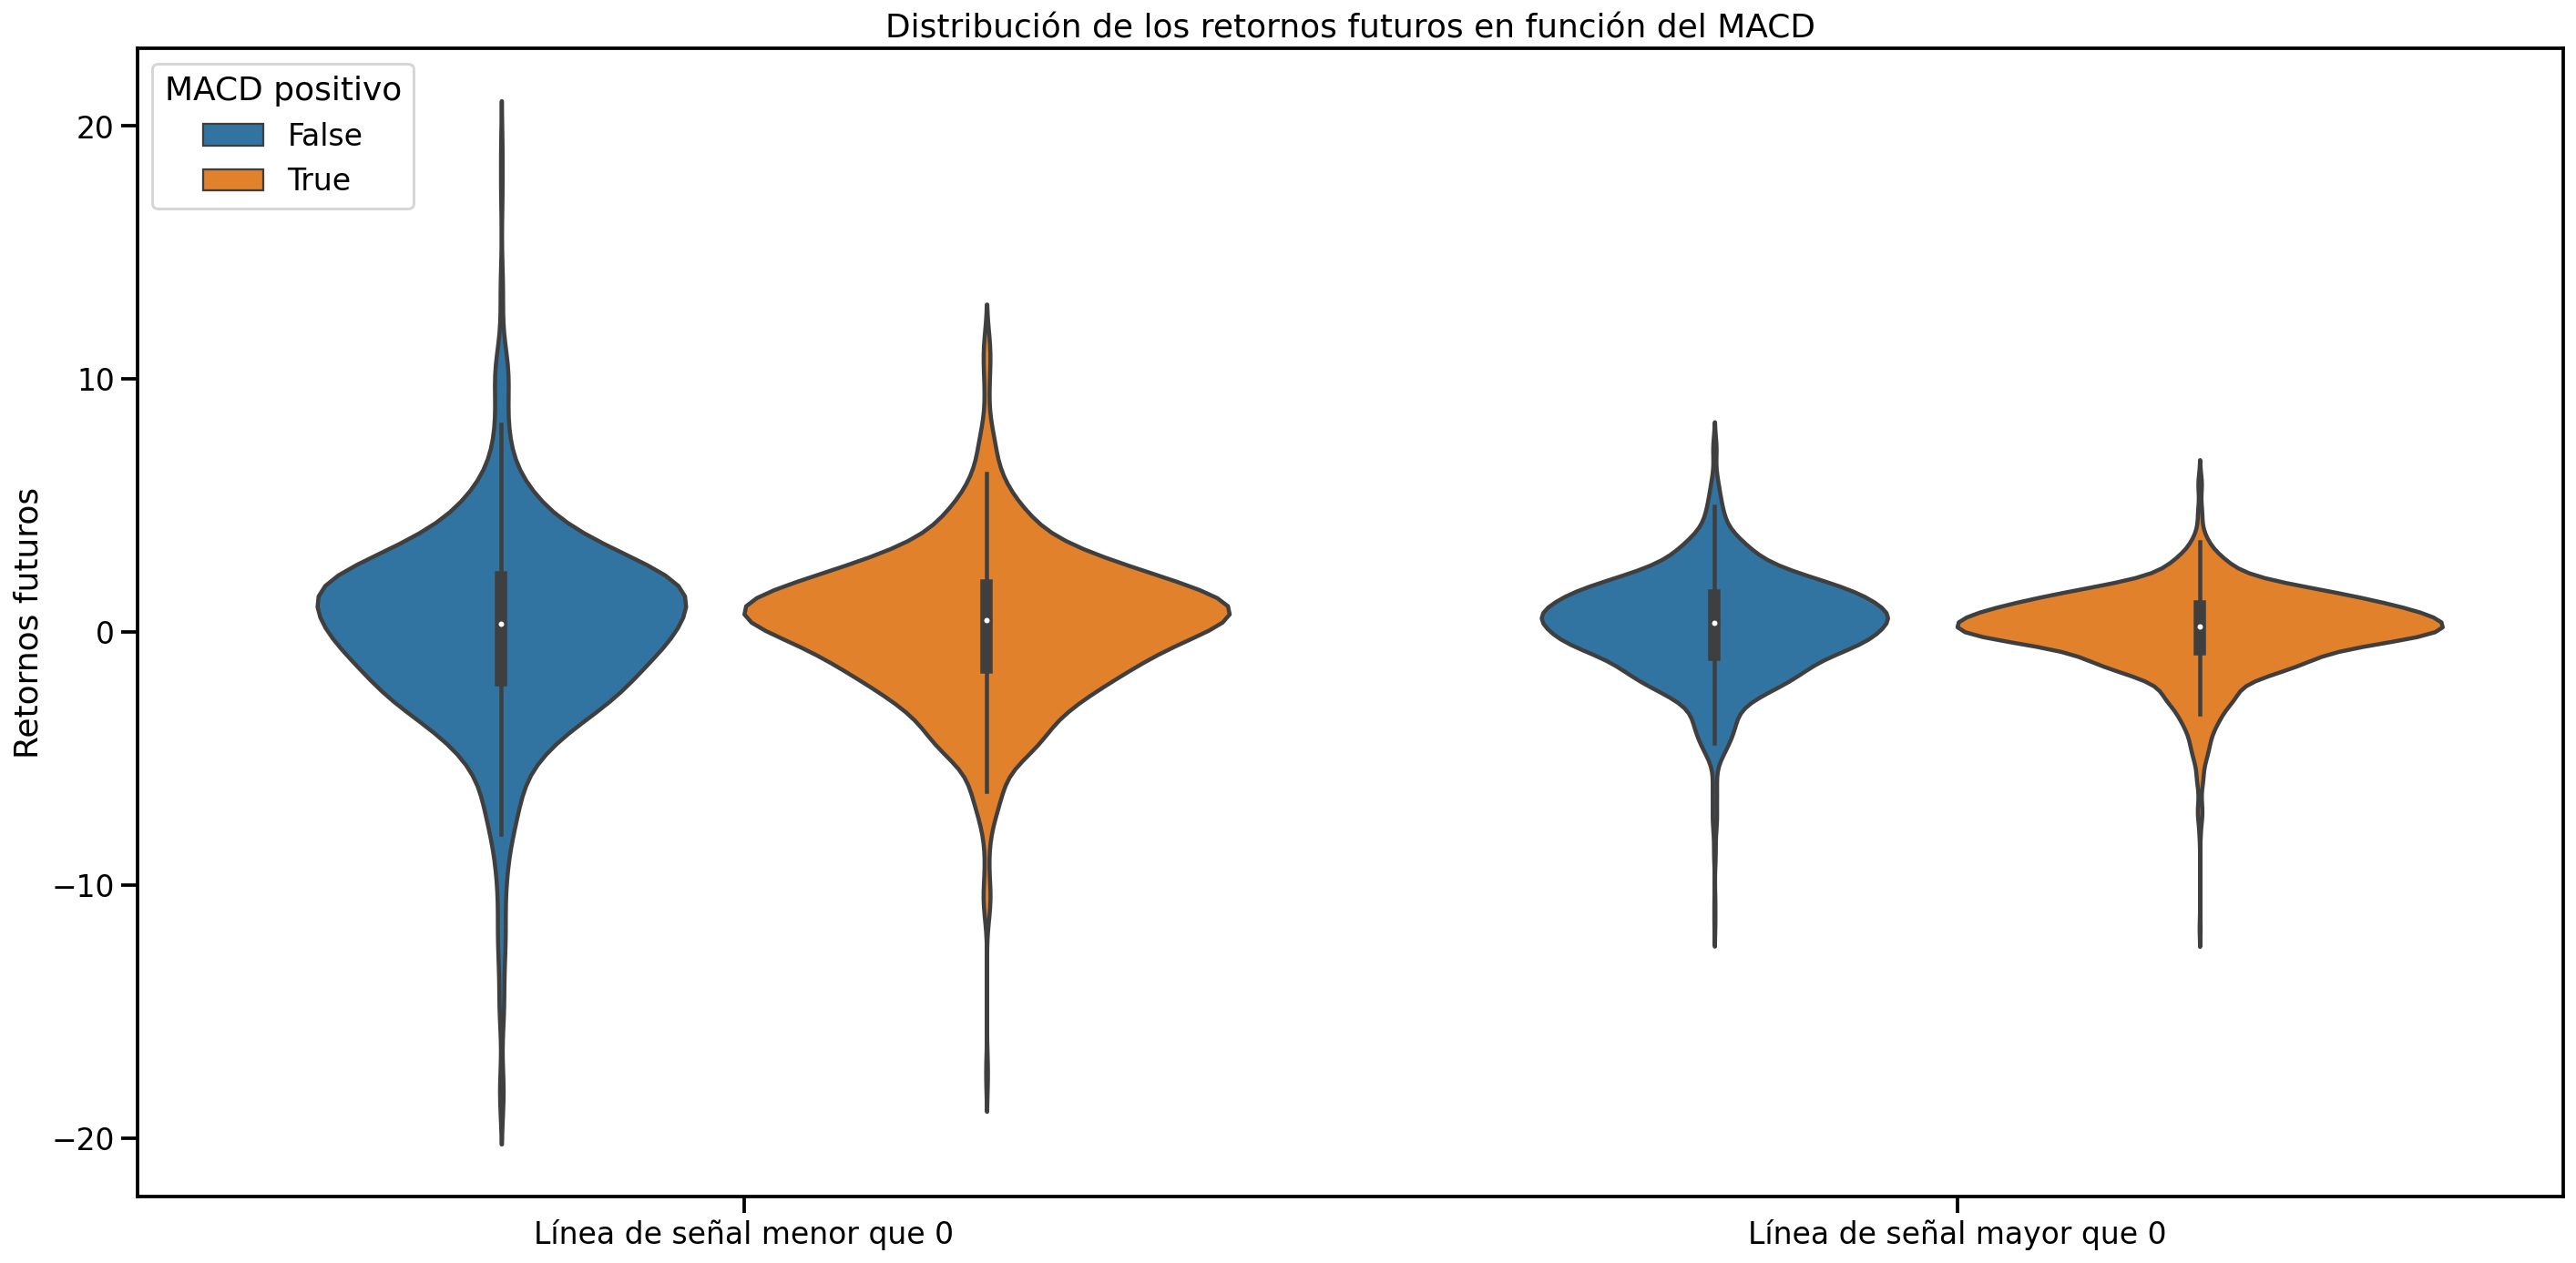

In [80]:
buy = stock_prices['macd_hist'] > 0
above_zero = stock_prices['macd_signal'] >= 0

# Mediciones del MACD
print('---------- Métricas MACD ----------')
print('Señales de compra tendenciales:')
buy_above_trend_frequency = stock_prices[buy & above_zero].future_bullish.value_counts() / len(stock_prices[buy & above_zero])
print('\t', 'Frecuencia de tendencia futura:')
print('\t\t', 'alcista:\t', '{0:.2%}'.format(buy_above_trend_frequency[1]))
print('\t\t', 'bajista:\t', '{0:.2%}'.format(buy_above_trend_frequency[0]))
buy_above_position_frequency = stock_prices[buy & above_zero].future_position.value_counts() / len(stock_prices[buy & above_zero])
print('\t', 'Frecuencia de posición futura:')
print('\t\t', 'largos:\t', '{0:.2%}'.format(buy_above_position_frequency[1]))
print('\t\t', 'cortos:\t', '{0:.2%}'.format(buy_above_position_frequency[0]))
print('\t', 'Media retornos futuros:', '{0:.4f}%'.format(stock_prices.loc[buy & above_zero, 'future_returns'].mean()), '\n')

print('Señales de venta tendenciales:')
sell_below_trend_frequency = stock_prices[(~buy) & (~above_zero)].future_bullish.value_counts() / len(stock_prices[(~buy) & (~above_zero)])
print('\t', 'Frecuencia de tendencia futura:')
print('\t\t', 'alcista:\t', '{0:.2%}'.format(sell_below_trend_frequency[1]))
print('\t\t', 'bajista:\t', '{0:.2%}'.format(sell_below_trend_frequency[0]))
sell_below_position_frequency = stock_prices[(~buy) & (~above_zero)].future_position.value_counts() / len(stock_prices[(~buy) & (~above_zero)])
print('\t', 'Frecuencia de posición futura:')
print('\t\t', 'largos:\t', '{0:.2%}'.format(sell_below_position_frequency[1]))
print('\t\t', 'cortos:\t', '{0:.2%}'.format(sell_below_position_frequency[0]))
print('\t', 'Media retornos futuros:', '{0:.4f}%'.format(stock_prices.loc[(~buy) & (~above_zero), 'future_returns'].mean()), '\n')

print('Señales de compra antitendenciales:')
buy_below_trend_frequency = stock_prices[buy & (~above_zero)].future_bullish.value_counts() / len(stock_prices[buy & (~above_zero)])
print('\t', 'Frecuencia de tendencia futura:')
print('\t\t', 'alcista:\t', '{0:.2%}'.format(buy_below_trend_frequency[1]))
print('\t\t', 'bajista:\t', '{0:.2%}'.format(buy_below_trend_frequency[0]))
buy_below_position_frequency = stock_prices[buy & (~above_zero)].future_position.value_counts() / len(stock_prices[buy & (~above_zero)])
print('\t', 'Frecuencia de posición futura:')
print('\t\t', 'largos:\t', '{0:.2%}'.format(buy_below_position_frequency[1]))
print('\t\t', 'cortos:\t', '{0:.2%}'.format(buy_below_position_frequency[0]))
print('\t', 'Media retornos futuros:', '{0:.4f}%'.format(stock_prices.loc[buy & (~above_zero), 'future_returns'].mean()), '\n')

print('Señales de venta antitendencial:')
sell_above_trend_frequency = stock_prices[(~buy) & above_zero].future_bullish.value_counts() / len(stock_prices[(~buy) & above_zero])
print('\t', 'Frecuencia de tendencia futura:')
print('\t\t', 'alcista:\t', '{0:.2%}'.format(sell_above_trend_frequency[1]))
print('\t\t', 'bajista:\t', '{0:.2%}'.format(sell_above_trend_frequency[0]))
sell_above_position_frequency = stock_prices[(~buy) & above_zero].future_position.value_counts() / len(stock_prices[(~buy) & above_zero])
print('\t', 'Frecuencia de posición futura:')
print('\t\t', 'largos:\t', '{0:.2%}'.format(sell_above_position_frequency[1]))
print('\t\t', 'cortos:\t', '{0:.2%}'.format(sell_above_position_frequency[0]))
print('\t', 'Media retornos futuros:', '{0:.4f}%'.format(stock_prices.loc[(~buy) & above_zero, 'future_returns'].mean()), '\n')

print('Precisión en señales tendenciales:\t', '{0:.2%}'.format(
  (stock_prices[buy & above_zero].future_position.value_counts()[1]
 + stock_prices[(~buy) & (~above_zero)].future_position.value_counts()[0])
 / ((stock_prices[buy & above_zero].future_position != 2).sum() + (stock_prices[(~buy) & (~above_zero)].future_position != 2).sum())  
))

print('Precisión en señales antitendenciales:\t', '{0:.2%}'.format(
  (stock_prices[buy & (~above_zero)].future_position.value_counts()[1]
 + stock_prices[(~buy) & above_zero].future_position.value_counts()[0])
 / ((stock_prices[buy & (~above_zero)].future_position != 2).sum() + (stock_prices[(~buy) & above_zero].future_position != 2).sum())  
))

# gráfica de las distribuciones de los retornos según la posición del MACD
plt.figure(figsize=(20, 10))
macd_df = pd.concat([stock_prices, buy.rename('buy'), above_zero.rename('above_zero')], axis=1)
ax = sns.violinplot(x='above_zero', y='future_returns', hue='buy', data=macd_df)
plt.title('Distribución de los retornos futuros en función del MACD')
plt.xlabel('')
plt.ylabel('Retornos futuros')
plt.xticks([0, 1], ['Línea de señal menor que 0', 'Línea de señal mayor que 0'])
plt.legend(title='MACD positivo', loc='upper left')

save_fig('figure_2_9')
plt.show()

### Contraste de hipótesis
Se realiza la prueba U de Mann-Whitney para comprobar si la distribución de los retornos futuros es diferente en cada posición del MACD con respecto a las demás.

In [81]:
print('Prueba de hipótesis en compra tendencial:')
mw_test = scs.mannwhitneyu(stock_prices.loc[buy & above_zero, 'future_returns'], stock_prices.loc[~(buy & above_zero), 'future_returns'])
print(f'\t Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

print('\nPrueba de hipótesis en venta tendencial:')
mw_test = scs.mannwhitneyu(stock_prices.loc[(~buy) & (~above_zero), 'future_returns'], stock_prices.loc[~((~buy) & (~above_zero)), 'future_returns'])
print(f'\t Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

print('\nPrueba de hipótesis en compra antitendencial:')
mw_test = scs.mannwhitneyu(stock_prices.loc[buy & (~above_zero), 'future_returns'], stock_prices.loc[~(buy & (~above_zero)), 'future_returns'])
print(f'\t Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')

print('\nPrueba de hipótesis en venta antitendencial:')
mw_test = scs.mannwhitneyu(stock_prices.loc[(~buy) & above_zero, 'future_returns'], stock_prices.loc[~((~buy) & above_zero), 'future_returns'])
print(f'\t Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')


Prueba de hipótesis en compra tendencial:
	 Estadístico de la prueba Mann-Whitney U: 2987116.00 con valor p: 0.00

Prueba de hipótesis en venta tendencial:
	 Estadístico de la prueba Mann-Whitney U: 2130922.00 con valor p: 0.21

Prueba de hipótesis en compra antitendencial:
	 Estadístico de la prueba Mann-Whitney U: 1873003.00 con valor p: 0.05

Prueba de hipótesis en venta antitendencial:
	 Estadístico de la prueba Mann-Whitney U: 2924331.00 con valor p: 0.06


## 2.6. PPO
El PPO (Percentage Price Oscillator) mide la distancia entre dos medias, una larga de 26 y otra corta de 12, en términos porcentuales. Es similar a estudiar la importancia de la distancia del precio a una media.

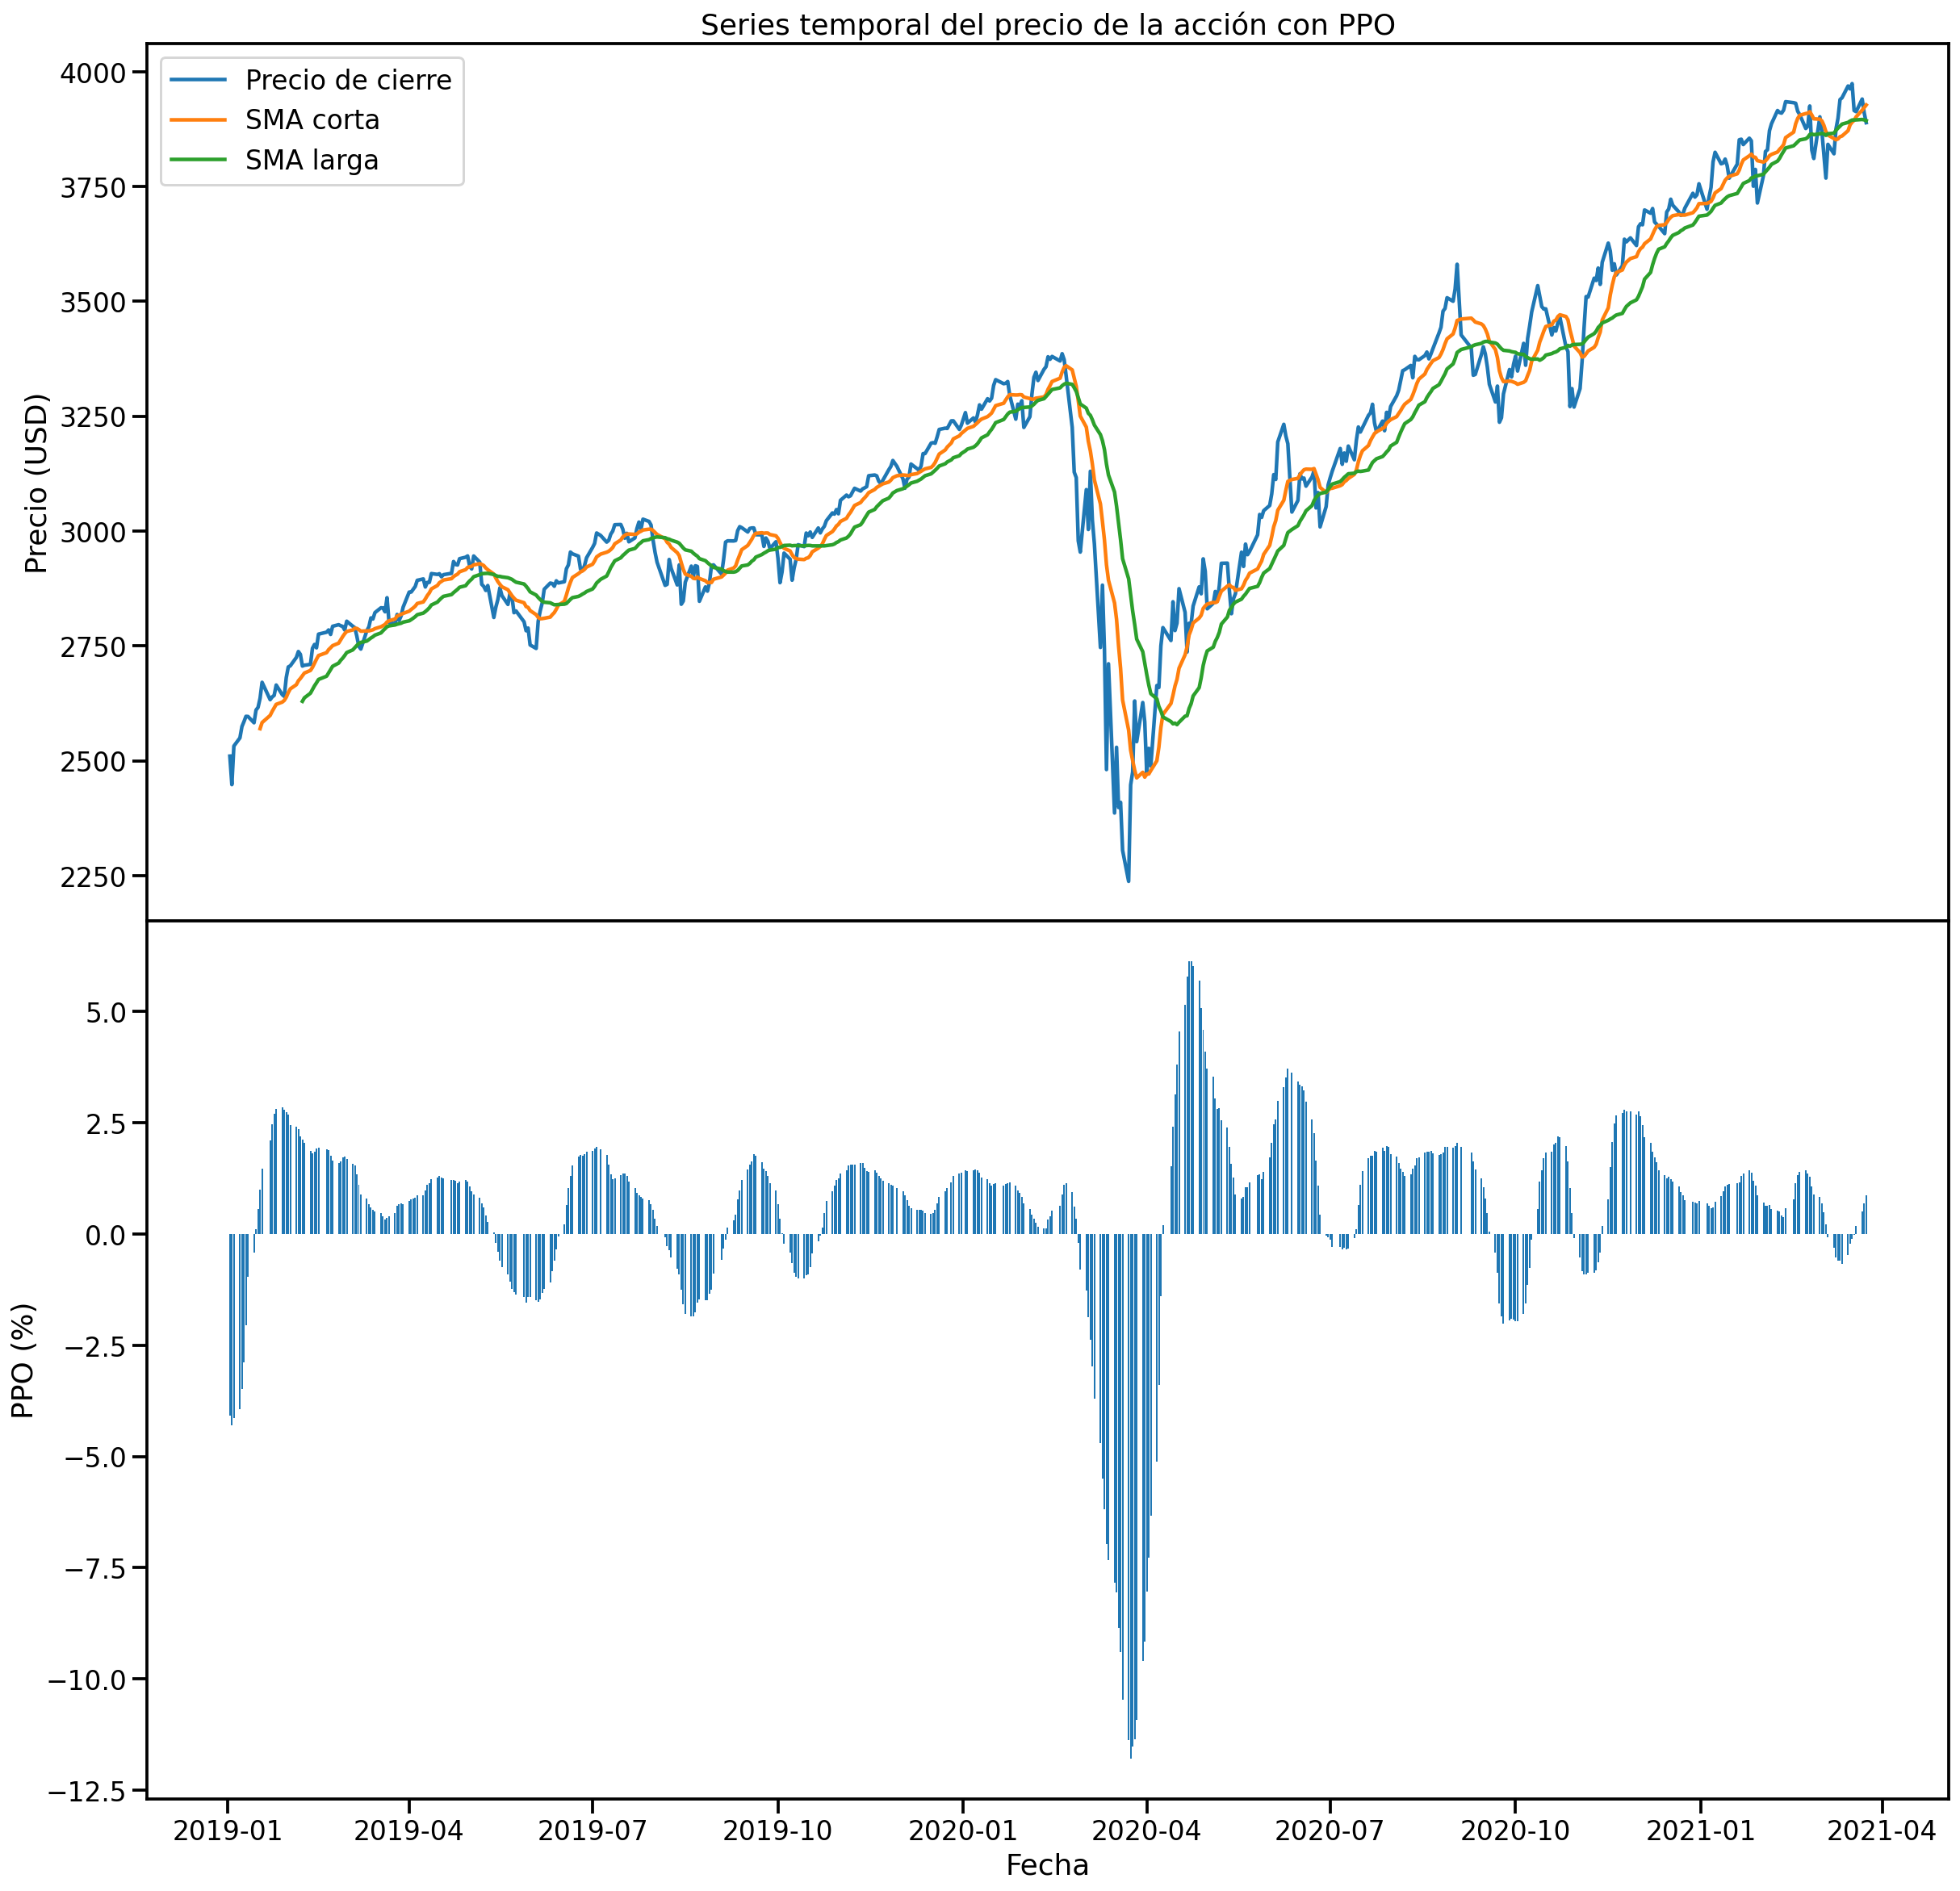

In [16]:
# obtener el PPO
FAST_PERIOD = 12
SLOW_PERIOD = 26
stock_prices['ppo'] = talib.PPO(stock_prices['close'].values, fastperiod=FAST_PERIOD, slowperiod=SLOW_PERIOD, matype=0)

# gráfica del PPO
def plot_ppo(data, starting_date, fastperiod=12, slowperiod=26):
    data = data.loc[starting_date:]
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    ax[0].plot(data['close'], label='Precio de cierre')
    ax[0].plot(talib.SMA(data['close'], timeperiod=fastperiod), label='SMA corta')
    ax[0].plot(talib.SMA(data['close'], timeperiod=slowperiod), label='SMA larga')
    
    ax[0].set(title='Series temporal del precio de la acción con PPO', ylabel='Precio (USD)')
    ax[0].legend()

    ax[1].bar(data.index, data["ppo"])
    ax[1].set(xlabel='Fecha', ylabel='PPO (%)')

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_10', tight_layout=False)
    plt.show()
    
plot_ppo(stock_prices, '2019', FAST_PERIOD, SLOW_PERIOD)

Estudiamos si el valor del PPO influye en los retornos futuros. No se observa correlación alguna.

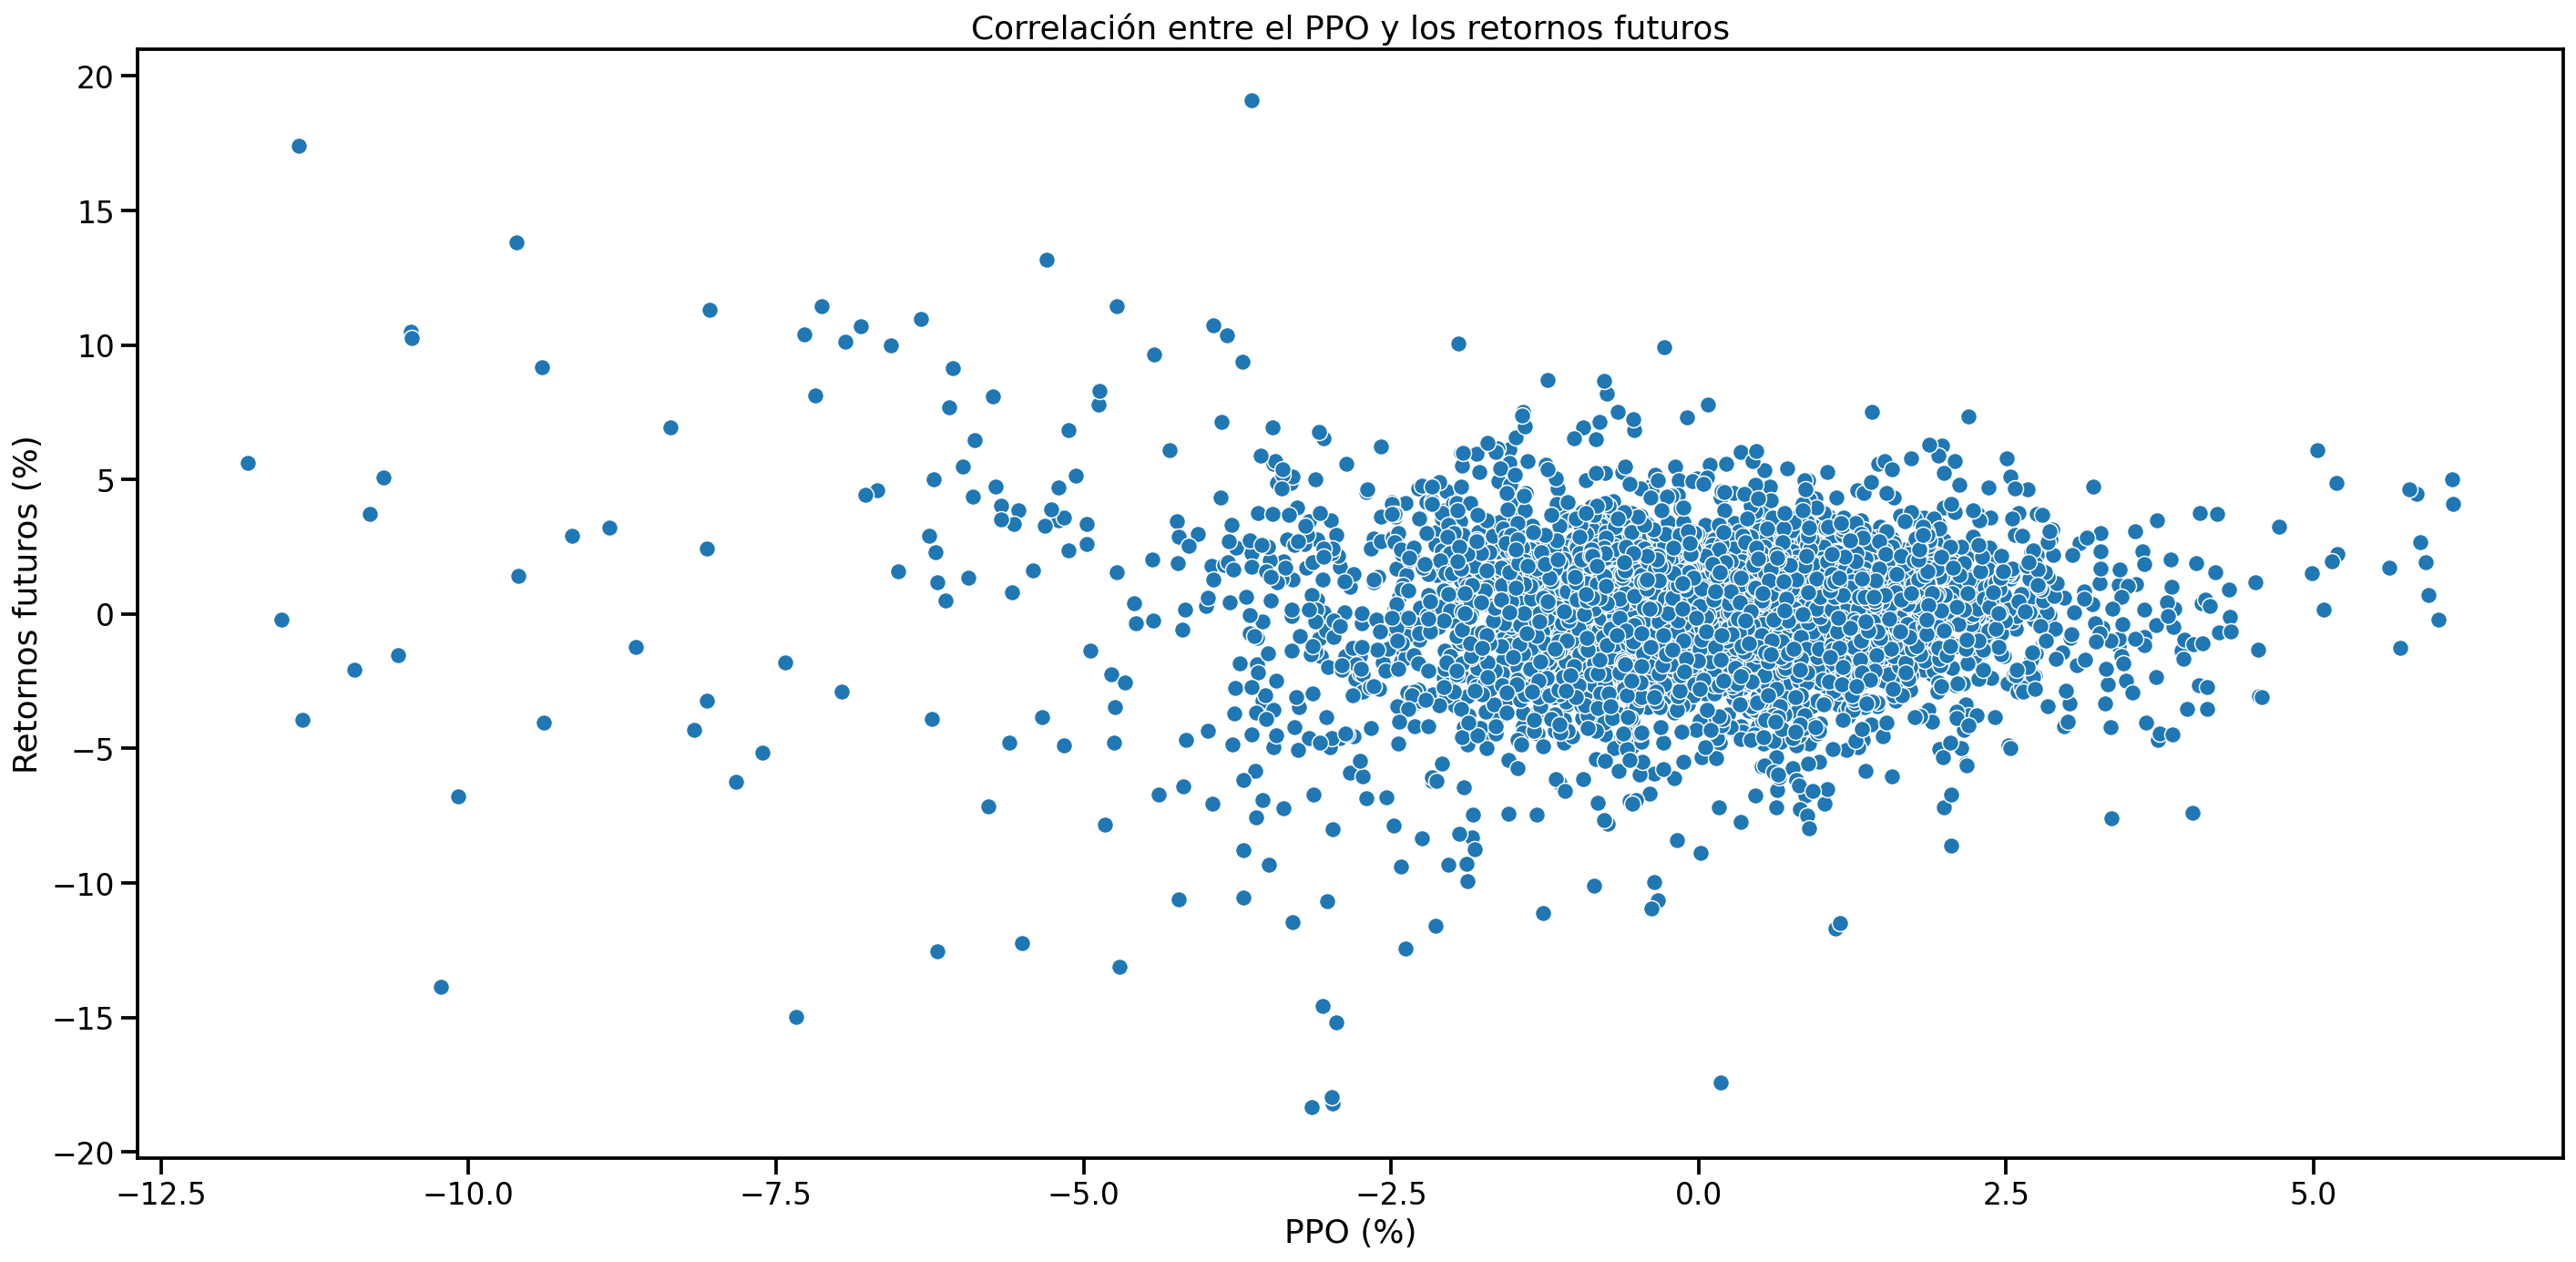

In [17]:
# scatter plot del ppo con los retornos
plt.figure(figsize=(20, 10))
sns.scatterplot(x='ppo', y='future_returns', data=stock_prices)
plt.title('Correlación entre el PPO y los retornos futuros')
plt.xlabel('PPO (%)')
plt.ylabel('Retornos futuros (%)')

save_fig('figure_2_11')
plt.show()

Estudiamos si los retornos futuros difieren mucho cuando el PPO es positivo a cuando es negativo, en valor y en tendencia.

In [84]:
positive_ppo = stock_prices.ppo >= 0

relative_frecuency = positive_ppo.value_counts() / len(stock_prices.ppo)
positive_ppo_trend_frequency = stock_prices[positive_ppo].future_bullish.value_counts() / np.sum(positive_ppo)
negative_ppo_trend_frequency = stock_prices[(~positive_ppo)].future_bullish.value_counts() / np.sum(~positive_ppo)
positive_ppo_position_frequency = stock_prices[positive_ppo].future_position.value_counts() / np.sum(positive_ppo)
negative_ppo_position_frequency = stock_prices[(~positive_ppo)].future_position.value_counts() / np.sum(~positive_ppo)

#estadísticas de los retornos futuros con el PPO positivo o negativo
print('---------- Métricas PPO ----------')
print('PPO positivo:')
print('Frecuencia relativa:\t', '{0:.2%}'.format(relative_frecuency[1]))
print('\tFrecuencia de la tendencia:')
print('\t\talcista:', '{0:.2%}'.format(positive_ppo_trend_frequency[1]))
print('\t\tbajista:', '{0:.2%}'.format(positive_ppo_trend_frequency[0]))
print('\tFrecuencia de la posición:')
print('\t\tlargos:\t', '{0:.2%}'.format(positive_ppo_position_frequency[1]))
print('\t\tcortos:\t', '{0:.2%}'.format(positive_ppo_position_frequency[0]))
print('Media retornos futuros:\t', '{0:.2}%'.format(stock_prices.loc[positive_ppo, 'future_returns'].mean()), '\n')

print('PPO negativo:')
print('Frecuencia relativa:\t', '{0:.2%}'.format(relative_frecuency[0]))
print('\tFrecuencia de la tendencia:')
print('\t\talcista:', '{0:.2%}'.format(negative_ppo_trend_frequency[1]))
print('\t\tbajista:', '{0:.2%}'.format(negative_ppo_trend_frequency[0]))
print('\tFrecuencia de la posición:')
print('\t\tlargos:\t', '{0:.2%}'.format(negative_ppo_position_frequency[1]))
print('\t\tcortos:\t', '{0:.2%}'.format(negative_ppo_position_frequency[0]))
print('Media retornos futuros:\t', '{0:.2}%'.format(stock_prices.loc[~positive_ppo, 'future_returns'].mean()))

---------- Métricas PPO ----------
PPO positivo:
Frecuencia relativa:	 61.60%
	Frecuencia de la tendencia:
		alcista: 57.33%
		bajista: 42.67%
	Frecuencia de la posición:
		largos:	 14.75%
		cortos:	 13.13%
Media retornos futuros:	 0.11% 

PPO negativo:
Frecuencia relativa:	 38.40%
	Frecuencia de la tendencia:
		alcista: 56.00%
		bajista: 44.00%
	Frecuencia de la posición:
		largos:	 26.80%
		cortos:	 22.59%
Media retornos futuros:	 0.15%


### Contraste de hipótesis
Se realiza la prueba U de Mann-Whitney para comprobar si la distribución de los retornos futuros es diferente cuando el PPO es positivo a cuando es negativo.

In [68]:
mw_test = scs.mannwhitneyu(stock_prices.loc[stock_prices.ppo >= 0, 'future_returns'], stock_prices.loc[stock_prices.ppo < 0, 'future_returns'])
print(f'Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')


Estadístico de la prueba Mann-Whitney U: 3195560.00 con valor p: 0.03


## 2.7 Bandas de Bollinger

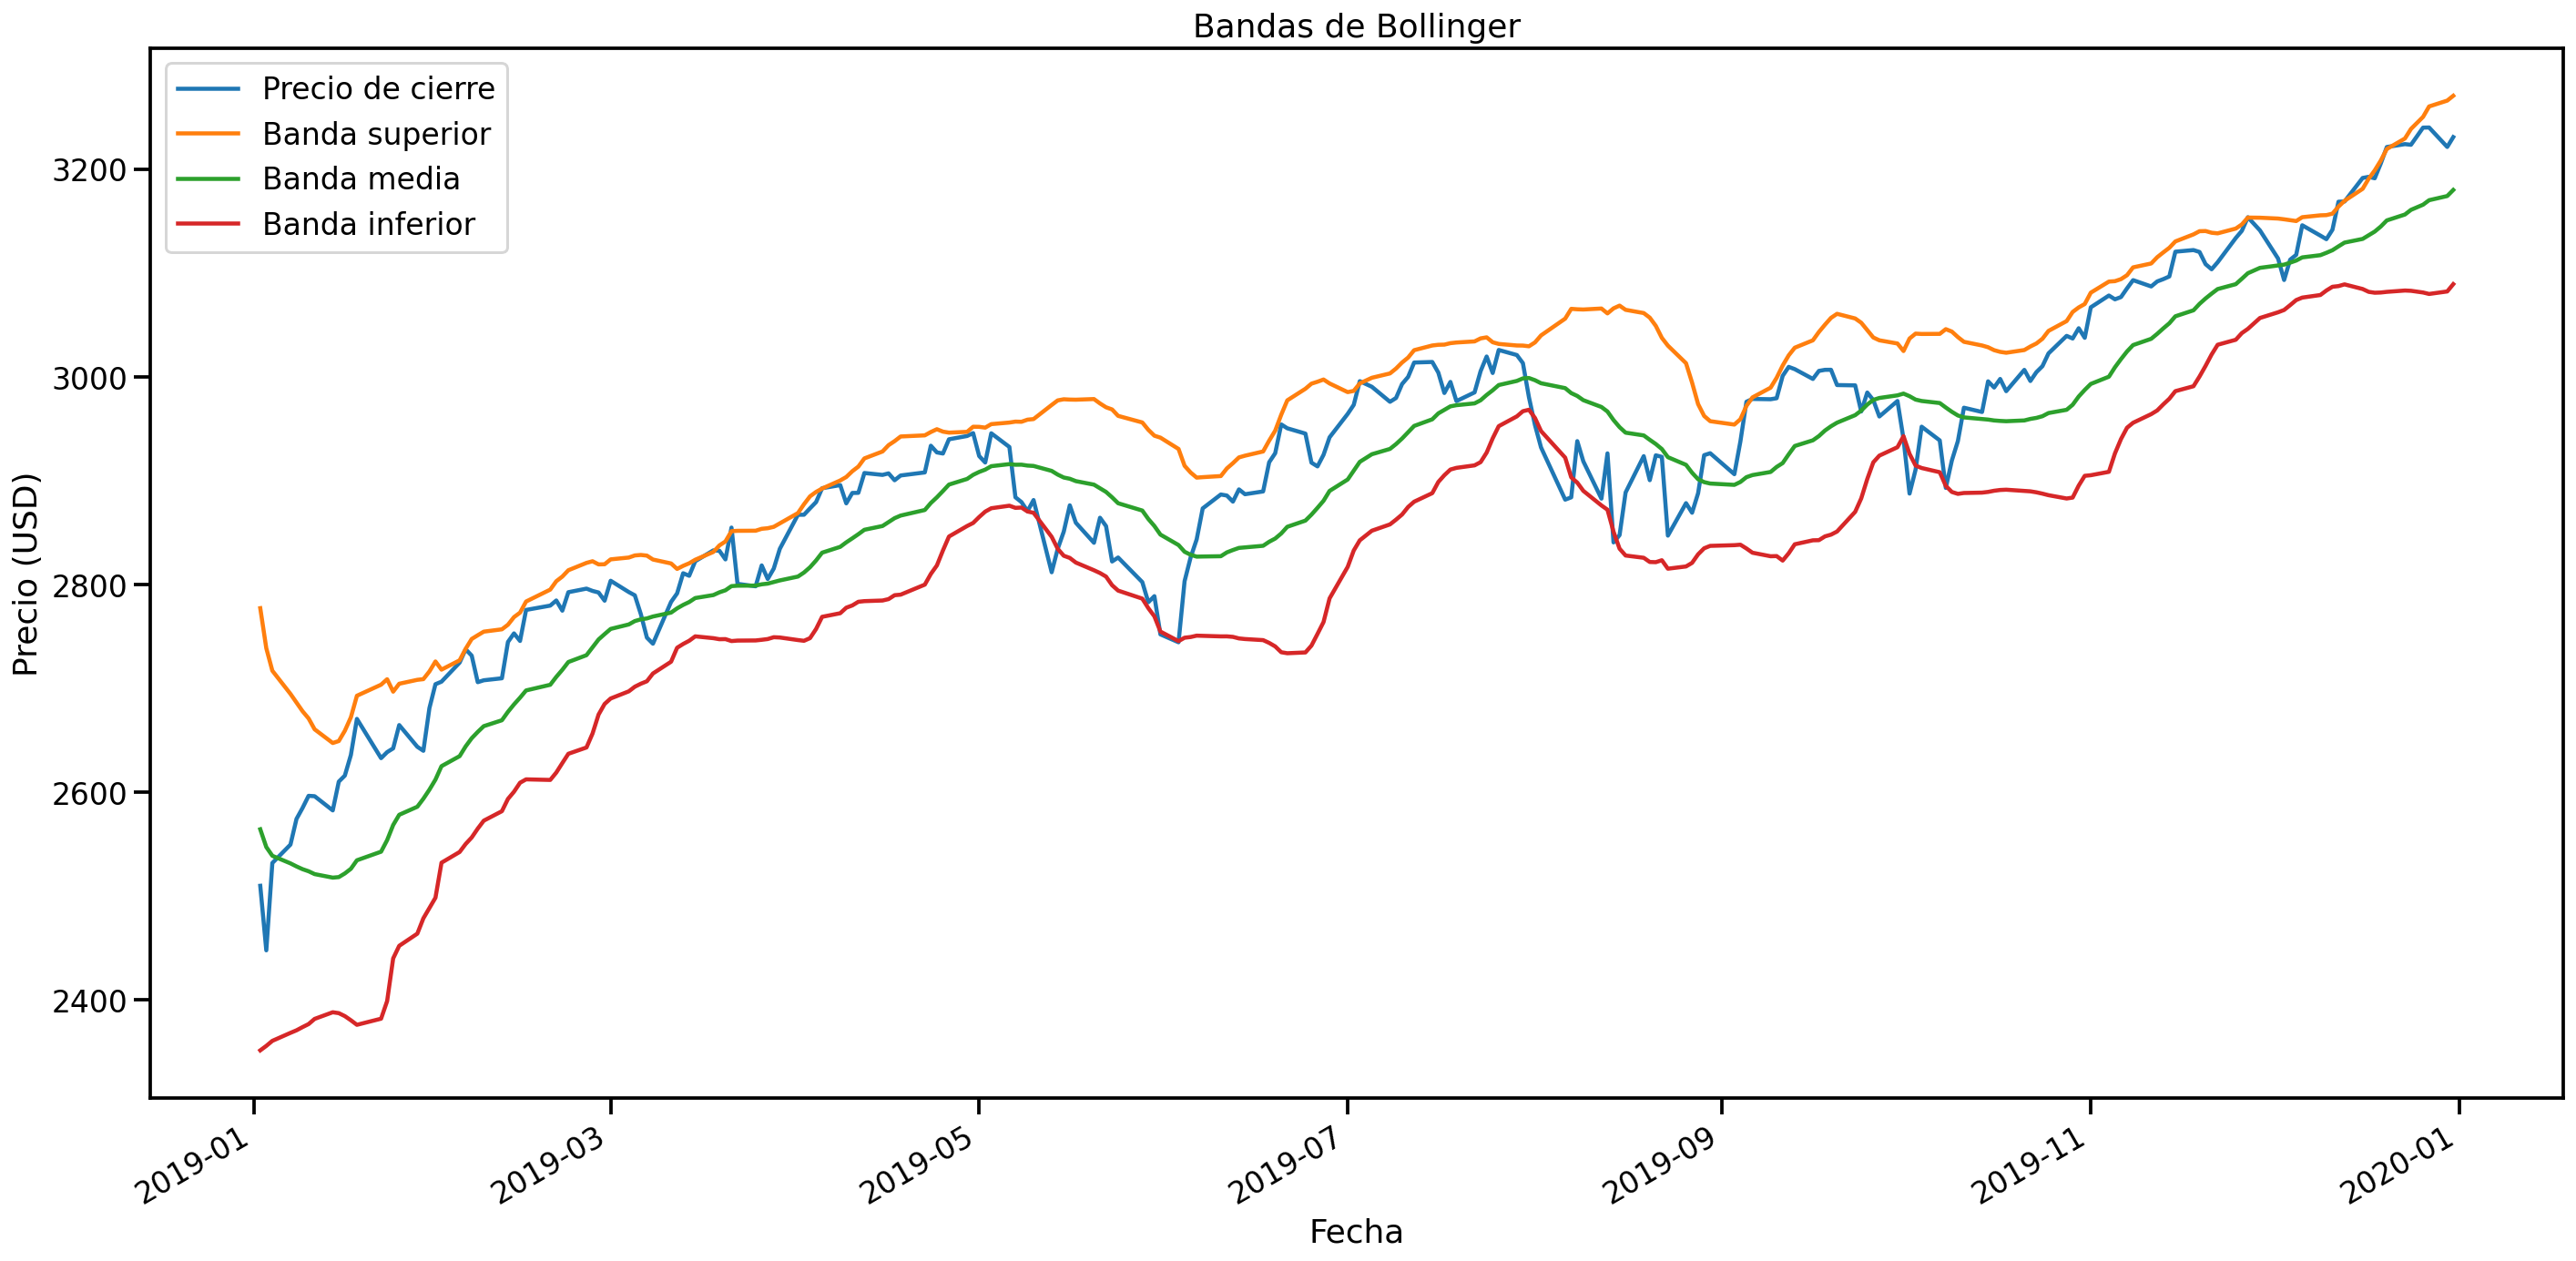

In [20]:
PERIOD = 20
# obtener bollinger bands
stock_prices['bb_upperband'], stock_prices['bb_middleband'], stock_prices['bb_lowerband'] = talib.BBANDS(stock_prices.close, timeperiod=PERIOD, nbdevup=2, nbdevdn=2, matype=0)

# gráfica de las bollinger bands con el precio
def plot_bb(data, starting_date):
    data = data.loc[starting_date]
    
    data[['close', 'bb_upperband', 'bb_middleband', 'bb_lowerband']].plot(figsize=(20, 10))

    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    plt.title('Bandas de Bollinger')
    plt.legend(labels=['Precio de cierre', 'Banda superior', 'Banda media', 'Banda inferior'])

    save_fig('figure_2_12')
    plt.show()
    
plot_bb(stock_prices, '2019')


Se estudia el poder de las bandas de Bollinger para cambiar la dirección del precio. En teoría el precio permanece dentro de las bandas por lo que si supera la superior debería descender y si supera la inferior debería ascender.

In [88]:
above_bb_upperband = stock_prices.close >= stock_prices.bb_upperband
below_bb_lowerband = stock_prices.close <= stock_prices.bb_lowerband

above_bb_upperband_trend_frequency = stock_prices[above_bb_upperband].future_bullish.value_counts() / np.sum(above_bb_upperband)
below_bb_lowerband_trend_frequency = stock_prices[below_bb_lowerband].future_bullish.value_counts() / np.sum(below_bb_lowerband)

above_bb_upperband_position_frequency = stock_prices[above_bb_upperband].future_position.value_counts() / np.sum(above_bb_upperband)
below_bb_lowerband_position_frequency = stock_prices[below_bb_lowerband].future_position.value_counts() / np.sum(below_bb_lowerband)


#estadísticas de los retornos futuros con el PPO positivo o negativo
print('---------- Métricas Bandas de Bollinger ----------')
print('Precio sobre la banda superior:')
print('\tNúmero de observaciones:', above_bb_upperband.sum())
print('\tFrecuencia relativa:\t', '{0:.2%}'.format(above_bb_upperband.sum() / len(stock_prices)))
print('\tFrecuencia de la tendencia:')
print('\t\talcista:\t', '{0:.2%}'.format(above_bb_upperband_trend_frequency[1]))
print('\t\tbajista:\t', '{0:.2%}'.format(above_bb_upperband_trend_frequency[0]))
print('\tFrecuencia de posición:')
print('\t\tlargos:\t\t', '{0:.2%}'.format(above_bb_upperband_position_frequency[1]))
print('\t\tcortos:\t\t', '{0:.2%}'.format(above_bb_upperband_position_frequency[0]))
print('\tMedia retornos futuros:\t', '{0:.2}%'.format(stock_prices.loc[above_bb_upperband, 'future_returns'].mean()), '\n')

print('Precio por debajo de banda inferior:')
print('\tNúmero de observaciones:', below_bb_lowerband.sum())
print('\tFrecuencia relativa:\t', '{0:.2%}'.format(below_bb_lowerband.sum() / len(stock_prices)))
print('\tFrecuencia de la tendencia:')
print('\t\talcista:\t', '{0:.2%}'.format(below_bb_lowerband_trend_frequency[1]))
print('\t\tbajista:\t', '{0:.2%}'.format(below_bb_lowerband_trend_frequency[0]))
print('\tFrecuencia de posición:')
print('\t\tlargos:\t\t', '{0:.2%}'.format(below_bb_lowerband_position_frequency[1]))
print('\t\tcortos:\t\t', '{0:.2%}'.format(below_bb_lowerband_position_frequency[0]))
print('\tMedia retornos futuros:\t', '{0:.2}%'.format(stock_prices.loc[below_bb_lowerband, 'future_returns'].mean()))


---------- Métricas Bandas de Bollinger ----------
Precio sobre la banda superior:
	Número de observaciones: 246
	Frecuencia relativa:	 4.63%
	Frecuencia de la tendencia:
		alcista:	 52.44%
		bajista:	 47.56%
	Frecuencia de posición:
		largos:		 5.69%
		cortos:		 14.63%
	Media retornos futuros:	 -0.16% 

Precio por debajo de banda inferior:
	Número de observaciones: 289
	Frecuencia relativa:	 5.44%
	Frecuencia de la tendencia:
		alcista:	 58.48%
		bajista:	 41.52%
	Frecuencia de posición:
		largos:		 30.80%
		cortos:		 15.22%
	Media retornos futuros:	 0.55%


### Contraste de hipótesis
Se realiza la prueba U de Mann-Whitney para comprobar las siguientes hipótesis sobre las bandas de Bollinger:

1. La distribución de los retornos cuando el precio supera la banda superior es distinta a cuando no lo es.

2. La distribución de los retornos cuando el precio es inferior a la banda inferior es distinta a cuando no lo es.

In [70]:
# Hypothesis testing: las distribuciones de retornos son diferentes por encima de bb_upperband
mw_test = scs.mannwhitneyu(stock_prices.loc[above_bb_upperband, 'future_returns'],
                           stock_prices.loc[stock_prices.close < stock_prices.bb_upperband, 'future_returns'])
print(f'1. Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')


# Hypothesis testing: las distribuciones de retornos son diferentes por debajo de bb_lowerband
mw_test = scs.mannwhitneyu(stock_prices.loc[below_bb_lowerband, 'future_returns'],
                           stock_prices.loc[stock_prices.close > stock_prices.bb_lowerband, 'future_returns'])
print(f'2. Estadístico de la prueba Mann-Whitney U: {mw_test[0]:.2f} con valor p: {mw_test[1]:.2f}')


1. Estadístico de la prueba Mann-Whitney U: 550848.00 con valor p: 0.00
2. Estadístico de la prueba Mann-Whitney U: 656180.00 con valor p: 0.00


## 2.8. NVI
El NVI (Normalized Volatility Indicator) es un indicador de volatilidad, como su nombre indica nos aporta información acerca de la volatilidad del activo en un momento dado considerando un período previo. El NVI es simplemente otro indicador llamado ATR normalizado. El ATR (Average True Range) se construye calculando la media de las diferencias entre máximos y mínimos de las n barras anteriores.  

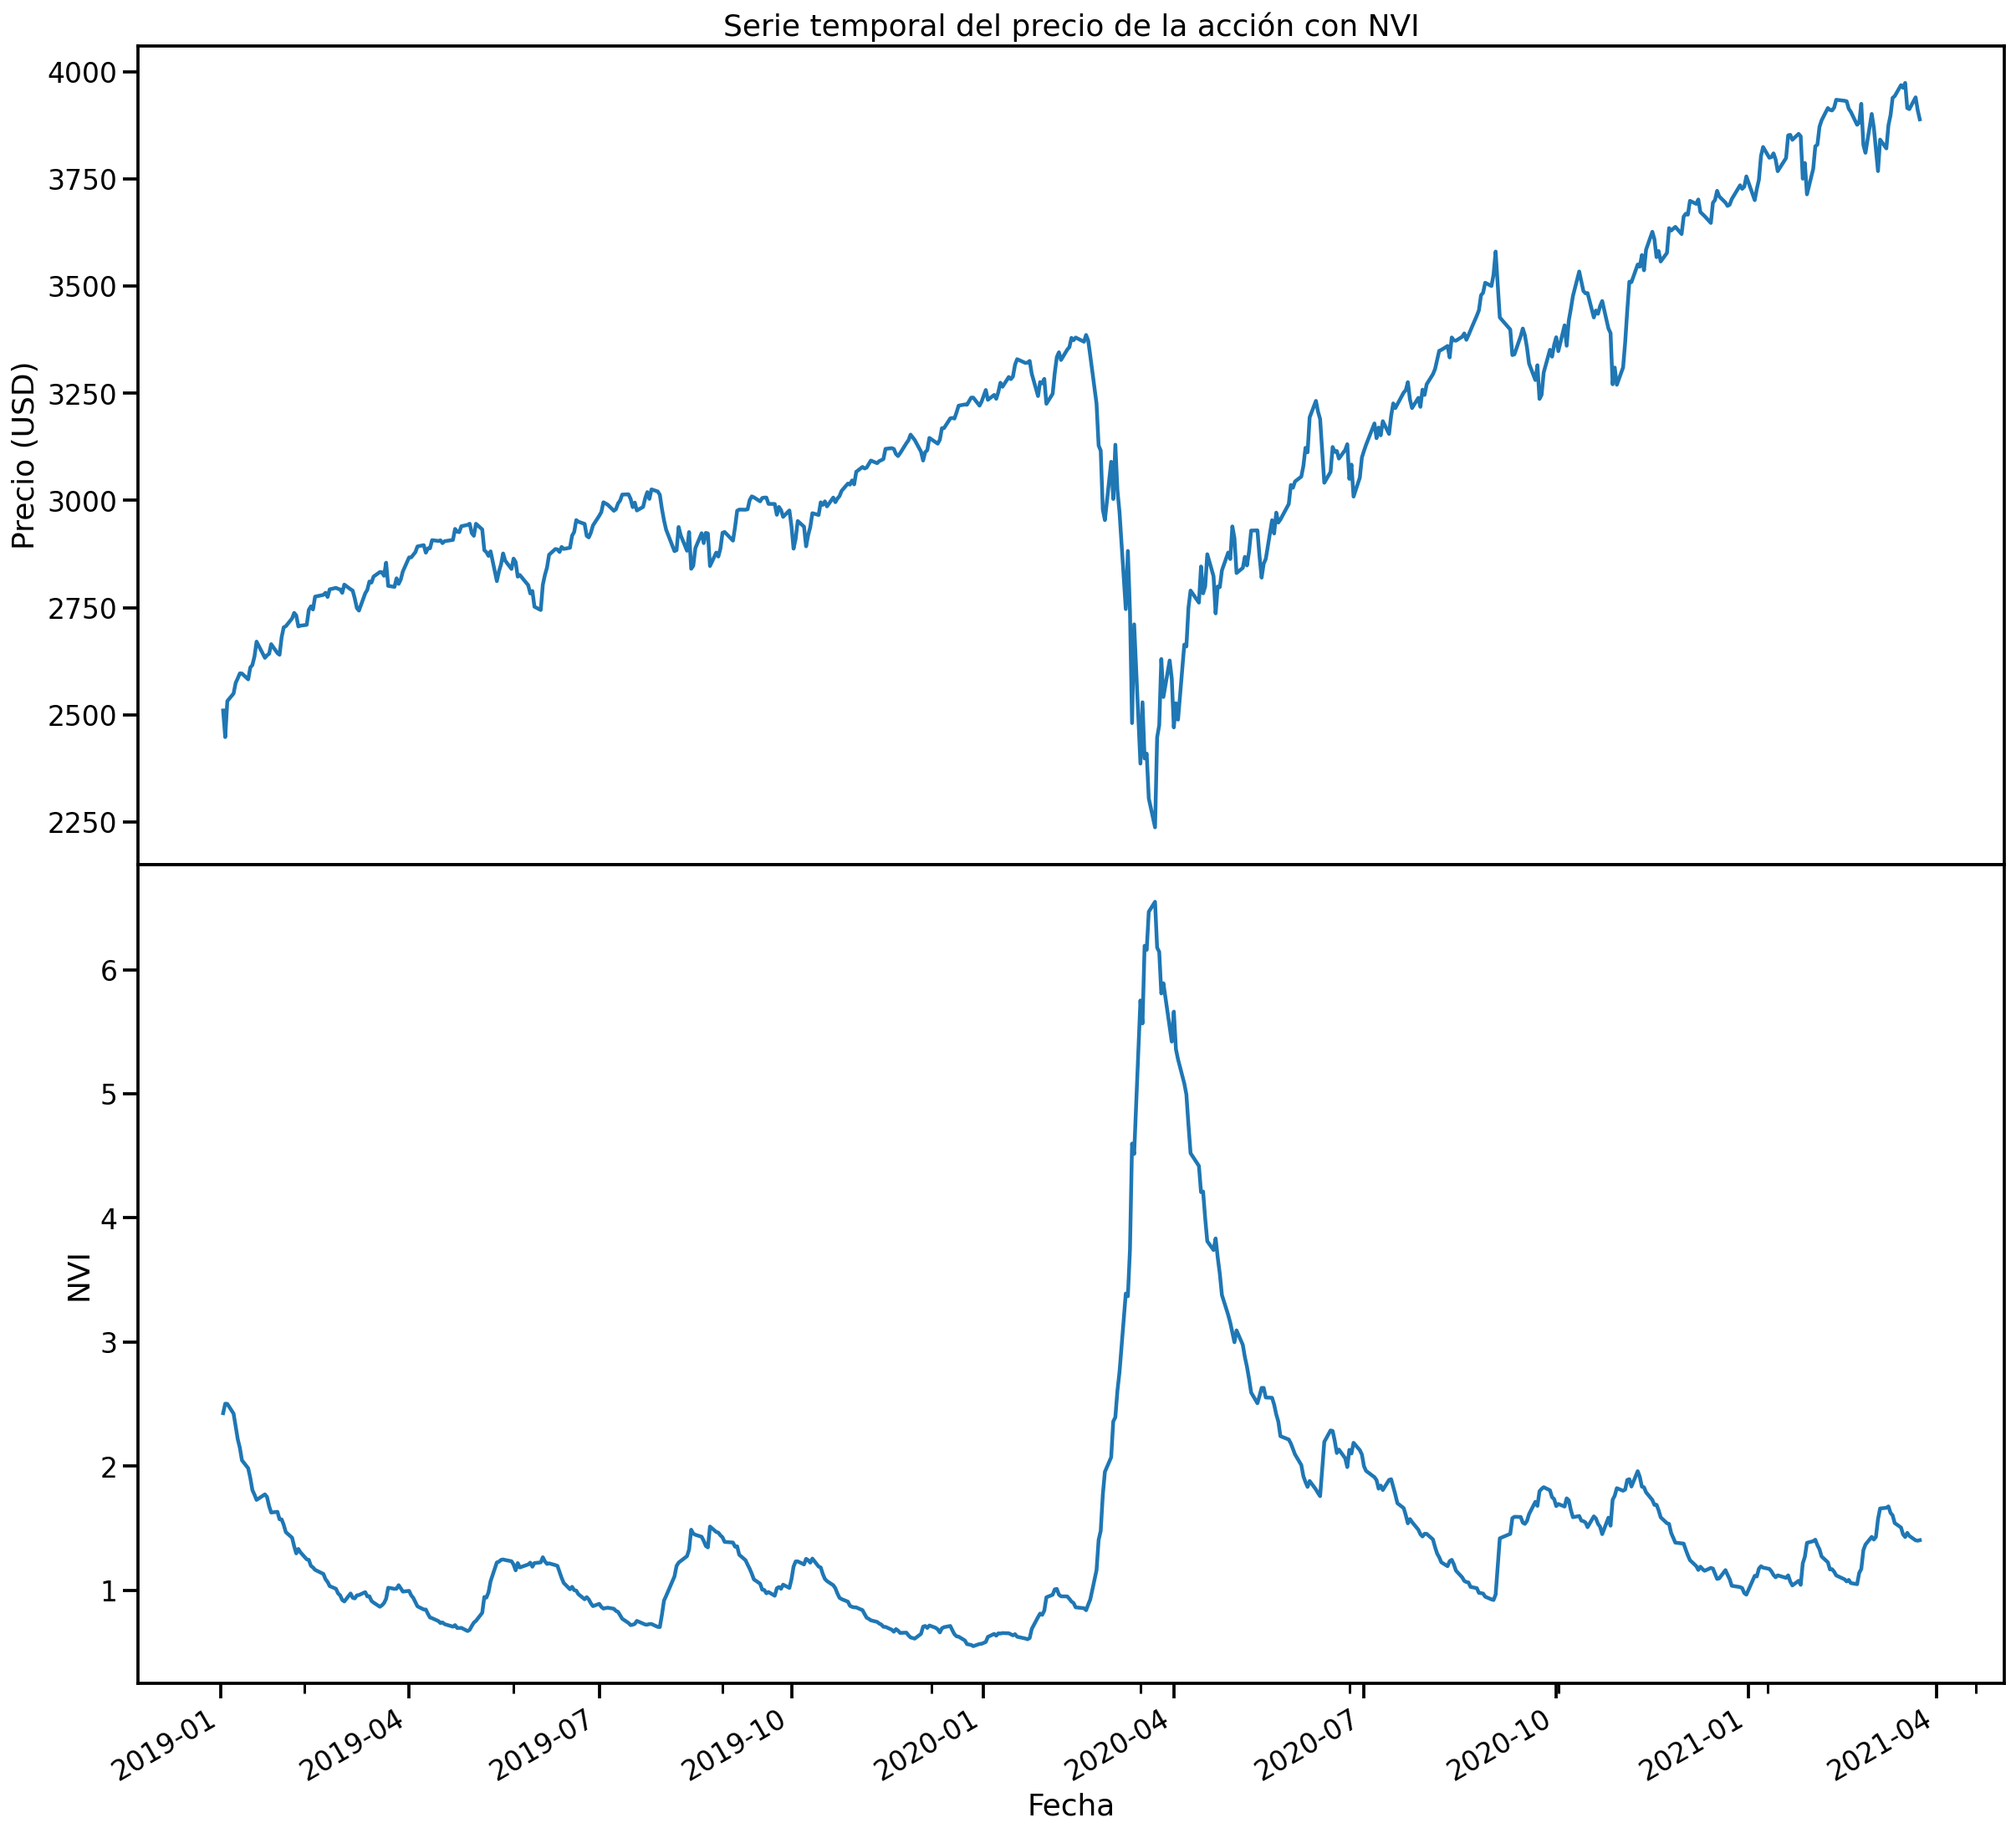

In [23]:
PERIOD = 14
# obtener NVI
stock_prices['nvi'] = talib.NATR(stock_prices.high, stock_prices.low, stock_prices.close, timeperiod=PERIOD)

# gráfica del NVI con el precio
def plot_nvi(data, starting_date):
    data = data.loc[starting_date:]

    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    data['close'].plot(ax=ax[0])
    ax[0].set(title='Serie temporal del precio de la acción con NVI', ylabel='Precio (USD)')

    data['nvi'].plot(ax=ax[1])
    ax[1].set(ylabel='NVI', xlabel='Fecha')

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_13', tight_layout=False)
    plt.show()
    
plot_nvi(stock_prices, '2019')

Se estudia si el NVI tiene relación con los retornos futuros. Se observa una correlación considerable con los retornos absolutos futuros por la autocorrelación de la volatilidad, pero no hay relación con los retornos futuros.

Correlación del nvi con otras variables:
nvi                           1.000000
retornos futuros              0.031010
retornos futuros absolutos    0.494502
Name: nvi, dtype: float64


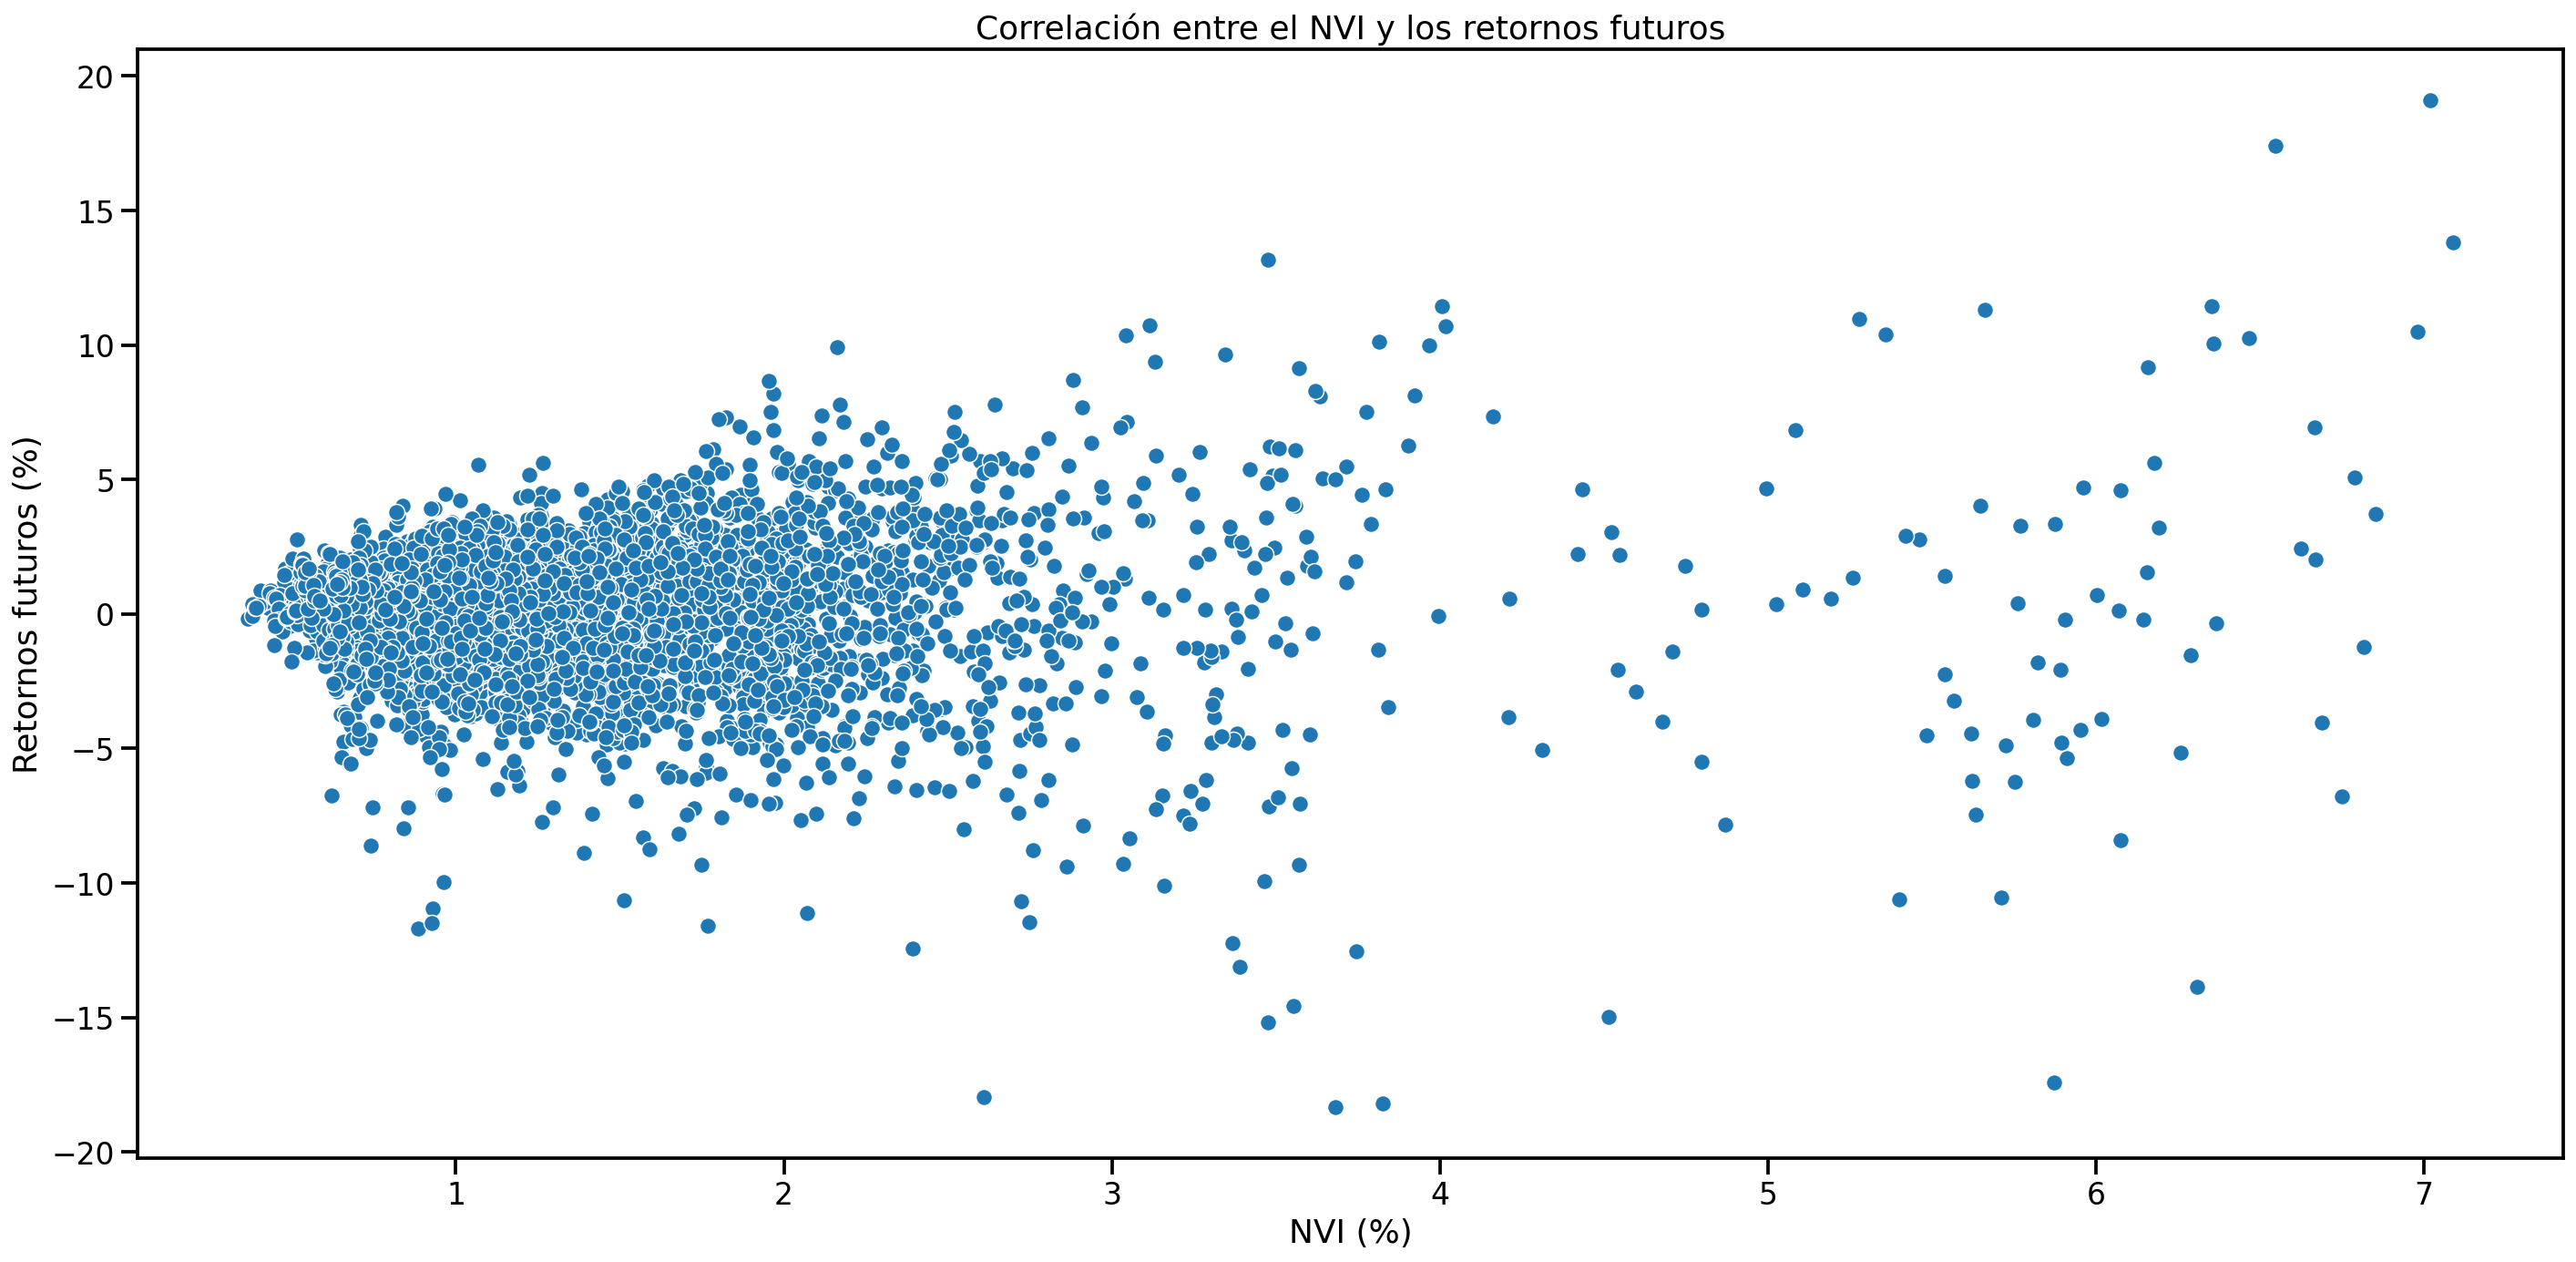

In [89]:
# correlación entre nvi, retornos futuros y retornos absolutos futuros
print('Correlación del nvi con otras variables:')
print(pd.DataFrame({'nvi': stock_prices.nvi.values,
              'retornos futuros': stock_prices.future_returns.values,
              'retornos futuros absolutos': np.abs(stock_prices.future_returns)}).corr()['nvi'])

# scatter plot del nvi con los retornos futuros
plt.figure(figsize=(20, 10))
sns.scatterplot(x='nvi', y='future_returns', data=stock_prices)
plt.title('Correlación entre el NVI y los retornos futuros')
plt.xlabel('NVI (%)')
plt.ylabel('Retornos futuros (%)')

save_fig('figure_2_14')
plt.show()

## 2.9. ADX
El ADX (Average Directional Index) es un indicador de movimiento direccional, que miden la fuerza de la tendencia. Básicamente calcula un promedio de la expansión del rango en el que se mueve el activo, ascendiendo si es solo en un sentido (tendencia) y anulándose si es en ambos.

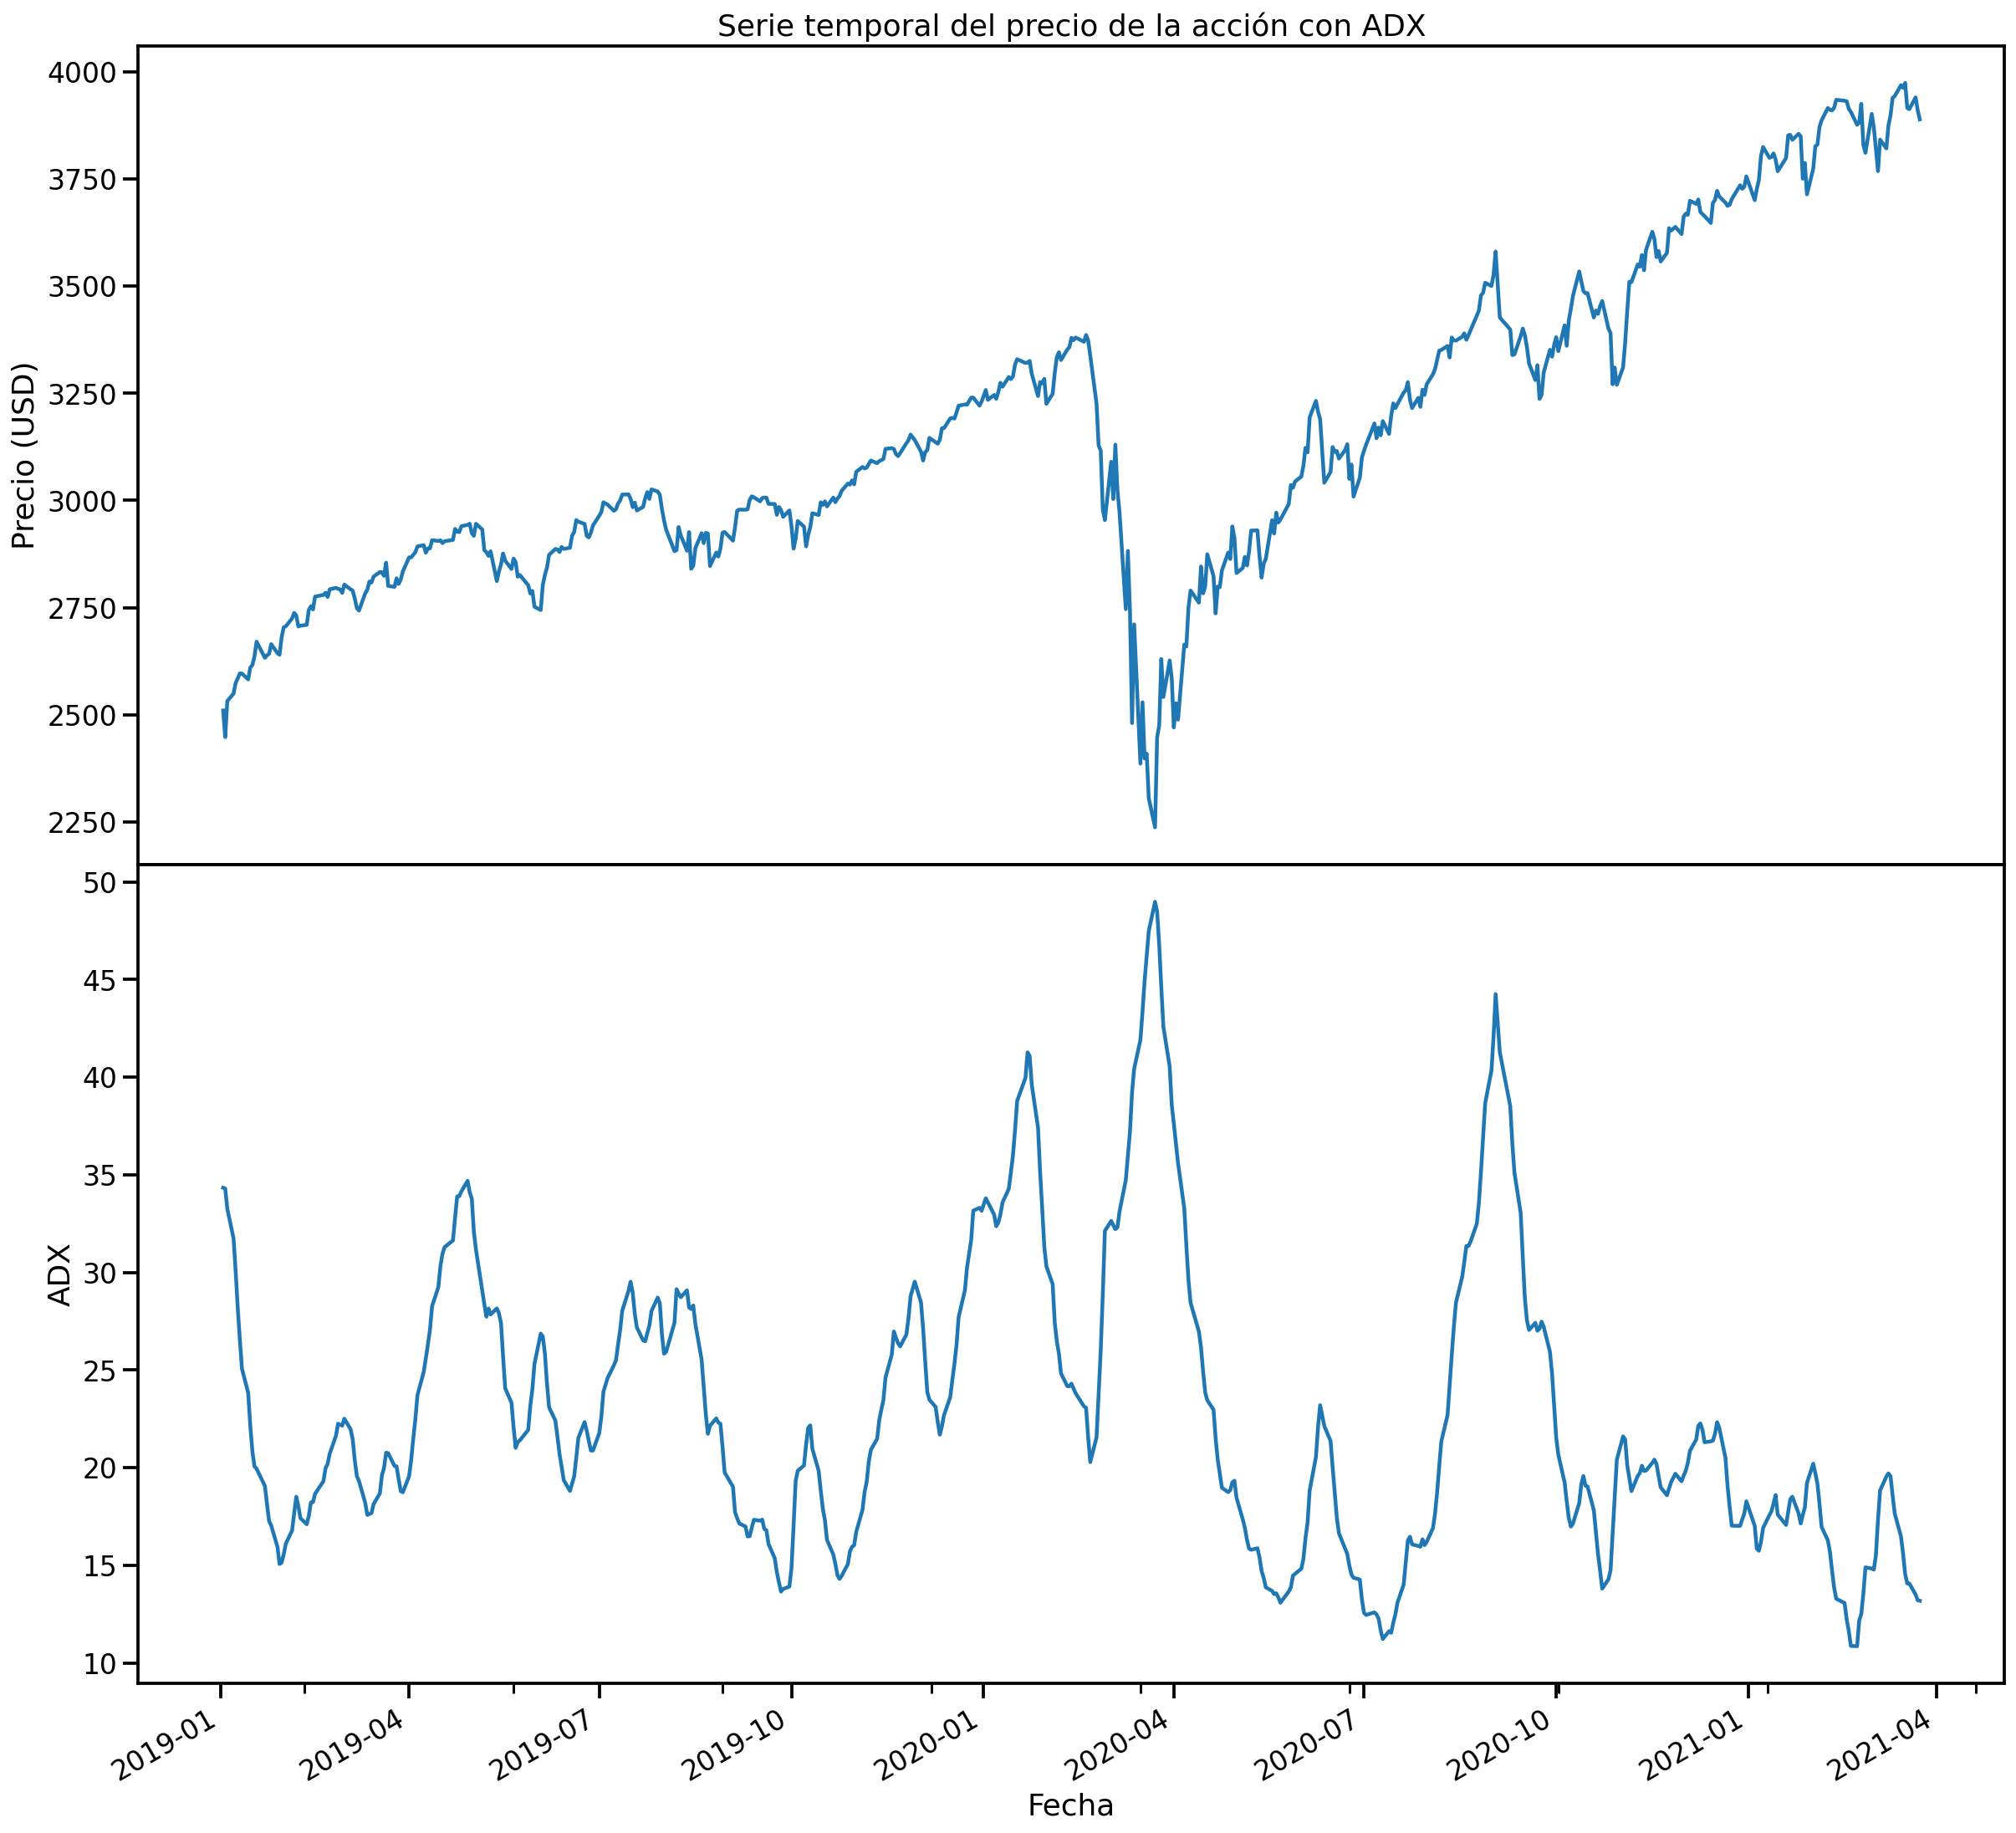

In [25]:
PERIOD = 14
# obtener ADX
stock_prices['adx'] = talib.ADX(stock_prices.high, stock_prices.low, stock_prices.close, timeperiod=PERIOD)

# gráfica del ADX con el precio
def plot_adx(data, starting_date):
    data = data.loc[starting_date:]

    fig, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    data['close'].plot(ax=ax[0])
    ax[0].set(title='Serie temporal del precio de la acción con ADX', ylabel='Precio (USD)')

    data['adx'].plot(ax=ax[1])
    ax[1].set(ylabel='ADX', xlabel='Fecha')

    plt.subplots_adjust(hspace = 0)
    save_fig('figure_2_15', tight_layout=False)
    plt.show()
    
plot_adx(stock_prices, '2019')

Examinamos la correlación del ADX con los retornos futuros. No se observa una correlación fuerte con los retornos futuros aunque sí guarda relación con la volatilidad futura.

Correlación del adx con otras variables:
adx                           1.000000
retornos futuros              0.044885
retornos futuros absolutos    0.173589
Name: adx, dtype: float64


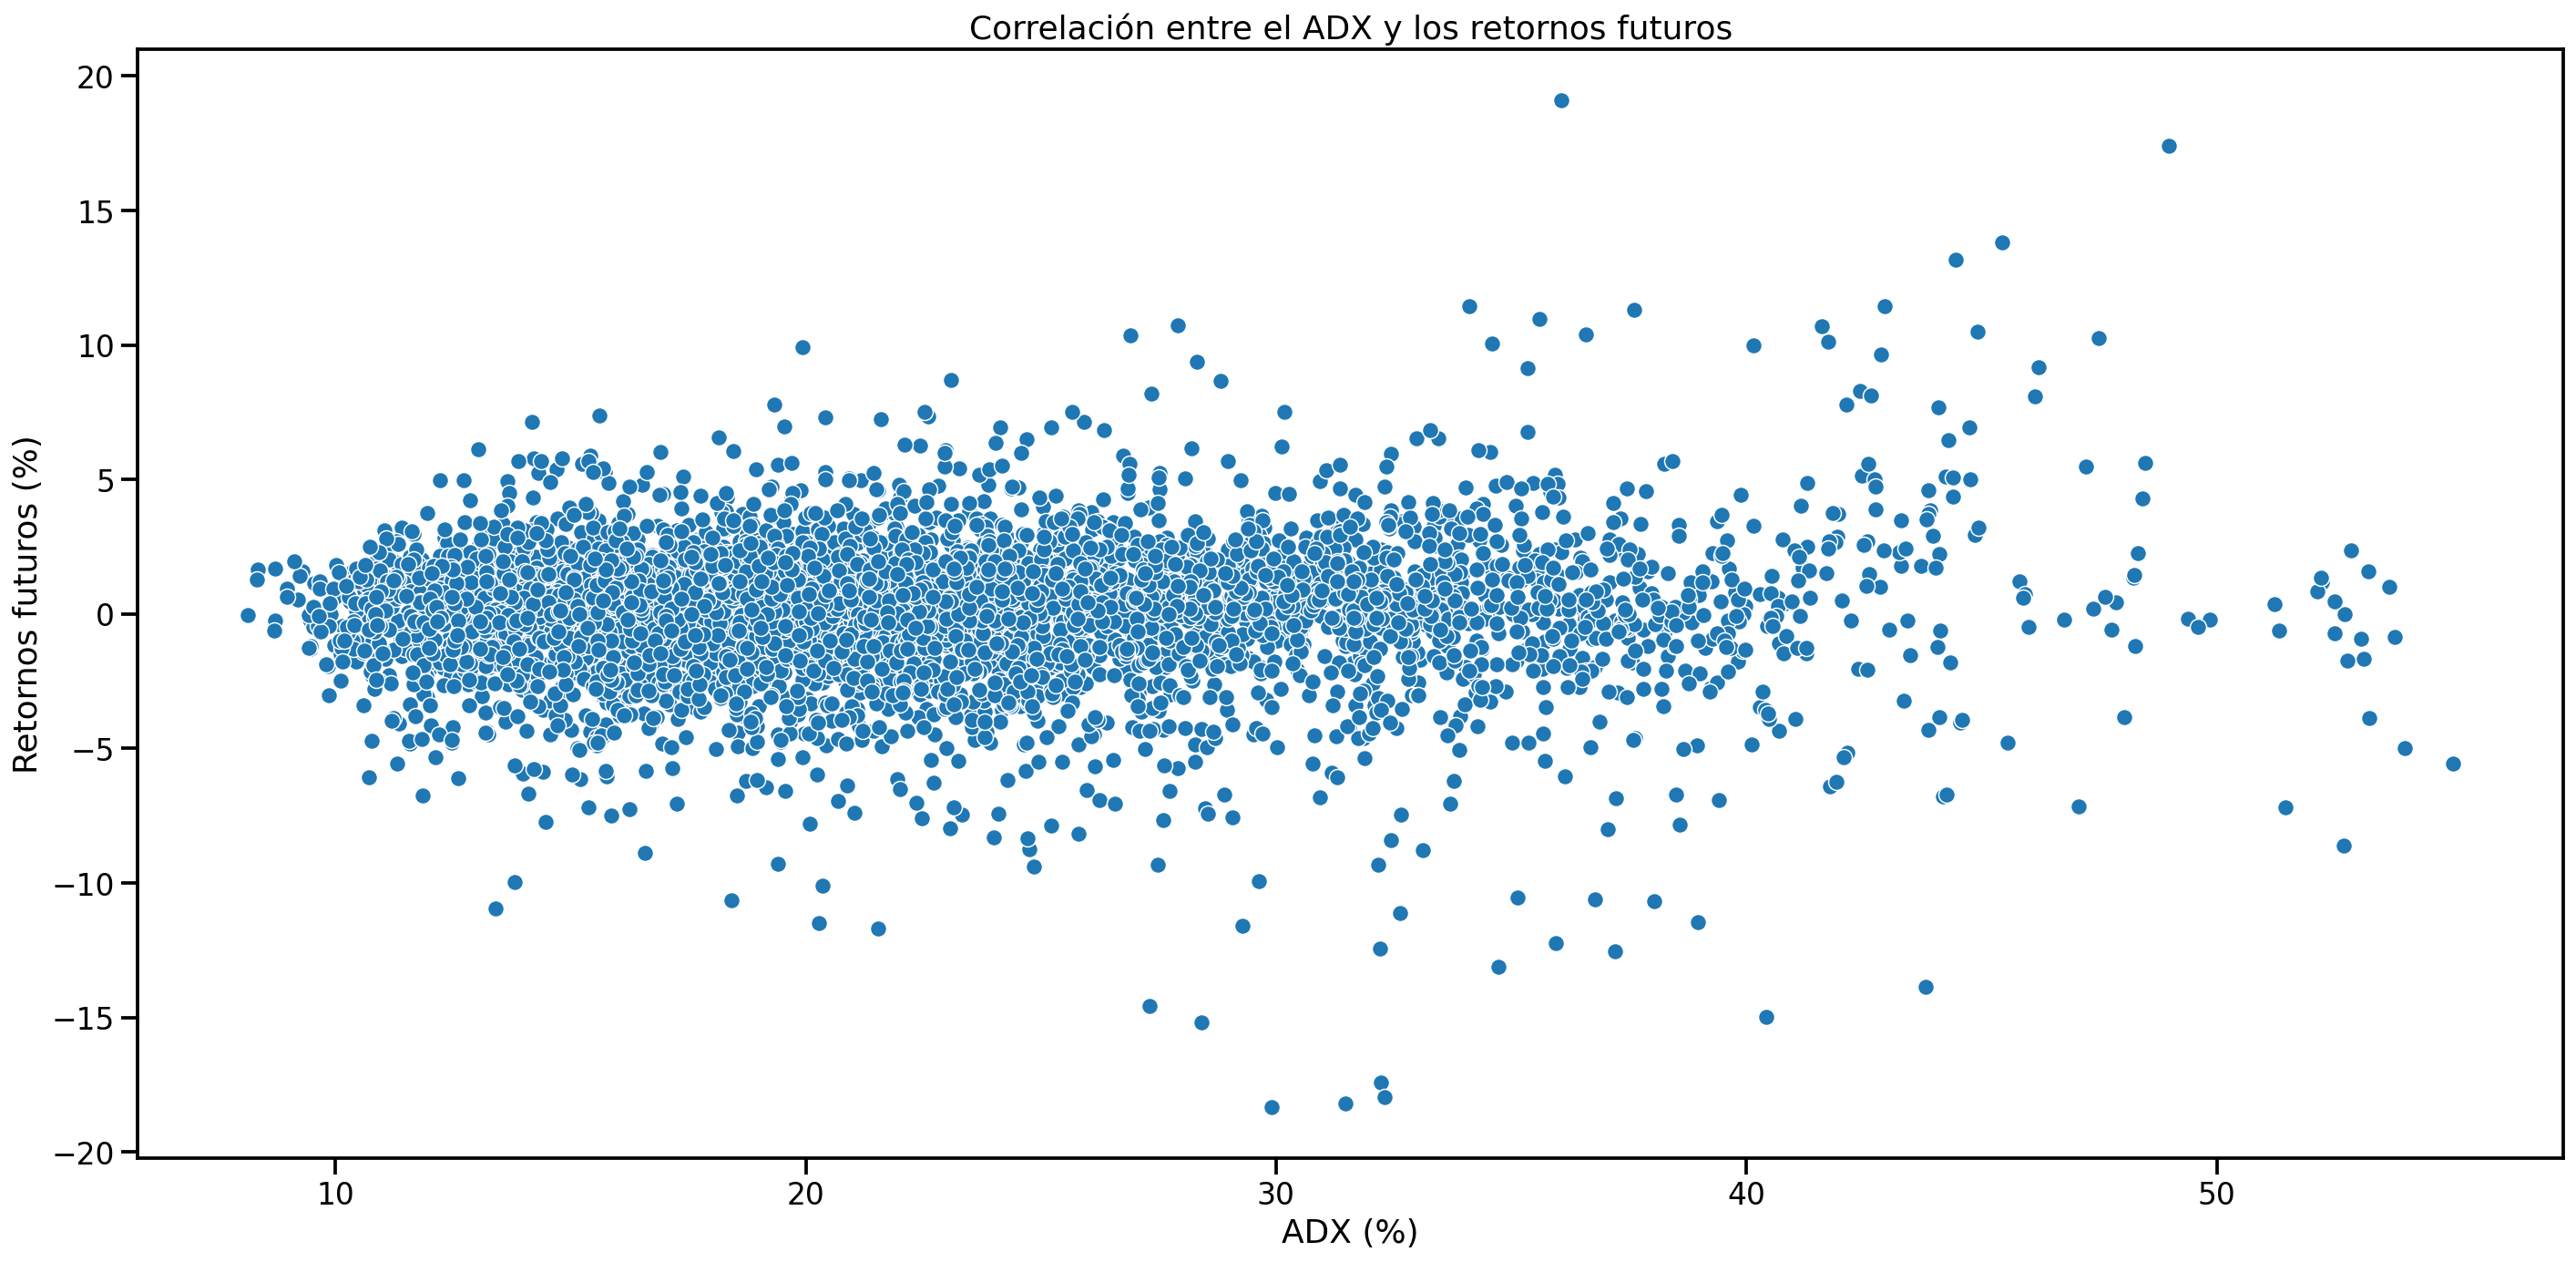

In [91]:
# correlación entre adx, retornos futuros y retornos absolutos futuros
print('Correlación del adx con otras variables:')
print(pd.DataFrame({'adx': stock_prices.adx.values,
              'retornos futuros': stock_prices.future_returns.values,
              'retornos futuros absolutos': np.abs(stock_prices.future_returns)}).corr()['adx'])

# scatter plot del nvi con los retornos futuros
plt.figure(figsize=(20, 10))
sns.scatterplot(x='adx', y='future_returns', data=stock_prices)
plt.title('Correlación entre el ADX y los retornos futuros')
plt.xlabel('ADX (%)')
plt.ylabel('Retornos futuros (%)')

save_fig('figure_2_16')
plt.show()


## 3. Mapa de correlación entre variables
En general no se observa correlaciones altas con las variables objetivo, si que se observa correlaciones entre las variables de entrada, lo que significa que pueden no ser necesarias, pero eso lo determinará el modelo. 

[]

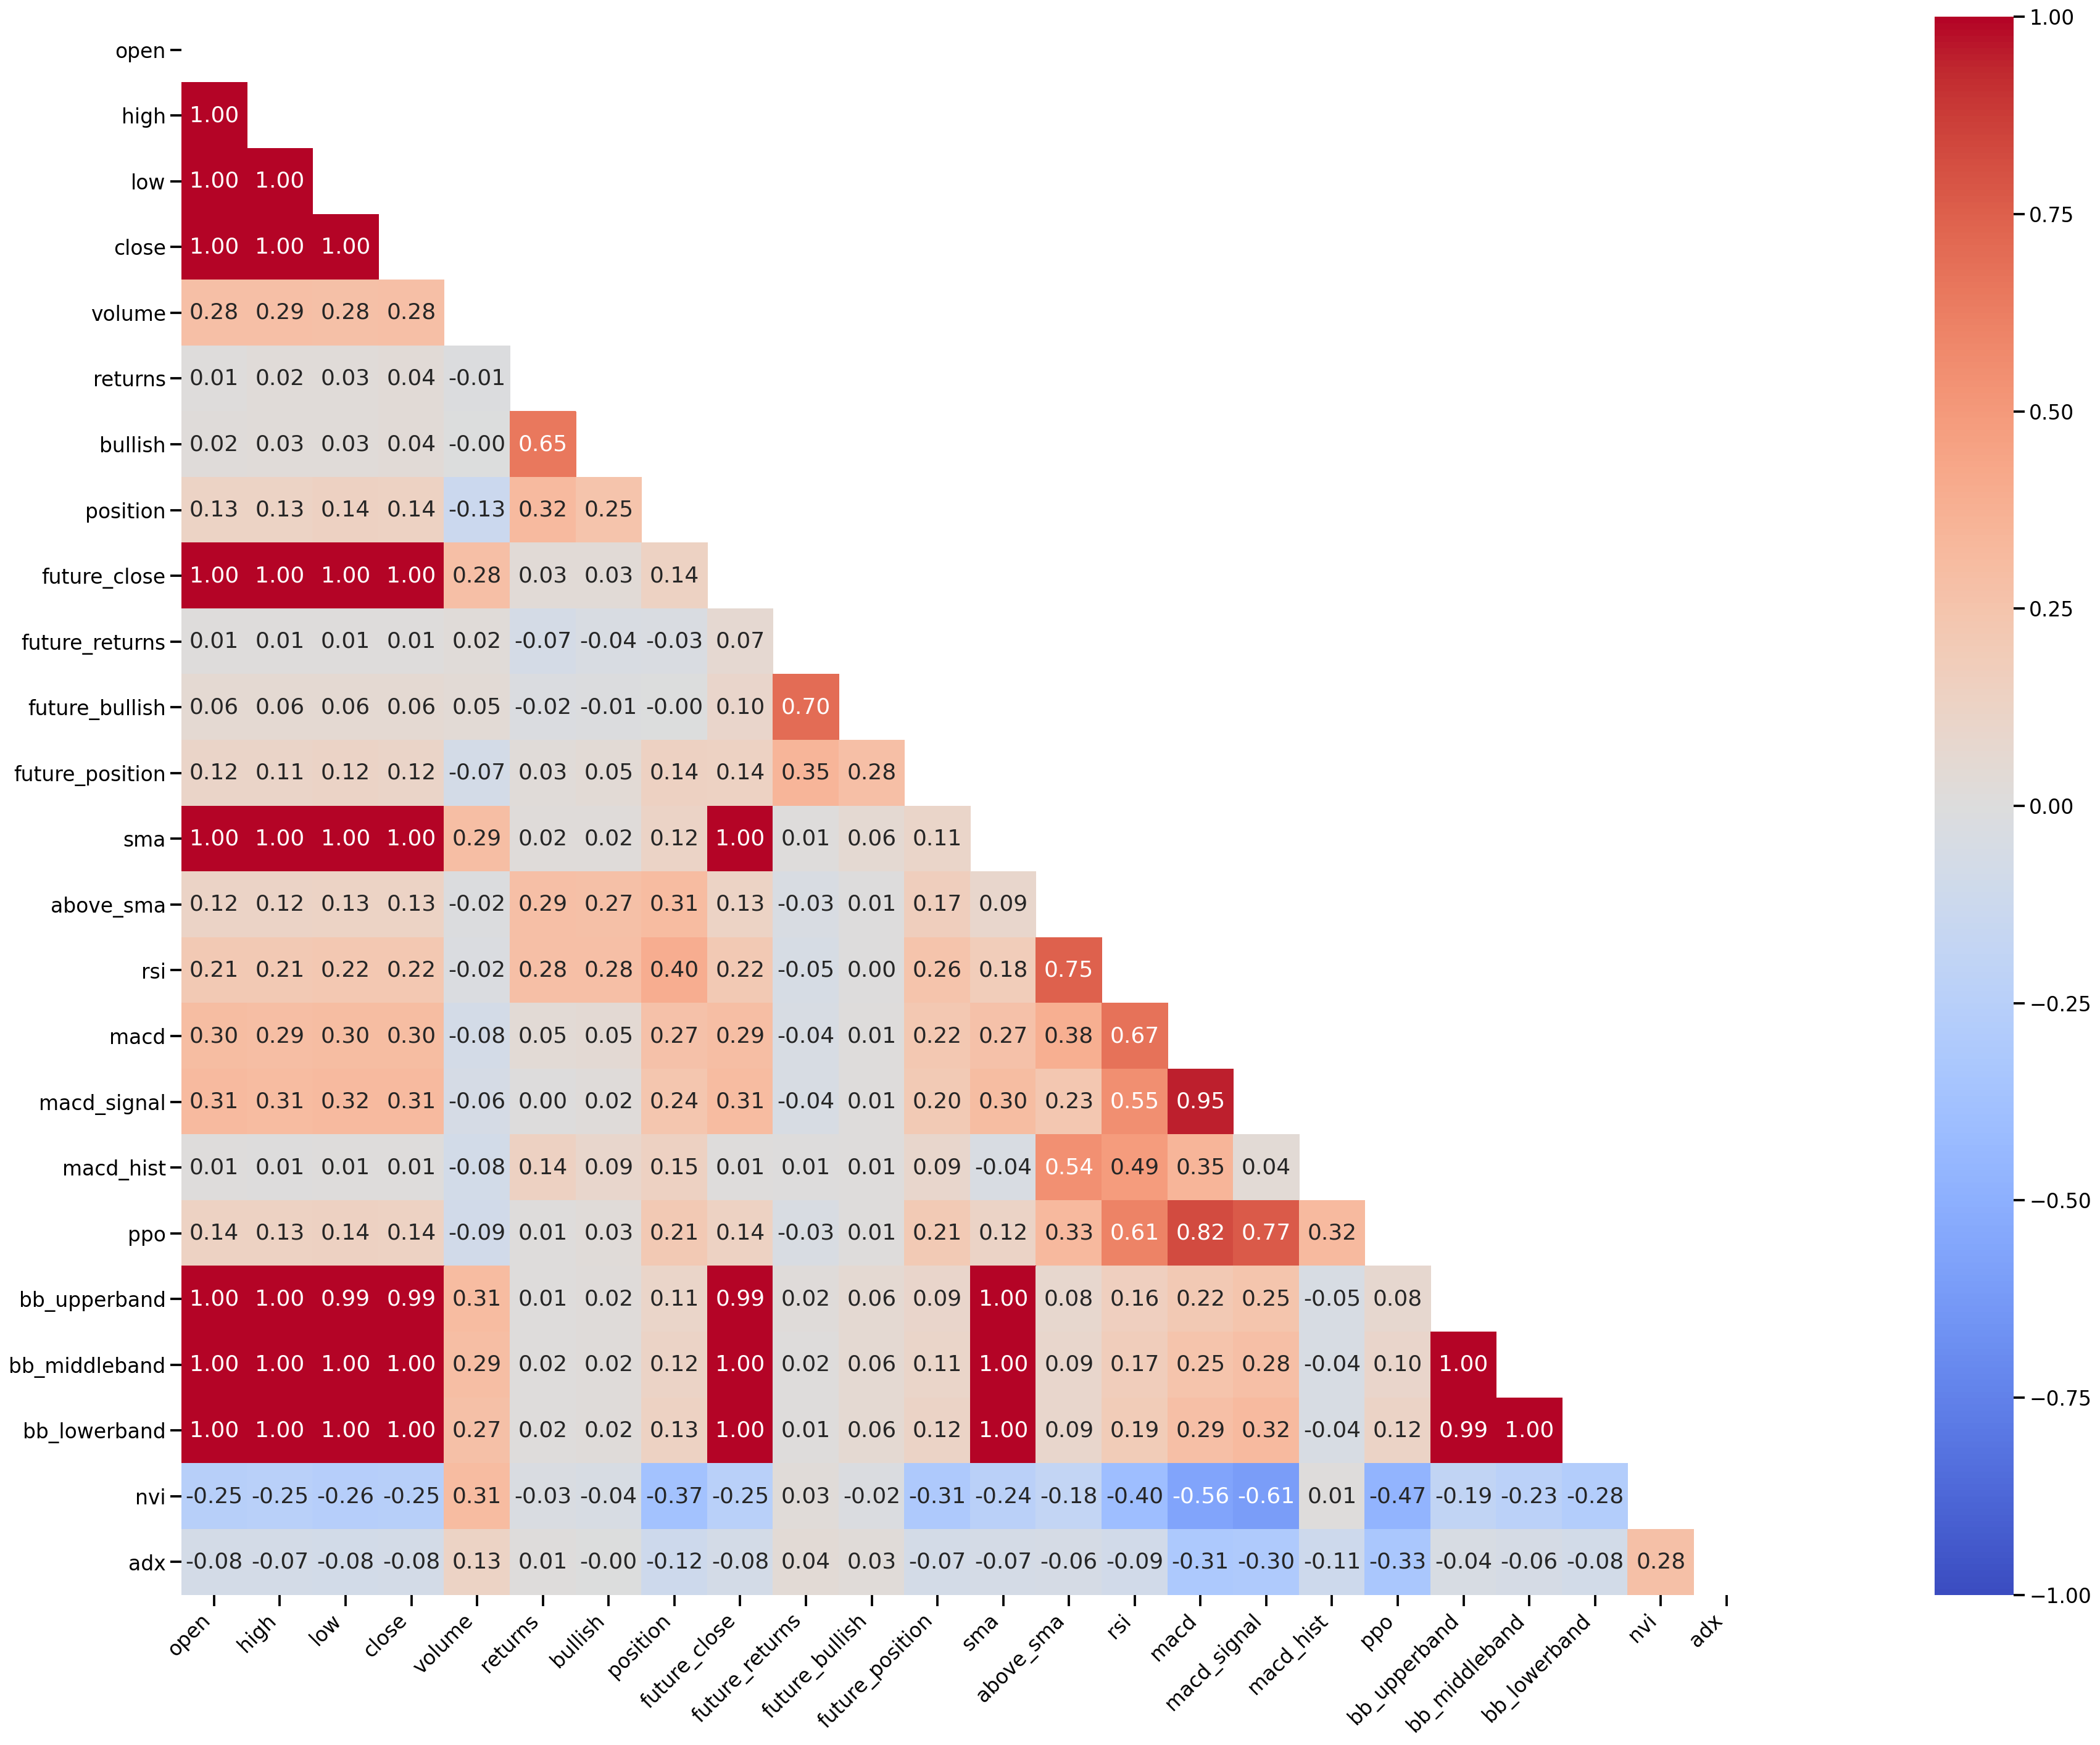

In [27]:
corr_matrix = stock_prices.corr()

mask = np.zeros(corr_matrix.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(40, 20))
ax = sns.heatmap(corr_matrix, annot = True, square=True, vmin=-1, vmax=1, center=0, cmap='coolwarm', fmt='.2f', mask=mask)
plt.xticks(rotation=45, horizontalalignment='right')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

save_fig('figure_2_17')
plt.plot()